In [1]:
import pandas as pd

file_path = 'Merged_IMC_多字段.tsv'  # 替换为你的文件路径

def analyze_tsv_file(file_path):
    """
    分析大型 TSV 文件，统计每个字段的数据行数和缺失值数量。

    Args:
        file_path (str): TSV 文件的路径。

    Returns:
        pandas.DataFrame: 包含字段分析结果的 DataFrame。
    """

    column_data = {}  # 存储每列的数据行数和缺失值数量

    try:
        # 使用 chunksize 分块读取大型 TSV 文件，避免一次性加载到内存
        chunk_size = 100000  # 可以根据内存情况调整 chunk 大小
        tsv_reader = pd.read_csv(file_path, sep='\t', chunksize=chunk_size, iterator=True)

        for chunk_df in tsv_reader:
            for column in chunk_df.columns:
                if column not in column_data:
                    column_data[column] = {'total_rows': 0, 'missing_values': 0}

                column_data[column]['total_rows'] += chunk_df[column].count()  # 统计非缺失值行数
                column_data[column]['missing_values'] += chunk_df[column].isnull().sum() # 统计缺失值行数

    except FileNotFoundError:
        return "文件未找到，请检查文件路径是否正确。"
    except Exception as e:
        return f"读取文件时发生错误: {e}"

    # 将结果转换为 DataFrame 方便展示
    results_df = pd.DataFrame.from_dict(column_data, orient='index')
    results_df['data_rows'] = results_df['total_rows']  # 更直观的列名
    results_df = results_df[['data_rows', 'missing_values']] # 调整列顺序
    results_df.index.name = 'Field Name' # 设置索引列名
    results_df = results_df.sort_values(by='data_rows', ascending=False) # 按数据行数排序

    return results_df

if __name__ == "__main__":
    analysis_result = analyze_tsv_file(file_path)

    if isinstance(analysis_result, str):
        print(analysis_result) # 打印错误信息
    else:
        print("字段数据行数和缺失值统计结果:")
        print(analysis_result)

字段数据行数和缺失值统计结果:
                data_rows  missing_values
Field Name                               
FieldID          11613323               0
PaperID          11613323               0
Citation_Count   11613323               0
C_f              11613320               3
Year             11613320               3
Team_size        11613156             167
IMCft             9399247         2214076
IMCp              9115777         2497546
C5                8528029         3085294
Disruption        6901701         4711622
C10               5688842         5924481
SB_B              4189479         7423844
SB_T              4189479         7423844
Atyp_Median_Z     3797147         7816176


In [2]:
import pandas as pd

file_path = r'D:\BaiduNetdiskDownload\SciSci\2-IMC Calculate\Corrected_Paper_Field_Citing_With_FieldID.tsv' # 使用 raw string 避免路径问题

def count_unique_paper_ids(file_path):
    """
    检查 TSV 文件，统计唯一 PaperID 的数量，并处理大型文件。

    Args:
        file_path (str): TSV 文件的完整路径。

    Returns:
        int: 唯一 PaperID 的数量。
        str: 如果发生错误，则返回错误信息字符串。
    """
    unique_paper_ids = set() # 使用 set 存储唯一的 PaperID，提高效率

    try:
        chunk_size = 100000  # 分块大小，可以根据内存调整
        tsv_reader = pd.read_csv(file_path, sep='\t', chunksize=chunk_size, iterator=True)

        for chunk_df in tsv_reader:
            # 将当前 chunk 的 PaperID 列的唯一值添加到 set 中
            unique_paper_ids.update(chunk_df['PaperID'].unique())

    except FileNotFoundError:
        return "文件未找到，请检查文件路径是否正确。"
    except Exception as e:
        return f"读取文件时发生错误: {e}"

    return len(unique_paper_ids)

if __name__ == "__main__":
    unique_count_result = count_unique_paper_ids(file_path)

    if isinstance(unique_count_result, str):
        print(unique_count_result) # 打印错误信息
    else:
        print(f"文件中唯一的 PaperID 总共有: {unique_count_result} 个")

文件中唯一的 PaperID 总共有: 9399247 个


In [6]:
import pandas as pd
import os
import time
from tqdm import tqdm

# 文件路径
input_file = r"G:\SciSciNet\SciSciNet_PaperAuthorAffiliations.tsv"
output_file = r"G:\SciSciNet\SciSciNet_PaperAuthorAffiliations_FirstAuthor.tsv"

# 获取文件大小
file_size = os.path.getsize(input_file)
print(f"原始文件大小: {file_size / (1024**3):.2f} GB")

# 设置块大小
chunk_size = 1000000  # 每次读取100万行，可根据可用内存调整

# 计数器
total_rows = 0
first_author_rows = 0

# 开始计时
start_time = time.time()

try:
    # 分块处理文件
    print("开始处理文件...")
    
    # 处理文件
    is_first_chunk = True
    
    # 使用tqdm创建进度条 - 估计总块数
    estimated_chunks = max(1, file_size // (chunk_size * 100))  # 假设每行平均100字节
    
    for i, chunk in enumerate(tqdm(pd.read_csv(input_file, sep='\t', chunksize=chunk_size), 
                               total=estimated_chunks, desc="处理进度")):
        # 更新计数器
        chunk_rows = len(chunk)
        total_rows += chunk_rows
        
        # 筛选出第一作者数据(AuthorSequenceNumber=1)
        first_authors = chunk[chunk['AuthorSequenceNumber'] == 1]
        first_author_rows += len(first_authors)
        
        # 写入到输出文件
        mode = 'w' if is_first_chunk else 'a'
        header = is_first_chunk
        first_authors.to_csv(output_file, sep='\t', index=False, mode=mode, header=header)
        
        # 更新标记
        is_first_chunk = False
        
        # 每10个块显示一次统计信息
        if (i + 1) % 10 == 0:
            elapsed = time.time() - start_time
            speed = total_rows / elapsed if elapsed > 0 else 0
            print(f"\n已处理 {total_rows:,} 行，保留 {first_author_rows:,} 行第一作者数据")
            print(f"处理速度: {speed:.0f} 行/秒, 已用时间: {elapsed:.1f} 秒")

except Exception as e:
    print(f"处理过程中发生错误: {e}")
    import traceback
    traceback.print_exc()

# 显示最终统计信息
elapsed_time = time.time() - start_time
print(f"\n处理完成！结果已保存到: {output_file}")
print(f"总行数: {total_rows:,}")
print(f"保留的第一作者行数: {first_author_rows:,} ({first_author_rows/total_rows*100:.2f}%)")
print(f"处理时间: {elapsed_time:.1f} 秒 ({elapsed_time/60:.1f} 分钟)")

# 显示文件大小统计
if os.path.exists(output_file):
    output_size = os.path.getsize(output_file)
    print(f"输入文件大小: {file_size / (1024**3):.2f} GB")
    print(f"输出文件大小: {output_size / (1024**3):.2f} GB")
    print(f"文件大小减少了: {(1 - output_size/file_size) * 100:.2f}%")

原始文件大小: 11.68 GB
开始处理文件...


处理进度:   8%|▊         | 10/125 [00:08<01:38,  1.17it/s]


已处理 10,000,000 行，保留 4,325,638 行第一作者数据
处理速度: 1154908 行/秒, 已用时间: 8.7 秒


处理进度:  16%|█▌        | 20/125 [00:17<01:40,  1.04it/s]


已处理 20,000,000 行，保留 9,187,135 行第一作者数据
处理速度: 1137428 行/秒, 已用时间: 17.6 秒


处理进度:  24%|██▍       | 30/125 [00:27<01:34,  1.01it/s]


已处理 30,000,000 行，保留 13,123,306 行第一作者数据
处理速度: 1102762 行/秒, 已用时间: 27.2 秒


处理进度:  32%|███▏      | 40/125 [00:35<01:13,  1.15it/s]


已处理 40,000,000 行，保留 16,743,867 行第一作者数据
处理速度: 1113218 行/秒, 已用时间: 35.9 秒


处理进度:  40%|████      | 50/125 [00:44<01:05,  1.14it/s]


已处理 50,000,000 行，保留 19,844,291 行第一作者数据
处理速度: 1114520 行/秒, 已用时间: 44.9 秒


处理进度:  48%|████▊     | 60/125 [00:53<00:57,  1.12it/s]


已处理 60,000,000 行，保留 22,926,627 行第一作者数据
处理速度: 1119209 行/秒, 已用时间: 53.6 秒


处理进度:  56%|█████▌    | 70/125 [01:02<00:46,  1.19it/s]


已处理 70,000,000 行，保留 26,004,150 行第一作者数据
处理速度: 1124550 行/秒, 已用时间: 62.2 秒


处理进度:  64%|██████▍   | 80/125 [01:11<00:39,  1.15it/s]


已处理 80,000,000 行，保留 29,079,900 行第一作者数据
处理速度: 1123341 行/秒, 已用时间: 71.2 秒


处理进度:  72%|███████▏  | 90/125 [01:20<00:31,  1.10it/s]


已处理 90,000,000 行，保留 32,163,237 行第一作者数据
处理速度: 1124488 行/秒, 已用时间: 80.0 秒


处理进度:  80%|████████  | 100/125 [01:28<00:20,  1.21it/s]


已处理 100,000,000 行，保留 35,241,521 行第一作者数据
处理速度: 1129513 行/秒, 已用时间: 88.5 秒


处理进度:  88%|████████▊ | 110/125 [01:37<00:13,  1.15it/s]


已处理 110,000,000 行，保留 38,321,750 行第一作者数据
处理速度: 1132620 行/秒, 已用时间: 97.1 秒


处理进度:  96%|█████████▌| 120/125 [01:46<00:04,  1.12it/s]


已处理 120,000,000 行，保留 41,393,405 行第一作者数据
处理速度: 1131693 行/秒, 已用时间: 106.0 秒


处理进度: 130it [01:54,  1.15it/s]                         


已处理 130,000,000 行，保留 44,473,627 行第一作者数据
处理速度: 1132644 行/秒, 已用时间: 114.8 秒


处理进度: 140it [02:03,  1.19it/s]


已处理 140,000,000 行，保留 47,553,417 行第一作者数据
处理速度: 1136444 行/秒, 已用时间: 123.2 秒


处理进度: 150it [02:11,  1.13it/s]


已处理 150,000,000 行，保留 50,637,000 行第一作者数据
处理速度: 1137210 行/秒, 已用时间: 131.9 秒


处理进度: 160it [02:20,  1.22it/s]


已处理 160,000,000 行，保留 53,328,426 行第一作者数据
处理速度: 1141214 行/秒, 已用时间: 140.2 秒


处理进度: 170it [02:28,  1.19it/s]


已处理 170,000,000 行，保留 55,959,880 行第一作者数据
处理速度: 1145038 行/秒, 已用时间: 148.5 秒


处理进度: 180it [02:36,  1.30it/s]


已处理 180,000,000 行，保留 58,581,145 行第一作者数据
处理速度: 1151068 行/秒, 已用时间: 156.4 秒


处理进度: 190it [02:45,  1.16it/s]


已处理 190,000,000 行，保留 61,272,028 行第一作者数据
处理速度: 1150040 行/秒, 已用时间: 165.2 秒


处理进度: 200it [02:53,  1.19it/s]


已处理 200,000,000 行，保留 64,743,109 行第一作者数据
处理速度: 1151364 行/秒, 已用时间: 173.7 秒


处理进度: 210it [03:02,  1.15it/s]


已处理 210,000,000 行，保留 68,424,017 行第一作者数据
处理速度: 1149575 行/秒, 已用时间: 182.7 秒


处理进度: 220it [03:11,  1.01it/s]


已处理 220,000,000 行，保留 72,424,429 行第一作者数据
处理速度: 1147995 行/秒, 已用时间: 191.6 秒


处理进度: 230it [03:23,  1.06it/s]


已处理 230,000,000 行，保留 79,061,220 行第一作者数据
处理速度: 1131091 行/秒, 已用时间: 203.3 秒


处理进度: 240it [03:31,  1.16it/s]


已处理 240,000,000 行，保留 82,855,680 行第一作者数据
处理速度: 1133849 行/秒, 已用时间: 211.7 秒


处理进度: 250it [03:40,  1.00s/it]


已处理 250,000,000 行，保留 87,194,764 行第一作者数据
处理速度: 1131900 行/秒, 已用时间: 220.9 秒


处理进度: 260it [03:49,  1.17it/s]


已处理 260,000,000 行，保留 90,741,009 行第一作者数据
处理速度: 1132571 行/秒, 已用时间: 229.6 秒


处理进度: 270it [03:57,  1.25it/s]


已处理 270,000,000 行，保留 93,782,410 行第一作者数据
处理速度: 1136024 行/秒, 已用时间: 237.7 秒


处理进度: 280it [04:05,  1.22it/s]


已处理 280,000,000 行，保留 96,985,249 行第一作者数据
处理速度: 1139191 行/秒, 已用时间: 245.8 秒


处理进度: 290it [04:14,  1.19it/s]


已处理 290,000,000 行，保留 99,911,194 行第一作者数据
处理速度: 1141223 行/秒, 已用时间: 254.1 秒


处理进度: 300it [04:22,  1.19it/s]


已处理 300,000,000 行，保留 103,116,078 行第一作者数据
处理速度: 1143459 行/秒, 已用时间: 262.4 秒


处理进度: 310it [04:30,  1.24it/s]


已处理 310,000,000 行，保留 105,970,459 行第一作者数据
处理速度: 1145330 行/秒, 已用时间: 270.7 秒


处理进度: 320it [04:38,  1.25it/s]


已处理 320,000,000 行，保留 109,020,891 行第一作者数据
处理速度: 1148059 行/秒, 已用时间: 278.7 秒


处理进度: 330it [04:46,  1.22it/s]


已处理 330,000,000 行，保留 111,995,396 行第一作者数据
处理速度: 1150736 行/秒, 已用时间: 286.8 秒


处理进度: 340it [04:54,  1.35it/s]


已处理 340,000,000 行，保留 114,964,118 行第一作者数据
处理速度: 1153876 行/秒, 已用时间: 294.7 秒


处理进度: 350it [05:02,  1.36it/s]


已处理 350,000,000 行，保留 117,969,681 行第一作者数据
处理速度: 1158690 行/秒, 已用时间: 302.1 秒


处理进度: 360it [05:10,  1.22it/s]


已处理 360,000,000 行，保留 120,805,782 行第一作者数据
处理速度: 1157776 行/秒, 已用时间: 310.9 秒


处理进度: 370it [05:18,  1.30it/s]


已处理 370,000,000 行，保留 123,583,653 行第一作者数据
处理速度: 1161451 行/秒, 已用时间: 318.6 秒


处理进度: 380it [05:25,  1.35it/s]


已处理 380,000,000 行，保留 126,300,383 行第一作者数据
处理速度: 1166357 行/秒, 已用时间: 325.8 秒


处理进度: 390it [05:33,  1.30it/s]


已处理 390,000,000 行，保留 129,352,800 行第一作者数据
处理速度: 1169044 行/秒, 已用时间: 333.6 秒


处理进度: 400it [05:41,  1.28it/s]


已处理 400,000,000 行，保留 132,124,317 行第一作者数据
处理速度: 1170396 行/秒, 已用时间: 341.8 秒


处理进度: 410it [05:48,  1.38it/s]


已处理 410,000,000 行，保留 134,807,027 行第一作者数据
处理速度: 1175137 行/秒, 已用时间: 348.9 秒


处理进度: 414it [05:51,  1.18it/s]


处理完成！结果已保存到: G:\SciSciNet\SciSciNet_PaperAuthorAffiliations_FirstAuthor.tsv
总行数: 413,869,501
保留的第一作者行数: 135,827,039 (32.82%)
处理时间: 351.7 秒 (5.9 分钟)
输入文件大小: 11.68 GB
输出文件大小: 3.84 GB
文件大小减少了: 67.16%


In [8]:
import pandas as pd
import os
import numpy as np

citing_file_path = r'Corrected_Paper_Field_Citing_With_FieldID.tsv' # 第一个文件路径，请确保路径正确
papers_file_path = r'SciSciNet_Papers.tsv' # 大数据集文件路径，请确保路径正确
output_file_path = os.path.join(os.path.dirname(citing_file_path), 'Corrected_Paper_Field_Citing_With_Year_Optimized.tsv') # 输出文件路径，与第一个文件同目录

def merge_paper_years_optimized(citing_file_path, papers_file_path, output_file_path):
    """
    将 Corrected_Paper_Field_Citing_With_FieldID.tsv 文件中的 PaperID 和 Citing_PaperID
    与 SciSciNet_Papers.tsv 文件中的 Year 字段进行匹配，添加论文发表年份信息，并保存到新文件 (优化版 - 使用 set_index() 和 map()).

    Args:
        citing_file_path (str): 第一个 TSV 文件的路径 (Corrected_Paper_Field_Citing_With_FieldID.tsv)。
        papers_file_path (str): 大数据集 TSV 文件的路径 (SciSciNet_Papers.tsv)。
        output_file_path (str): 输出 TSV 文件的路径。

    Returns:
        str: 如果成功完成，返回 "数据合并完成，已保存到：[输出文件路径]"。
             如果发生错误，返回错误信息字符串。
    """

    paper_year_series = None # 用于存储 PaperID 为索引，Year 为值的 Series

    try:
        print("开始预处理 SciSciNet_Papers.tsv 文件...")
        chunk_size_papers = 100000  # 针对 SciSciNet_Papers.tsv 的分块大小
        papers_reader = pd.read_csv(papers_file_path, sep='\t', chunksize=chunk_size_papers, iterator=True, usecols=['PaperID', 'Year']) # 只读取需要的两列
        paper_year_chunks = [] # 存储分块的 Series

        for chunk_papers in papers_reader:
            # 将每个数据块转换为以 PaperID 为索引，Year 为值的 Series
            chunk_series = chunk_papers.set_index('PaperID')['Year']
            paper_year_chunks.append(chunk_series)

        # 将所有分块的 Series 合并为一个大的 Series
        paper_year_series = pd.concat(paper_year_chunks)
        print("SciSciNet_Papers.tsv 文件预处理完成，Series 大小:", len(paper_year_series))


        enriched_chunks = [] # 存储合并后的数据块

        print("开始合并年份数据...")
        chunk_size_citing = 100000 # 针对 Corrected_Paper_Field_Citing_With_FieldID.tsv 的分块大小
        citing_reader = pd.read_csv(citing_file_path, sep='\t', chunksize=chunk_size_citing, iterator=True)

        for chunk_citing in citing_reader:
            # 使用 map() 函数高效查找并添加年份列
            chunk_citing['PaperYear'] = chunk_citing['PaperID'].map(paper_year_series)
            chunk_citing['CitingPaperYear'] = chunk_citing['Citing_PaperID'].map(paper_year_series)

            enriched_chunks.append(chunk_citing)


        enriched_df = pd.concat(enriched_chunks, ignore_index=True)

        print("数据合并完成，开始保存文件...")
        enriched_df.to_csv(output_file_path, sep='\t', index=False)
        print("文件保存完成。")

    except FileNotFoundError:
        return "文件未找到，请检查文件路径是否正确。"
    except KeyError as e:
        return f"列名错误，请检查列名是否正确: {e}"
    except Exception as e:
        return f"处理文件时发生错误: {e}"

    return f"数据合并完成，已保存到：{output_file_path}"


if __name__ == "__main__":
    merge_result = merge_paper_years_optimized(citing_file_path, papers_file_path, output_file_path)
    print(merge_result)

开始预处理 SciSciNet_Papers.tsv 文件...
SciSciNet_Papers.tsv 文件预处理完成，Series 大小: 134129188
开始合并年份数据...
数据合并完成，开始保存文件...
文件保存完成。
数据合并完成，已保存到：Corrected_Paper_Field_Citing_With_Year_Optimized.tsv


In [10]:
import pandas as pd
import os

output_file_path = os.path.join(os.path.dirname(r'D:\BaiduNetdiskDownload\SciSci\2-IMC Calculate\3 filed cited_citing\Corrected_Paper_Field_Citing_With_FieldID.tsv'), 'Corrected_Paper_Field_Citing_With_Year_Optimized.tsv') #  请确保路径与实际输出文件路径一致

def check_missing_values(file_path):
    """
    检查 TSV 文件中各个字段的缺失值数量。

    Args:
        file_path (str): TSV 文件的路径。

    Returns:
        pandas.DataFrame: 包含每个字段缺失值统计结果的 DataFrame。
        str: 如果发生错误，返回错误信息字符串。
    """
    try:
        # 直接读取整个文件，因为这个文件应该是之前处理后的结果，大小可控
        df = pd.read_csv(file_path, sep='\t')

        missing_value_counts = {}
        for column in df.columns:
            missing_count = df[column].isnull().sum()
            missing_value_counts[column] = missing_count

        # 将结果转换为 DataFrame 方便展示
        results_df = pd.DataFrame.from_dict(missing_value_counts, orient='index', columns=['missing_values'])
        results_df.index.name = 'Field Name' # 设置索引列名
        results_df = results_df.sort_values(by='missing_values', ascending=False) # 按缺失值数量排序

        return results_df

    except FileNotFoundError:
        return "文件未找到，请检查文件路径是否正确。"
    except Exception as e:
        return f"读取文件时发生错误: {e}"


if __name__ == "__main__":
    missing_value_result = check_missing_values(output_file_path)

    if isinstance(missing_value_result, str):
        print(missing_value_result) # 打印错误信息
    else:
        print("各字段缺失值统计结果:")
        print(missing_value_result)

各字段缺失值统计结果:
                 missing_values
Field Name                     
CitingPaperYear              28
PaperID                       0
FieldID                       0
Citing_PaperID                0
Citing_FieldID                0
PaperYear                     0


In [11]:
import pandas as pd
import os
import numpy as np

citing_file_path = r'Corrected_Paper_Field_Cited_With_FieldID.tsv' # 第一个文件路径，请确保路径正确
papers_file_path = r'SciSciNet_Papers.tsv' # 大数据集文件路径，请确保路径正确
output_file_path = os.path.join(os.path.dirname(citing_file_path), 'Corrected_Paper_Field_Cited_With_Year_Optimized.tsv') # 输出文件路径，与第一个文件同目录

def merge_paper_years_optimized(citing_file_path, papers_file_path, output_file_path):
    """
    将 Corrected_Paper_Field_Citing_With_FieldID.tsv 文件中的 PaperID 和 Citing_PaperID
    与 SciSciNet_Papers.tsv 文件中的 Year 字段进行匹配，添加论文发表年份信息，并保存到新文件 (优化版 - 使用 set_index() 和 map()).

    Args:
        citing_file_path (str): 第一个 TSV 文件的路径 (Corrected_Paper_Field_Citing_With_FieldID.tsv)。
        papers_file_path (str): 大数据集 TSV 文件的路径 (SciSciNet_Papers.tsv)。
        output_file_path (str): 输出 TSV 文件的路径。

    Returns:
        str: 如果成功完成，返回 "数据合并完成，已保存到：[输出文件路径]"。
             如果发生错误，返回错误信息字符串。
    """

    paper_year_series = None # 用于存储 PaperID 为索引，Year 为值的 Series

    try:
        print("开始预处理 SciSciNet_Papers.tsv 文件...")
        chunk_size_papers = 100000  # 针对 SciSciNet_Papers.tsv 的分块大小
        papers_reader = pd.read_csv(papers_file_path, sep='\t', chunksize=chunk_size_papers, iterator=True, usecols=['PaperID', 'Year']) # 只读取需要的两列
        paper_year_chunks = [] # 存储分块的 Series

        for chunk_papers in papers_reader:
            # 将每个数据块转换为以 PaperID 为索引，Year 为值的 Series
            chunk_series = chunk_papers.set_index('PaperID')['Year']
            paper_year_chunks.append(chunk_series)

        # 将所有分块的 Series 合并为一个大的 Series
        paper_year_series = pd.concat(paper_year_chunks)
        print("SciSciNet_Papers.tsv 文件预处理完成，Series 大小:", len(paper_year_series))


        enriched_chunks = [] # 存储合并后的数据块

        print("开始合并年份数据...")
        chunk_size_citing = 100000 # 针对 Corrected_Paper_Field_Cited_With_FieldID.tsv 的分块大小
        citing_reader = pd.read_csv(citing_file_path, sep='\t', chunksize=chunk_size_citing, iterator=True)

        for chunk_citing in citing_reader:
            # 使用 map() 函数高效查找并添加年份列
            chunk_citing['PaperYear'] = chunk_citing['PaperID'].map(paper_year_series)
            chunk_citing['CitingPaperYear'] = chunk_citing['Cited_PaperID'].map(paper_year_series)

            enriched_chunks.append(chunk_citing)


        enriched_df = pd.concat(enriched_chunks, ignore_index=True)

        print("数据合并完成，开始保存文件...")
        enriched_df.to_csv(output_file_path, sep='\t', index=False)
        print("文件保存完成。")

    except FileNotFoundError:
        return "文件未找到，请检查文件路径是否正确。"
    except KeyError as e:
        return f"列名错误，请检查列名是否正确: {e}"
    except Exception as e:
        return f"处理文件时发生错误: {e}"

    return f"数据合并完成，已保存到：{output_file_path}"


if __name__ == "__main__":
    merge_result = merge_paper_years_optimized(citing_file_path, papers_file_path, output_file_path)
    print(merge_result)

开始预处理 SciSciNet_Papers.tsv 文件...
SciSciNet_Papers.tsv 文件预处理完成，Series 大小: 134129188
开始合并年份数据...
数据合并完成，开始保存文件...
文件保存完成。
数据合并完成，已保存到：Corrected_Paper_Field_Cited_With_Year_Optimized.tsv


In [2]:
import pandas as pd
import os
import numpy as np

file_path = 'Corrected_Paper_Field_Cited_With_Year_Optimized.tsv' # 替换为你的文件路径
output_file_path = 'Paper_Nfii_Nfji_Values_Optimized_V3.tsv' # 输出文件路径

def calculate_nfii_nfji_aggregated_v2(file_path, output_file_path):
    """
    计算 Corrected_Paper_Field_Cited_With_Year_Optimized.tsv 文件中每篇论文的 Nfii 和 聚合 Nfji 值，
    仅考虑发表 5 年以内的引用 (优化版 V3 - 避免 groupby().apply(), 更高效向量化聚合).

    Args:
        file_path (str): 输入 TSV 文件的路径。
        output_file_path (str): 输出 TSV 文件的路径。

    Returns:
        str: 如果成功完成，返回 "Nfii 和 聚合 Nfji 值计算完成，已保存到：[输出文件路径]"。
             如果发生错误，返回错误信息字符串。
    """

    results = []
    try:
        chunk_size = 100000
        tsv_reader = pd.read_csv(file_path, sep='\t', chunksize=chunk_size, iterator=True)


        for chunk in tsv_reader:
            # 5-year citation window filtering (提前进行，chunk 级别)
            valid_citations_chunk = chunk[
                (chunk['PaperYear'] >= chunk['CitingPaperYear']) & (chunk['PaperYear'] <= chunk['CitingPaperYear'] + 5)
            ].copy() # 显式 copy，避免 SettingWithCopyWarning

            unique_cited_paper_ids = valid_citations_chunk['Cited_PaperID'].unique()

            for cited_paper_id in unique_cited_paper_ids:
                if pd.isna(cited_paper_id): # 跳过 NaN Cited_PaperID
                    continue

                cited_paper_data = valid_citations_chunk[valid_citations_chunk['Cited_PaperID'] == cited_paper_id]
                if cited_paper_data.empty: # 理论上不应该为空，double check
                    continue

                cited_paper_field_id = cited_paper_data['Cited_FieldID'].iloc[0]
                cited_paper_year = cited_paper_data['CitingPaperYear'].iloc[0] # CitingPaperYear is actually year of Cited_PaperID

                if pd.isna(cited_paper_field_id) or pd.isna(cited_paper_year): # 检查缺失值
                    continue


                # 向量化计算 Nfii 和 Nfji (无需 groupby().apply(), 直接在 chunk 内向量化)
                nfii_count = (valid_citations_chunk['Cited_PaperID'] == cited_paper_id) & (valid_citations_chunk['FieldID'] == cited_paper_field_id)
                nfii_sum_chunk = nfii_count.sum()


                nfji_count = (valid_citations_chunk['Cited_PaperID'] == cited_paper_id) & (valid_citations_chunk['FieldID'] != cited_paper_field_id)
                nfji_sum_chunk = nfji_count.sum()


                results.append({
                    'PaperID': cited_paper_id,
                    'FieldID': cited_paper_field_id,
                    'PaperYear': cited_paper_year,
                    'Nfii': nfii_sum_chunk,
                    'Nfji': nfji_sum_chunk
                })


        results_df = pd.DataFrame(results)
        results_df.to_csv(output_file_path, sep='\t', index=False)


    except FileNotFoundError:
        return "文件未找到，请检查文件路径是否正确。"
    except KeyError as e:
        return f"列名错误，请检查列名是否正确: {e}"
    except Exception as e:
        return f"处理文件时发生错误: {e}"

    return f"Nfii 和 聚合 Nfji 值计算完成，已保存到：{output_file_path}"


if __name__ == "__main__":
    result_message = calculate_nfii_nfji_aggregated_v2(file_path, output_file_path)
    print(result_message)

Nfii 和 聚合 Nfji 值计算完成，已保存到：Paper_Nfii_Nfji_Values_Optimized_V3.tsv


In [4]:
import pandas as pd
import os

file_path = 'Corrected_Paper_Field_Cited_With_Year_Optimized.tsv' # 替换为你的文件路径

def analyze_fieldid_frequency(file_path):
    """
    检查 Corrected_Paper_Field_Cited_With_Year_Optimized.tsv 文件中 FieldID 列的数据和频数。

    Args:
        file_path (str): 输入 TSV 文件的路径。

    Returns:
        pandas.DataFrame: 包含 FieldID 数据和频数的 DataFrame。
        str: 如果发生错误，返回错误信息字符串。
    """

    fieldid_counts = {}

    try:
        chunk_size = 100000
        tsv_reader = pd.read_csv(file_path, sep='\t', chunksize=chunk_size, iterator=True, usecols=['FieldID']) # 只读取 FieldID 列

        for chunk in tsv_reader:
            fieldid_value_counts_chunk = chunk['FieldID'].value_counts() # 计算当前 chunk 的 FieldID 频数

            for field_id, count in fieldid_value_counts_chunk.items():
                fieldid_counts[field_id] = fieldid_counts.get(field_id, 0) + count # 累加频数

        # 将结果转换为 DataFrame 方便展示
        results_df = pd.DataFrame.from_dict(fieldid_counts, orient='index', columns=['frequency'])
        results_df.index.name = 'FieldID' # 设置索引列名
        results_df = results_df.sort_values(by='frequency', ascending=False) # 按频数降序排序

        return results_df

    except FileNotFoundError:
        return "文件未找到，请检查文件路径是否正确。"
    except KeyError as e:
        return f"列名错误，请检查列名是否正确: {e}"
    except Exception as e:
        return f"处理文件时发生错误: {e}"


if __name__ == "__main__":
    frequency_result = analyze_fieldid_frequency(file_path)

    if isinstance(frequency_result, str):
        print(frequency_result) # 打印错误信息
    else:
        print("FieldID 列数据和频数统计结果:")
        print(frequency_result)

FieldID 列数据和频数统计结果:
           frequency
FieldID             
41008148   101659629
127413603   35910693
162324750   31720120


In [5]:
import pandas as pd
import os

file_path = 'Corrected_Paper_Field_Cited_With_Year_Optimized.tsv' # 替换为你的文件路径
output_file_path = 'Paper_Nfii_Nfji_Values_Final.tsv' # 输出文件路径

def calculate_nfii_nfji_final(file_path, output_file_path):
    """
    计算 Corrected_Paper_Field_Cited_With_Year_Optimized.tsv 文件中每篇论文的 Nfii 和 聚合 Nfji 值，
    仅考虑发表 5 年以内的引用 (最终修正版 - 变量名更清晰, 修正 5 年窗口过滤条件).

    Args:
        file_path (str): 输入 TSV 文件的路径。
        output_file_path (str): 输出 TSV 文件的路径。

    Returns:
        str: 如果成功完成，返回 "Nfii 和 聚合 Nfji 值计算完成，已保存到：[输出文件路径]"。
             如果发生错误，返回错误信息字符串。
    """

    results = []
    try:
        chunk_size = 100000
        tsv_reader = pd.read_csv(file_path, sep='\t', chunksize=chunk_size, iterator=True)


        for chunk in tsv_reader:
            # 5-year citation window filtering (提前进行，chunk 级别) - **已修正过滤条件**
            valid_citations_chunk = chunk[
                (chunk['CitingPaperYear'] >= chunk['PaperYear']) & (chunk['CitingPaperYear'] <= chunk['PaperYear'] + 5)
            ].copy() # 显式 copy，避免 SettingWithCopyWarning

            unique_paper_ids = valid_citations_chunk['PaperID'].unique() # 使用 PaperID 作为被引论文 ID

            for paper_id in unique_paper_ids: # 循环遍历被引论文 PaperID
                if pd.isna(paper_id): # 跳过 NaN PaperID
                    continue

                paper_data = valid_citations_chunk[valid_citations_chunk['PaperID'] == paper_id] # 使用 PaperID 筛选
                if paper_data.empty: # 理论上不应该为空，double check
                    continue

                paper_field_id = paper_data['FieldID'].iloc[0] # 被引论文的 FieldID
                paper_year = paper_data['PaperYear'].iloc[0] # 被引论文的 PaperYear

                if pd.isna(paper_field_id) or pd.isna(paper_year): # 检查缺失值
                    continue


                # 向量化计算 Nfii 和 Nfji (无需 groupby().apply(), 直接在 chunk 内向量化) - 使用 PaperID 筛选
                nfii_count = (paper_data['PaperID'] == paper_id) & (paper_data['Cited_FieldID'] == paper_field_id) # 使用 Cited_FieldID 和 paper_field_id 比较
                nfii_sum_chunk = nfii_count.sum()


                nfji_count = (paper_data['PaperID'] == paper_id) & (paper_data['Cited_FieldID'] != paper_field_id) # 使用 Cited_FieldID 和 paper_field_id 比较
                nfji_sum_chunk = nfji_count.sum()


                results.append({
                    'PaperID': paper_id, # 输出 PaperID (被引论文 ID)
                    'FieldID': paper_field_id, # 输出 FieldID (被引论文学科 ID)
                    'PaperYear': paper_year, # 输出 PaperYear (被引论文发表年份)
                    'Nfii': nfii_sum_chunk,
                    'Nfji': nfji_sum_chunk
                })


        results_df = pd.DataFrame(results)
        results_df.to_csv(output_file_path, sep='\t', index=False)


    except FileNotFoundError:
        return "文件未找到，请检查文件路径是否正确。"
    except KeyError as e:
        return f"列名错误，请检查列名是否正确: {e}"
    except Exception as e:
        return f"处理文件时发生错误: {e}"

    return f"Nfii 和 聚合 Nfji 值计算完成，已保存到：{output_file_path}"


if __name__ == "__main__":
    result_message = calculate_nfii_nfji_aggregated_v2(file_path, output_file_path) # 注意：这里调用的是最终修正版的函数名
    print(result_message)

Nfii 和 聚合 Nfji 值计算完成，已保存到：Paper_Nfii_Nfji_Values_Final.tsv


In [7]:
import pandas as pd
import os

file_path = 'Corrected_Paper_Field_Cited_With_Year_Optimized.tsv' # 替换为你的文件路径
output_file_path = 'Paper_Nfii_Nfji_Values_Final_Corrected_V2.tsv' # 输出文件路径

def calculate_nfii_nfji_final_corrected_v2(file_path, output_file_path):
    """
    计算 Corrected_Paper_Field_Cited_With_Year_Optimized.tsv 文件中每篇论文的 Nfii 和 聚合 Nfji 值，
    仅考虑发表 5 年以内的引用 (真正最终修正版 V2 - 变量名笔误修正).

    Args:
        file_path (str): 输入 TSV 文件的路径。
        output_file_path (str): 输出 TSV 文件的路径。

    Returns:
        str: 如果成功完成，返回 "Nfii 和 聚合 Nfji 值计算完成，已保存到：[输出文件路径]"。
             如果发生错误，返回错误信息字符串。
    """

    results = []
    try:
        chunk_size = 100000
        tsv_reader = pd.read_csv(file_path, sep='\t', chunksize=chunk_size, iterator=True)


        for chunk in tsv_reader:
            unique_paper_ids = chunk['PaperID'].unique() # 正确地循环遍历 PaperID (被引论文 ID)

            for paper_id in unique_paper_ids: # 正确地以内循环 PaperID 为中心
                if pd.isna(paper_id): # 跳过 NaN PaperID
                    continue

                paper_data = chunk[chunk['PaperID'] == paper_id] # 正确地筛选 PaperID 的数据 (所有引用 PaperID 的文献)
                if paper_data.empty: # 理论上不应该为空，double check
                    continue

                paper_field_id = paper_data['FieldID'].iloc[0] # 被引论文的 FieldID
                paper_year = paper_data['PaperYear'].iloc[0] # 被引论文的 PaperYear

                if pd.isna(paper_field_id) or pd.isna(paper_year): # 检查缺失值
                    continue


                # 5-year citation window filtering (提前进行，chunk 级别) - **已修正过滤条件 和 数据筛选**
                valid_citations_chunk = paper_data[ # **基于 paper_data 进行 5 年窗口过滤**
                    (paper_data['CitingPaperYear'] >= paper_year) & (paper_data['CitingPaperYear'] <= paper_year + 5)
                ]

                # 向量化计算 Nfii 和 Nfji (无需 groupby().apply(), 直接在 chunk 内向量化) - **基于 paper_data 和 valid_citations_chunk 计算**
                nfii_count = (valid_citations_chunk['Cited_FieldID'] == paper_field_id).sum() # **基于 valid_citations_chunk 和 paper_field_id 比较**
                nfji_count = len(valid_citations_chunk) - nfii_count # **基于 valid_citations_chunk 计算总数**


                results.append({
                    'PaperID': paper_id, # 输出 PaperID (被引论文 ID)
                    'FieldID': paper_field_id, # 输出 FieldID (被引论文学科 ID)
                    'PaperYear': paper_year, # 输出 PaperYear (被引论文发表年份)
                    'Nfii': nfii_count, # **更正为 nfii_count**
                    'Nfji': nfji_count # **更正为 nfji_count**
                })


        results_df = pd.DataFrame(results)
        results_df.to_csv(output_file_path, sep='\t', index=False)


    except FileNotFoundError:
        return "文件未找到，请检查文件路径是否正确。"
    except KeyError as e:
        return f"列名错误，请检查列名是否正确: {e}"
    except Exception as e:
        return f"处理文件时发生错误: {e}"

    return f"Nfii 和 聚合 Nfji 值计算完成，已保存到：{output_file_path}"


if __name__ == "__main__":
    result_message = calculate_nfii_nfji_final_corrected_v2(file_path, output_file_path) # 注意：这里调用的是最终修正版的函数名
    print(result_message)

Nfii 和 聚合 Nfji 值计算完成，已保存到：Paper_Nfii_Nfji_Values_Final_Corrected_V2.tsv


In [1]:
import csv

def remove_empty_quotes_in_tsv(input_filepath, output_filepath=None):
    """
    读取 TSV 文件，将字段中的 "" 替换为空字符串，并写入新的 TSV 文件或覆盖原文件。

    Args:
        input_filepath (str): 输入 TSV 文件的路径。
        output_filepath (str, optional): 输出 TSV 文件的路径。
                                        如果为 None，则覆盖原始文件。默认为 None。
    """

    if output_filepath is None:
        output_filepath = input_filepath  # 默认覆盖原文件

    try:
        with open(input_filepath, 'r', encoding='utf-8') as infile, \
             open(output_filepath, 'w', encoding='utf-8', newline='') as outfile:

            reader = csv.reader(infile, delimiter='\t')  # 创建 TSV 读取器，分隔符为制表符
            writer = csv.writer(outfile, delimiter='\t', lineterminator='\n') # 创建 TSV 写入器，分隔符为制表符，行尾符为换行符

            for row in reader:
                cleaned_row = []
                for field in row:
                    if field == "":
                        cleaned_row.append("")  # 将 "" 替换为空字符串
                    else:
                        cleaned_row.append(field)
                writer.writerow(cleaned_row)

        print(f"成功处理文件：{input_filepath}")
        if output_filepath != input_filepath:
            print(f"结果已保存到：{output_filepath}")
        else:
            print("已覆盖原始文件。")

    except FileNotFoundError:
        print(f"错误：文件未找到：{input_filepath}")
    except Exception as e:
        print(f"发生错误：{e}")


if __name__ == "__main__":
    input_tsv_file = "Merged_IMC_多字段.tsv"  # 请替换为你的 TSV 文件名
    # 可以选择指定输出文件，或者留空 output_filepath 参数来覆盖原文件
    # output_tsv_file = "Merged_IMC_多字段_cleaned.tsv"
    # remove_empty_quotes_in_tsv(input_tsv_file, output_tsv_file)

    remove_empty_quotes_in_tsv(input_tsv_file) # 覆盖原始文件

成功处理文件：Merged_IMC_多字段.tsv
已覆盖原始文件。


In [2]:
import pandas as pd

# 文件路径
file_path = 'Merged_IMC_多字段.tsv'

# 读取TSV文件，指定分隔符为制表符，并避免默认空值转换
df = pd.read_csv(file_path, sep='\t', keep_default_na=False)

# 将所有字段中的空字符串""替换为None
for col in df.columns:
    df[col] = df[col].apply(lambda x: None if x == "" else x)

# 保存处理后的数据回TSV文件，空值处不写入内容
df.to_csv(file_path, sep='\t', index=False, na_rep='')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_27644\2059783378.py:7: DtypeWarning: Columns (2,3,4,5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep='\t', keep_default_na=False)


In [3]:
import pandas as pd

file_path = 'Merged_IMC_多字段.tsv'  # 替换为你的文件路径

def analyze_tsv_file(file_path):
    """
    分析大型 TSV 文件，统计每个字段的数据行数和缺失值数量。

    Args:
        file_path (str): TSV 文件的路径。

    Returns:
        pandas.DataFrame: 包含字段分析结果的 DataFrame。
    """

    column_data = {}  # 存储每列的数据行数和缺失值数量

    try:
        # 使用 chunksize 分块读取大型 TSV 文件，避免一次性加载到内存
        chunk_size = 100000  # 可以根据内存情况调整 chunk 大小
        tsv_reader = pd.read_csv(file_path, sep='\t', chunksize=chunk_size, iterator=True)

        for chunk_df in tsv_reader:
            for column in chunk_df.columns:
                if column not in column_data:
                    column_data[column] = {'total_rows': 0, 'missing_values': 0}

                column_data[column]['total_rows'] += chunk_df[column].count()  # 统计非缺失值行数
                column_data[column]['missing_values'] += chunk_df[column].isnull().sum() # 统计缺失值行数

    except FileNotFoundError:
        return "文件未找到，请检查文件路径是否正确。"
    except Exception as e:
        return f"读取文件时发生错误: {e}"

    # 将结果转换为 DataFrame 方便展示
    results_df = pd.DataFrame.from_dict(column_data, orient='index')
    results_df['data_rows'] = results_df['total_rows']  # 更直观的列名
    results_df = results_df[['data_rows', 'missing_values']] # 调整列顺序
    results_df.index.name = 'Field Name' # 设置索引列名
    results_df = results_df.sort_values(by='data_rows', ascending=False) # 按数据行数排序

    return results_df

if __name__ == "__main__":
    analysis_result = analyze_tsv_file(file_path)

    if isinstance(analysis_result, str):
        print(analysis_result) # 打印错误信息
    else:
        print("字段数据行数和缺失值统计结果:")
        print(analysis_result)

字段数据行数和缺失值统计结果:
                data_rows  missing_values
Field Name                               
FieldID          11613323               0
PaperID          11613323               0
Citation_Count   11613323               0
C_f              11613320               3
Year             11613320               3
Team_size        11613156             167
IMCft             9399247         2214076
IMCp              9115777         2497546
C5                8528029         3085294
Disruption        6901701         4711622
C10               5688842         5924481
SB_B              4189479         7423844
SB_T              4189479         7423844
Atyp_Median_Z     3797147         7816176


In [5]:
import csv

def merge_c5_data(file1_path, file2_path, output_file_path):
    """
    根据 PaperID 将 Merged_IMC_多字段.tsv 文件中的 C5 列填充到 Paper_Nfii_Nfji_Values_Final_Corrected_V2.tsv 文件中。

    Args:
        file1_path (str): Paper_Nfii_Nfji_Values_Final_Corrected_V2.tsv 文件的路径。
        file2_path (str): Merged_IMC_多字段.tsv 文件的路径。
        output_file_path (str): 输出文件的路径。
    """

    c5_data_dict = {}  # 创建一个字典，用于存储 PaperID 和 C5 的对应关系

    # 读取 Merged_IMC_多字段.tsv 文件并构建 PaperID 到 C5 的字典
    try:
        with open(file2_path, 'r', encoding='utf-8') as file2:
            reader2 = csv.reader(file2, delimiter='\t')
            header2 = next(reader2, None)  # 读取并跳过 header 行，如果存在
            if header2:
                paper_id_col_index_2 = 1  # PaperID 在第二列 (索引为 1)
                c5_col_index_2 = -1 # 假设 C5 是最后一列，需要根据实际情况调整，或者根据header查找列索引
                if 'C5' in header2:
                    c5_col_index_2 = header2.index('C5')
                else:
                    print(f"警告: 文件 {file2_path} 的header中没有找到 'C5' 列，假设最后一列为C5，请检查文件结构。")
                    c5_col_index_2 = len(header2) - 1 if header2 else -1 # 如果有header，取最后一个，否则默认-1

                if c5_col_index_2 == -1:
                    print(f"错误: 无法确定文件 {file2_path} 中的 'C5' 列位置，请检查文件结构和header。")
                    return

            else: # 如果没有header，假设 PaperID 是第二列，C5 是最后一列，需要根据实际情况调整
                paper_id_col_index_2 = 1
                c5_col_index_2 = -1 # 假设 C5 是最后一列，需要根据实际情况调整

            for row in reader2:
                if len(row) > max(paper_id_col_index_2, c5_col_index_2) and row[paper_id_col_index_2].strip() and row[c5_col_index_2].strip(): # 确保行有足够的列，且 PaperID 和 C5 不为空
                    try:
                        paper_id = row[paper_id_col_index_2].strip() # 获取 PaperID 并去除空格
                        c5_value = row[c5_col_index_2].strip()      # 获取 C5 值并去除空格
                        c5_data_dict[paper_id] = c5_value
                    except IndexError:
                        print(f"警告: 行数据列数不足，跳过: {row}")
                    except Exception as e:
                        print(f"警告: 处理行数据时发生错误: {row}, 错误信息: {e}")

    except FileNotFoundError:
        print(f"错误: 文件 {file2_path} 未找到，请检查文件路径。")
        return
    except Exception as e:
        print(f"读取文件 {file2_path} 时发生错误: {e}")
        return


    # 读取 Paper_Nfii_Nfji_Values_Final_Corrected_V2.tsv 文件，并添加 C5 列
    try:
        with open(file1_path, 'r', encoding='utf-8') as file1, open(output_file_path, 'w', encoding='utf-8', newline='') as outfile:
            reader1 = csv.reader(file1, delimiter='\t')
            writer = csv.writer(outfile, delimiter='\t')

            header1 = next(reader1, None) # 读取 file1 的 header
            if header1:
                updated_header = header1 + ['C5'] # 在 header 中添加 'C5' 列名
                writer.writerow(updated_header) # 写入新的 header
            else:
                writer.writerow(['PaperID', 'FieldID', 'PaperYear', 'OtherField1', 'OtherField2', 'C5']) # 如果 file1 没有 header，则写入默认 header


            paper_id_col_index_1 = 0  # PaperID 在第一列 (索引为 0)

            for row in reader1:
                if len(row) > paper_id_col_index_1 and row[paper_id_col_index_1].strip(): # 确保行有足够的列，且 PaperID 不为空
                    paper_id = row[paper_id_col_index_1].strip() # 获取 PaperID 并去除空格
                    c5_value = c5_data_dict.get(paper_id, '') # 从字典中查找 C5 值，如果找不到则默认为空字符串
                    updated_row = row + [c5_value] # 将 C5 值添加到行尾
                    writer.writerow(updated_row) # 写入更新后的行
                else:
                    print(f"警告: 行数据列数不足或 PaperID 为空，跳过: {row}")


    except FileNotFoundError:
        print(f"错误: 文件 {file1_path} 未找到，请检查文件路径。")
        return
    except Exception as e:
        print(f"处理文件 {file1_path} 时发生错误: {e}")
        return

    print(f"已成功将 C5 数据从 {file2_path} 合并到 {file1_path}，结果已保存到 {output_file_path}")


# 定义文件路径和输出文件路径
file1_path = "Paper_Nfii_Nfji_Values_Final_Corrected_V2.tsv"
file2_path = "Merged_IMC_多字段.tsv"
output_file_path = "Paper_Nfii_Nfji_Values_Final_Corrected_V2_C5_added.tsv" # 输出到新文件，可以根据需要修改

# 调用函数执行合并操作
merge_c5_data(file1_path, file2_path, output_file_path)

已成功将 C5 数据从 Merged_IMC_多字段.tsv 合并到 Paper_Nfii_Nfji_Values_Final_Corrected_V2.tsv，结果已保存到 Paper_Nfii_Nfji_Values_Final_Corrected_V2_C5_added.tsv


In [7]:
import csv

def calculate_intraflowf_corrected(input_file_path, output_file_path):
    """
    计算 InTraFlowf 指标并添加到 TSV 文件中，处理非数值类型和空值。

    InTraFlowf = (Nfji + 1 - Nfii) / C5

    Args:
        input_file_path (str): 输入 TSV 文件路径 (Paper_Nfii_Nfji_Values_Final_Corrected_V2_C5_added.tsv).
        output_file_path (str): 输出 TSV 文件路径 (例如 Paper_Nfii_Nfji_Values_Final_Corrected_V2_C5_InTraFlowf.tsv).
    """

    try:
        with open(input_file_path, 'r', encoding='utf-8') as infile, \
             open(output_file_path, 'w', encoding='utf-8', newline='') as outfile:

            reader = csv.reader(infile, delimiter='\t')
            writer = csv.writer(outfile, delimiter='\t')

            header = next(reader)  # 读取 header 行
            updated_header = header + ['InTraFlowf']  # 添加 'InTraFlowf' 到 header
            writer.writerow(updated_header)  # 写入新的 header

            for row_index, row in enumerate(reader): # 使用 enumerate 获取行索引，方便错误信息定位
                if len(row) >= 6:  # 确保行至少有 6 列 (PaperID, FieldID, PaperYear, Nfii, Nfji, C5)
                    try:
                        nfii_str = row[3].strip()  # Nfii 在第 4 列 (索引 3)
                        nfji_str = row[4].strip()  # Nfji 在第 5 列 (索引 4)
                        c5_str = row[5].strip()    # C5 在第 6 列 (索引 5)

                        nfii = 0.0 # 默认值
                        nfji = 0.0 # 默认值
                        c5 = 0.0   # 默认值

                        try:
                            nfii = float(nfii_str) if nfii_str else 0.0 # 如果为空字符串则默认为0
                        except ValueError:
                            print(f"警告: 行 {row_index+2}: Nfii 列值 '{nfii_str}' 不是有效数值，已设置为 0。行数据: {row}")

                        try:
                            nfji = float(nfji_str) if nfji_str else 0.0 # 如果为空字符串则默认为0
                        except ValueError:
                            print(f"警告: 行 {row_index+2}: Nfji 列值 '{nfji_str}' 不是有效数值，已设置为 0。行数据: {row}")

                        try:
                            c5 = float(c5_str) if c5_str else 0.0 # 如果为空字符串则默认为0
                        except ValueError:
                            print(f"警告: 行 {row_index+2}: C5 列值 '{c5_str}' 不是有效数值，已设置为 0。行数据: {row}")


                        if c5 != 0:
                            intraflowf = (nfji + 1 - nfii) / c5
                        else:
                            intraflowf = 'NaN'  # 如果 C5 为 0，则 InTraFlowf 设为 'NaN' (Not a Number) 表示未定义或无穷大

                        updated_row = row + [intraflowf]  # 将 InTraFlowf 添加到行尾
                        writer.writerow(updated_row)  # 写入更新后的行

                    except IndexError:
                        print(f"警告: 行 {row_index+2}: 行数据列数不足，跳过计算 InTraFlowf，行: {row}")
                        writer.writerow(row + ['']) # 写入原始行，并在 InTraFlowf 列留空

                else:
                    print(f"警告: 行 {row_index+2}: 行数据列数不足 (少于 6 列)，跳过，行: {row}")
                    writer.writerow(row + ['']) # 写入原始行，并在 InTraFlowf 列留空


        print(f"已成功计算 InTraFlowf 并保存到 {output_file_path}")

    except FileNotFoundError:
        print(f"错误: 文件 '{input_file_path}' 未找到，请检查文件路径。")
    except Exception as e:
        print(f"处理文件时发生错误: {e}")


# 定义输入和输出文件路径
input_file_path = "Paper_Nfii_Nfji_Values_Final_Corrected_V2_C5_added.tsv"
output_file_path = "Paper_Nfii_Nfji_Values_Final_Corrected_V2_C5_InTraFlowf.tsv"

# 调用函数执行计算和写入操作
calculate_intraflowf_corrected(input_file_path, output_file_path)

已成功计算 InTraFlowf 并保存到 Paper_Nfii_Nfji_Values_Final_Corrected_V2_C5_InTraFlowf.tsv


In [8]:
import csv

def analyze_tsv_file(file_path):
    """
    分析 TSV 文件，统计每个字段的行数、空值和 NaN 值。

    Args:
        file_path (str): TSV 文件的路径。
    """

    try:
        with open(file_path, 'r', encoding='utf-8') as tsvfile:
            reader = csv.reader(tsvfile, delimiter='\t')
            header = next(reader, None)  # 读取 header 行

            if not header:
                print(f"错误: 文件 '{file_path}' 没有 header 行或为空文件。")
                return

            column_data = {field: [] for field in header} # 使用字典存储每列的数据

            for row in reader:
                for i, value in enumerate(row):
                    if i < len(header): # 确保列索引在 header 范围内
                        column_data[header[i]].append(value.strip()) # 去除值两端空格

            print(f"文件 '{file_path}' 分析报告:\n")

            for field in header:
                values = column_data[field]
                total_rows = len(values)
                empty_count = values.count('')
                nan_count = values.count('NaN') if field == 'InTraFlowf' else 0 # 只对 InTraFlowf 列统计 NaN

                print(f"字段: '{field}'")
                print(f"  总行数 (不含 header): {total_rows}")
                print(f"  空值 (空字符串) 数量: {empty_count}")
                if field == 'InTraFlowf':
                    print(f"  NaN 值 数量: {nan_count}") # 只在 InTraFlowf 列显示 NaN 计数
                print("-" * 30)

    except FileNotFoundError:
        print(f"错误: 文件 '{file_path}' 未找到，请检查文件路径。")
    except Exception as e:
        print(f"读取文件 '{file_path}' 时发生错误: {e}")


# 定义要分析的文件路径
file_path_to_analyze = "Paper_Nfii_Nfji_Values_Final_Corrected_V2_C5_InTraFlowf.tsv" # 替换为您要分析的文件路径
analyze_tsv_file(file_path_to_analyze)

文件 'Paper_Nfii_Nfji_Values_Final_Corrected_V2_C5_InTraFlowf.tsv' 分析报告:

字段: 'PaperID'
  总行数 (不含 header): 9117368
  空值 (空字符串) 数量: 0
------------------------------
字段: 'FieldID'
  总行数 (不含 header): 9117368
  空值 (空字符串) 数量: 0
------------------------------
字段: 'PaperYear'
  总行数 (不含 header): 9117368
  空值 (空字符串) 数量: 0
------------------------------
字段: 'Nfii'
  总行数 (不含 header): 9117368
  空值 (空字符串) 数量: 0
------------------------------
字段: 'Nfji'
  总行数 (不含 header): 9117368
  空值 (空字符串) 数量: 0
------------------------------
字段: 'C5'
  总行数 (不含 header): 9117368
  空值 (空字符串) 数量: 1983820
------------------------------
字段: 'InTraFlowf'
  总行数 (不含 header): 9117368
  空值 (空字符串) 数量: 0
  NaN 值 数量: 3048823
------------------------------


In [9]:
import csv

def merge_intraflowf_to_merged_imc(intraflowf_file_path, merged_imc_file_path, output_file_path):
    """
    根据 PaperID 将 Paper_Nfii_Nfji_Values_Final_Corrected_V2_C5_InTraFlowf.tsv 文件中的 InTraFlowf 列
    匹配到 Merged_IMC_多字段.tsv 文件中。

    Args:
        intraflowf_file_path (str): Paper_Nfii_Nfji_Values_Final_Corrected_V2_C5_InTraFlowf.tsv 文件的路径。
        merged_imc_file_path (str): Merged_IMC_多字段.tsv 文件的路径。
        output_file_path (str): 输出文件的路径。
    """

    intraflowf_dict = {}  # 创建一个字典，用于存储 PaperID 和 InTraFlowf 的对应关系

    # 读取 Paper_Nfii_Nfji_Values_Final_Corrected_V2_C5_InTraFlowf.tsv 文件并构建 PaperID 到 InTraFlowf 的字典
    try:
        with open(intraflowf_file_path, 'r', encoding='utf-8') as intraflowf_file:
            reader_intraflowf = csv.reader(intraflowf_file, delimiter='\t')
            header_intraflowf = next(reader_intraflowf, None)  # 读取并跳过 header 行，如果存在

            if header_intraflowf and 'PaperID' in header_intraflowf and 'InTraFlowf' in header_intraflowf:
                paper_id_col_index_intraflowf = header_intraflowf.index('PaperID')
                intraflowf_col_index = header_intraflowf.index('InTraFlowf')
            else:
                print(f"错误: 文件 {intraflowf_file_path} 的header中没有找到 'PaperID' 或 'InTraFlowf' 列，或者没有header行。请检查文件结构。假设 PaperID 在第1列， InTraFlowf 在最后一列。")
                paper_id_col_index_intraflowf = 0 # 假设 PaperID 是第一列
                intraflowf_col_index = -1 # 假设 InTraFlowf 是最后一列

            for row in reader_intraflowf:
                if len(row) > max(paper_id_col_index_intraflowf, intraflowf_col_index) and row[paper_id_col_index_intraflowf].strip(): # 确保行有足够的列，且 PaperID 不为空
                    try:
                        paper_id = row[paper_id_col_index_intraflowf].strip() # 获取 PaperID 并去除空格
                        intraflowf_value = row[intraflowf_col_index].strip() if intraflowf_col_index != -1 and row[intraflowf_col_index].strip() else '' # 获取 InTraFlowf 值并去除空格，如果列索引为-1或者值为空则设为空字符串
                        intraflowf_dict[paper_id] = intraflowf_value
                    except IndexError:
                        print(f"警告: 行数据列数不足，跳过: {row}")
                    except Exception as e:
                        print(f"警告: 处理行数据时发生错误: {row}, 错误信息: {e}")

    except FileNotFoundError:
        print(f"错误: 文件 {intraflowf_file_path} 未找到，请检查文件路径。")
        return
    except Exception as e:
        print(f"读取文件 {intraflowf_file_path} 时发生错误: {e}")
        return

    # 读取 Merged_IMC_多字段.tsv 文件，并添加 InTraFlowf 列
    try:
        with open(merged_imc_file_path, 'r', encoding='utf-8') as merged_imc_file, \
             open(output_file_path, 'w', encoding='utf-8', newline='') as outfile:
            reader_merged_imc = csv.reader(merged_imc_file, delimiter='\t')
            writer = csv.writer(outfile, delimiter='\t')

            header_merged_imc = next(reader_merged_imc, None) # 读取 merged_imc_file 的 header
            if header_merged_imc:
                updated_header = header_merged_imc + ['InTraFlowf'] # 在 header 中添加 'InTraFlowf' 列名
                writer.writerow(updated_header) # 写入新的 header
            else:
                writer.writerow([''] + ['InTraFlowf']) # 如果 merged_imc_file 没有 header，则写入默认 header (假设第一列是空的，需要根据实际情况调整)
                print(f"警告: 文件 {merged_imc_file_path} 没有header行，输出文件header可能不正确，请检查。")


            paper_id_col_index_merged_imc = 1  # PaperID 在第二列 (索引为 1)

            for row in reader_merged_imc:
                if len(row) > paper_id_col_index_merged_imc and row[paper_id_col_index_merged_imc].strip(): # 确保行有足够的列，且 PaperID 不为空
                    paper_id = row[paper_id_col_index_merged_imc].strip() # 获取 PaperID 并去除空格
                    intraflowf_value = intraflowf_dict.get(paper_id, '') # 从字典中查找 InTraFlowf 值，如果找不到则默认为空字符串
                    updated_row = row + [intraflowf_value] # 将 InTraFlowf 值添加到行尾
                    writer.writerow(updated_row) # 写入更新后的行
                else:
                    print(f"警告: 行数据列数不足或 PaperID 为空，跳过: {row}")


    except FileNotFoundError:
        print(f"错误: 文件 {merged_imc_file_path} 未找到，请检查文件路径。")
        return
    except Exception as e:
        print(f"处理文件 {merged_imc_file_path} 时发生错误: {e}")
        return

    print(f"已成功将 InTraFlowf 数据从 {intraflowf_file_path} 合并到 {merged_imc_file_path}, 结果已保存到 {output_file_path}")


# 定义文件路径和输出文件路径
intraflowf_file_path = "Paper_Nfii_Nfji_Values_Final_Corrected_V2_C5_InTraFlowf.tsv"
merged_imc_file_path = "Merged_IMC_多字段.tsv"
output_file_path = "Merged_IMC_多字段_InTraFlowf_added.tsv" # 输出到新文件，可以根据需要修改

# 调用函数执行合并操作
merge_intraflowf_to_merged_imc(intraflowf_file_path, merged_imc_file_path, output_file_path)

已成功将 InTraFlowf 数据从 Paper_Nfii_Nfji_Values_Final_Corrected_V2_C5_InTraFlowf.tsv 合并到 Merged_IMC_多字段.tsv, 结果已保存到 Merged_IMC_多字段_InTraFlowf_added.tsv


In [ ]:
import csv

def analyze_tsv_file(file_path):
    """
    分析 TSV 文件，统计每个字段的行数、空值和 NaN 值。

    Args:
        file_path (str): TSV 文件的路径。
    """

    try:
        with open(file_path, 'r', encoding='utf-8') as tsvfile:
            reader = csv.reader(tsvfile, delimiter='\t')
            header = next(reader, None)  # 读取 header 行

            if not header:
                print(f"错误: 文件 '{file_path}' 没有 header 行或为空文件。")
                return

            column_data = {field: [] for field in header} # 使用字典存储每列的数据

            for row in reader:
                for i, value in enumerate(row):
                    if i < len(header): # 确保列索引在 header 范围内
                        column_data[header[i]].append(value.strip()) # 去除值两端空格

            print(f"文件 '{file_path}' 分析报告:\n")

            for field in header:
                values = column_data[field]
                total_rows = len(values)
                empty_count = values.count('')
                nan_count = values.count('NaN') if field == 'InTraFlowf' else 0 # 只对 InTraFlowf 列统计 NaN

                print(f"字段: '{field}'")
                print(f"  总行数 (不含 header): {total_rows}")
                print(f"  空值 (空字符串) 数量: {empty_count}")
                if field == 'InTraFlowf':
                    print(f"  NaN 值 数量: {nan_count}") # 只在 InTraFlowf 列显示 NaN 计数
                print("-" * 30)

    except FileNotFoundError:
        print(f"错误: 文件 '{file_path}' 未找到，请检查文件路径。")
    except Exception as e:
        print(f"读取文件 '{file_path}' 时发生错误: {e}")


# 定义要分析的文件路径
file_path_to_analyze = "Merged_IMC_多字段_InTraFlow_N_InTraFlow.tsv" # 替换为您要分析的文件路径
analyze_tsv_file(file_path_to_analyze)

文件 'Merged_IMC_多字段_InTraFlowf_added.tsv' 分析报告:

字段: 'FieldID'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 0
------------------------------
字段: 'PaperID'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 0
------------------------------
字段: 'IMCp'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 2497546
------------------------------
字段: 'IMCft'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 2214076
------------------------------
字段: 'C_f'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 3
------------------------------
字段: 'Year'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 3
------------------------------
字段: 'Citation_Count'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 0
------------------------------
字段: 'C10'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 5924481
------------------------------
字段: 'C5'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 3085294
------------------------------
字段: 'Team_size'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 167
------------------------------
字段: 'Disruption'
  总行数 (不含 h

In [11]:
import csv

def delete_column_imcft(input_file_path, output_file_path):
    """
    删除 TSV 文件中的 'IMCft' 列。

    Args:
        input_file_path (str): 输入 TSV 文件路径 (Merged_IMC_多字段_InTraFlowf_added.tsv).
        output_file_path (str): 输出 TSV 文件路径 (例如 Merged_IMC_多字段_InTraFlowf_no_IMCft.tsv).
    """

    try:
        with open(input_file_path, 'r', encoding='utf-8') as infile, \
             open(output_file_path, 'w', encoding='utf-8', newline='') as outfile:

            reader = csv.reader(infile, delimiter='\t')
            writer = csv.writer(outfile, delimiter='\t')

            header = next(reader, None)  # 读取 header 行
            if header:
                try:
                    imcft_col_index = header.index('IMCft')  # 查找 'IMCft' 列的索引
                    updated_header = [h for i, h in enumerate(header) if i != imcft_col_index] # 创建不包含 'IMCft' 的新 header
                    writer.writerow(updated_header) # 写入新的 header
                except ValueError:
                    print(f"警告: 文件 '{input_file_path}' 的header中没有找到 'IMCft' 列，将复制所有列到输出文件。请检查header是否正确或列名是否拼写错误。")
                    writer.writerow(header) # 如果找不到 'IMCft' 列，则直接写入原 header
                    imcft_col_index = -1 # 设置为 -1 表示找不到该列


                for row in reader:
                    if imcft_col_index != -1 and len(row) > imcft_col_index: # 如果找到了 'IMCft' 列且行有足够的列数
                        updated_row = [value for i, value in enumerate(row) if i != imcft_col_index] # 创建不包含 'IMCft' 列值的新行
                        writer.writerow(updated_row) # 写入新行
                    else: # 如果找不到 'IMCft' 列或行数不足，则直接写入原行
                        writer.writerow(row)


            else:
                print(f"警告: 文件 '{input_file_path}' 没有 header 行，将直接复制所有行到输出文件。")
                writerow = writer.writerow # 为了在循环内使用 writerow 方法，先赋值
                for row in reader: # 直接复制所有行
                    writerow(row)


        print(f"已成功删除 'IMCft' 列并将结果保存到 {output_file_path}")

    except FileNotFoundError:
        print(f"错误: 文件 '{input_file_path}' 未找到，请检查文件路径。")
    except Exception as e:
        print(f"处理文件时发生错误: {e}")


# 定义输入和输出文件路径
input_file_path = "Merged_IMC_多字段_InTraFlowf_added.tsv"
output_file_path = "Merged_IMC_多字段_InTraFlowf_no_IMCft.tsv" # 输出到新文件，可以根据需要修改

# 调用函数执行删除列操作
delete_column_imcft(input_file_path, output_file_path)

已成功删除 'IMCft' 列并将结果保存到 Merged_IMC_多字段_InTraFlowf_no_IMCft.tsv


In [12]:
import csv

def calculate_intraflow_n_intraflow(input_file_path, output_file_path):
    """
    计算 InTraFlow 和 N_InTraFlow 指标并添加到 TSV 文件中。

    InTraFlow = 0.5 * IMCp + 0.5 * InTraFlowf
    N_InTraFlow = C_f * InTraFlow

    Args:
        input_file_path (str): 输入 TSV 文件路径 (Merged_IMC_多字段_InTraFlowf_no_IMCft.tsv).
        output_file_path (str): 输出 TSV 文件路径 (例如 Merged_IMC_多字段_InTraFlow_N_InTraFlow.tsv).
    """

    try:
        with open(input_file_path, 'r', encoding='utf-8') as infile, \
             open(output_file_path, 'w', encoding='utf-8', newline='') as outfile:

            reader = csv.reader(infile, delimiter='\t')
            writer = csv.writer(outfile, delimiter='\t')

            header = next(reader)  # 读取 header 行
            if not header:
                print(f"错误: 文件 '{input_file_path}' 没有 header 行。无法确定列索引。")
                return

            try:
                imcp_col_index = header.index('IMCp')
            except ValueError:
                print(f"警告: Header中未找到 'IMCp' 列. 计算 InTraFlow 时将 'IMCp' 视为 0.")
                imcp_col_index = -1

            try:
                intraflowf_col_index = header.index('InTraFlowf')
            except ValueError:
                print(f"警告: Header中未找到 'InTraFlowf' 列. 计算 InTraFlow 时将 'InTraFlowf' 视为 0.")
                intraflowf_col_index = -1

            try:
                cf_col_index = header.index('C_f')
            except ValueError:
                print(f"警告: Header中未找到 'C_f' 列. 计算 N_InTraFlow 时将 'C_f' 视为 1 (默认值).") # C_f as multiplier, default to 1 if missing might be reasonable
                cf_col_index = -1
                default_cf = 1.0 # Default C_f value if column not found
            else:
                default_cf = None # No default needed if column is found

            updated_header = header + ['InTraFlow', 'N_InTraFlow']  # 添加新列到 header
            writer.writerow(updated_header)  # 写入新的 header

            for row_index, row in enumerate(reader):
                imcp_value = 0.0
                intraflowf_value = 0.0
                cf_value = default_cf if default_cf is not None else 0.0 # Default to 0 if column is found but value is missing/invalid, otherwise use default_cf set above

                if imcp_col_index != -1 and len(row) > imcp_col_index:
                    imcp_str = row[imcp_col_index].strip()
                    try:
                        imcp_value = float(imcp_str) if imcp_str else 0.0
                    except ValueError:
                        print(f"警告: 行 {row_index+2}: 'IMCp' 列值 '{imcp_str}' 不是有效数值，已设置为 0。行数据: {row}")

                if intraflowf_col_index != -1 and len(row) > intraflowf_col_index:
                    intraflowf_str = row[intraflowf_col_index].strip()
                    try:
                        intraflowf_value = float(intraflowf_str) if intraflowf_str and intraflowf_str != 'NaN' else 0.0 # Treat 'NaN' as 0 as well
                    except ValueError:
                        print(f"警告: 行 {row_index+2}: 'InTraFlowf' 列值 '{intraflowf_str}' 不是有效数值，已设置为 0。行数据: {row}")

                if cf_col_index != -1 and len(row) > cf_col_index:
                    cf_str = row[cf_col_index].strip()
                    try:
                        cf_value = float(cf_str) if cf_str else (default_cf if default_cf is not None else 0.0) # Use default_cf if column missing in header, otherwise 0 if value missing/invalid in row
                    except ValueError:
                        print(f"警告: 行 {row_index+2}: 'C_f' 列值 '{cf_str}' 不是有效数值，已设置为 {default_cf if default_cf is not None else 0}。行数据: {row}")
                        cf_value = default_cf if default_cf is not None else 0.0


                intraflow = 0.5 * imcp_value + 0.5 * intraflowf_value
                n_intraflow = cf_value * intraflow

                updated_row = row + [intraflow, n_intraflow]
                writer.writerow(updated_row)

        print(f"已成功计算 InTraFlow 和 N_InTraFlow 并保存到 {output_file_path}")

    except FileNotFoundError:
        print(f"错误: 文件 '{input_file_path}' 未找到，请检查文件路径。")
    except Exception as e:
        print(f"处理文件时发生错误: {e}")


# 定义输入和输出文件路径
input_file_path = "Merged_IMC_多字段_InTraFlowf_no_IMCft.tsv"
output_file_path = "Merged_IMC_多字段_InTraFlow_N_InTraFlow.tsv"

# 调用函数执行计算和写入操作
calculate_intraflow_n_intraflow(input_file_path, output_file_path)

已成功计算 InTraFlow 和 N_InTraFlow 并保存到 Merged_IMC_多字段_InTraFlow_N_InTraFlow.tsv


In [14]:
import csv

def analyze_tsv_file(file_path):
    """
    分析 TSV 文件，统计每个字段的行数、空值和 NaN 值。

    Args:
        file_path (str): TSV 文件的路径。
    """

    try:
        with open(file_path, 'r', encoding='utf-8') as tsvfile:
            reader = csv.reader(tsvfile, delimiter='\t')
            header = next(reader, None)  # 读取 header 行

            if not header:
                print(f"错误: 文件 '{file_path}' 没有 header 行或为空文件。")
                return

            column_data = {field: [] for field in header} # 使用字典存储每列的数据

            for row in reader:
                for i, value in enumerate(row):
                    if i < len(header): # 确保列索引在 header 范围内
                        column_data[header[i]].append(value.strip()) # 去除值两端空格

            print(f"文件 '{file_path}' 分析报告:\n")

            for field in header:
                values = column_data[field]
                total_rows = len(values)
                empty_count = values.count('')
                nan_count = values.count('NaN') if field == 'InTraFlowf' else 0 # 只对 InTraFlowf 列统计 NaN

                print(f"字段: '{field}'")
                print(f"  总行数 (不含 header): {total_rows}")
                print(f"  空值 (空字符串) 数量: {empty_count}")
                if field == 'InTraFlowf':
                    print(f"  NaN 值 数量: {nan_count}") # 只在 InTraFlowf 列显示 NaN 计数
                print("-" * 30)

    except FileNotFoundError:
        print(f"错误: 文件 '{file_path}' 未找到，请检查文件路径。")
    except Exception as e:
        print(f"读取文件 '{file_path}' 时发生错误: {e}")


# 定义要分析的文件路径
file_path_to_analyze = "Merged_IMC_多字段_InTraFlow_N_InTraFlow.tsv" # 替换为您要分析的文件路径
analyze_tsv_file(file_path_to_analyze)

文件 'Merged_IMC_多字段_InTraFlow_N_InTraFlow.tsv' 分析报告:

字段: 'FieldID'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 0
------------------------------
字段: 'PaperID'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 0
------------------------------
字段: 'IMCp'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 2497546
------------------------------
字段: 'C_f'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 3
------------------------------
字段: 'Year'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 3
------------------------------
字段: 'Citation_Count'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 0
------------------------------
字段: 'C10'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 5924481
------------------------------
字段: 'C5'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 3085294
------------------------------
字段: 'Team_size'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 167
------------------------------
字段: 'Disruption'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 4711622
------------------------------
字段: 'Atyp_Median_Z

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import os

# 文件路径
file_path = "Merged_IMC_多字段_InTraFlow_N_InTraFlow.tsv"

# 检查文件是否存在
if not os.path.exists(file_path):
    print(f"错误：文件 '{file_path}' 不存在。")
else:
    try:
        # 读取TSV文件
        print(f"正在读取文件: {file_path}")
        data = pd.read_csv(file_path, sep='\t')
        
        # 检查列是否存在
        if 'InTraFlow' not in data.columns or 'N_InTraFlow' not in data.columns:
            print("错误：文件中未找到'InTraFlow'或'N_InTraFlow'列。")
            print(f"可用列: {', '.join(data.columns)}")
        else:
            # 创建一个包含分布图和QQ图的子图
            fig, axs = plt.subplots(2, 2, figsize=(16, 12))
            
            # 绘制数据分布直方图
            sns.histplot(data['InTraFlow'].dropna(), kde=True, ax=axs[0, 0], color='skyblue')
            axs[0, 0].set_title('InTraFlow 分布图', fontsize=14)
            axs[0, 0].set_xlabel('InTraFlow', fontsize=12)
            axs[0, 0].set_ylabel('频次', fontsize=12)
            
            sns.histplot(data['N_InTraFlow'].dropna(), kde=True, ax=axs[0, 1], color='salmon')
            axs[0, 1].set_title('N_InTraFlow 分布图', fontsize=14)
            axs[0, 1].set_xlabel('N_InTraFlow', fontsize=12)
            axs[0, 1].set_ylabel('频次', fontsize=12)
            
            # 创建QQ图
            stats.probplot(data['InTraFlow'].dropna(), dist="norm", plot=axs[1, 0])
            axs[1, 0].set_title('InTraFlow 的QQ图', fontsize=14)
            
            stats.probplot(data['N_InTraFlow'].dropna(), dist="norm", plot=axs[1, 1])
            axs[1, 1].set_title('N_InTraFlow 的QQ图', fontsize=14)
            
            # 调整布局
            plt.tight_layout()
            plt.suptitle('InTraFlow 和 N_InTraFlow 的分布和正态性分析', fontsize=16, y=1.02)
            
            # 保存图像
            plt.savefig('分布和QQ图分析.png', dpi=300, bbox_inches='tight')
            print("图像已保存为 '分布和QQ图分析.png'")
            
            # 创建额外的对比图
            fig2, axs2 = plt.subplots(1, 2, figsize=(16, 6))
            
            # 箱线图对比
            sns.boxplot(data=data[['InTraFlow', 'N_InTraFlow']], ax=axs2[0])
            axs2[0].set_title('箱线图对比', fontsize=14)
            axs2[0].set_ylabel('值', fontsize=12)
            
            # 散点图查看关系
            sns.scatterplot(x='InTraFlow', y='N_InTraFlow', data=data, ax=axs2[1])
            axs2[1].set_title('InTraFlow 与 N_InTraFlow 的关系', fontsize=14)
            
            plt.tight_layout()
            plt.savefig('字段对比图.png', dpi=300, bbox_inches='tight')
            print("对比图已保存为 '字段对比图.png'")
            
            # 显示所有图形
            plt.show()
            
            # 打印基本统计信息
            print("\nInTraFlow 的统计信息:")
            print(data['InTraFlow'].describe())
            print("\nN_InTraFlow 的统计信息:")
            print(data['N_InTraFlow'].describe())
            
            # 计算相关性
            correlation = data['InTraFlow'].corr(data['N_InTraFlow'])
            print(f"\nInTraFlow 和 N_InTraFlow 之间的相关性: {correlation:.4f}")
            
    except Exception as e:
        print(f"发生错误: {str(e)}")

正在读取文件: Merged_IMC_多字段_InTraFlow_N_InTraFlow.tsv


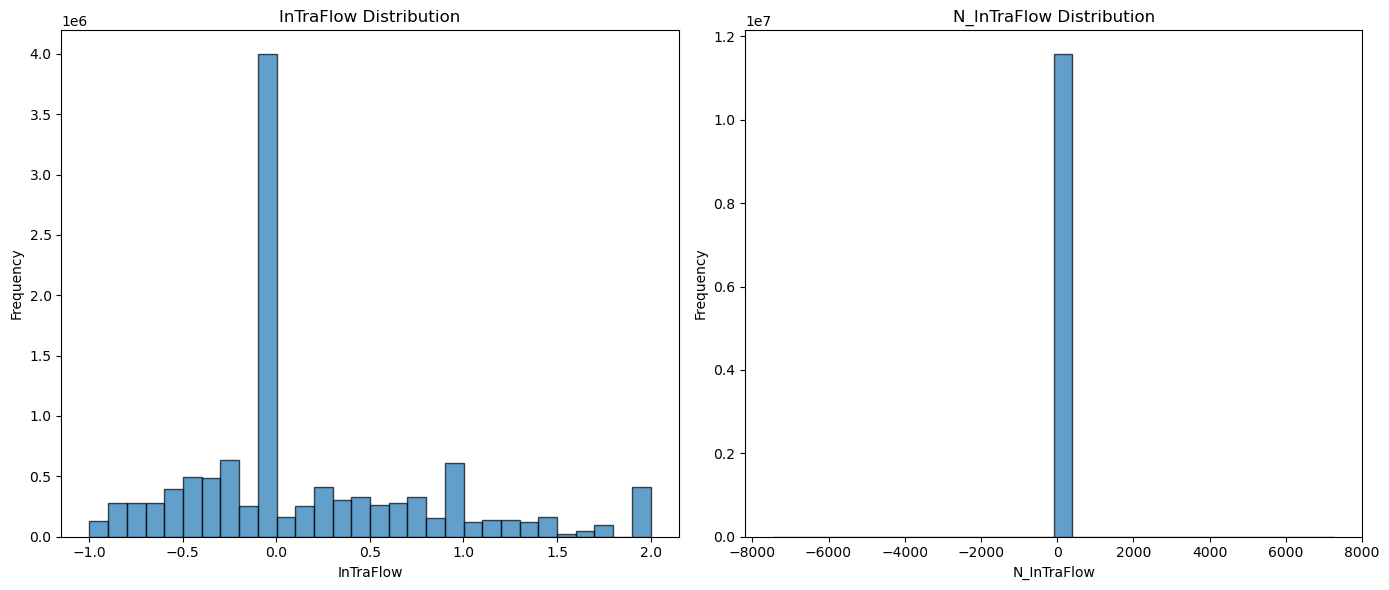

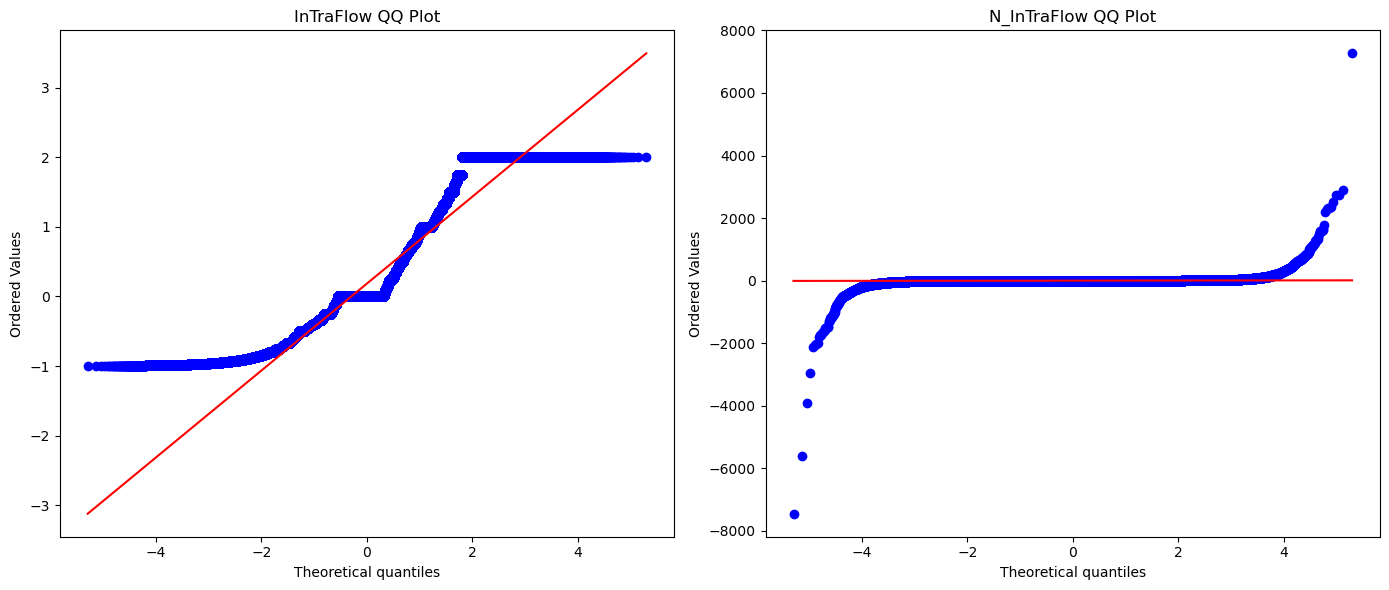

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

# 读取TSV文件
file_path = 'Merged_IMC_多字段_InTraFlow_N_InTraFlow.tsv'  # 替换为你的文件路径
data = pd.read_csv(file_path, sep='\t')

# 提取InTraFlow和N_InTraFlow字段
intraflow = data['InTraFlow']
n_intraflow = data['N_InTraFlow']

# 数据清理，移除NaN和无穷大值
intraflow = intraflow[np.isfinite(intraflow)]
n_intraflow = n_intraflow[np.isfinite(n_intraflow)]

# 绘制数据分布情况
plt.figure(figsize=(14, 6))

# InTraFlow的分布
plt.subplot(1, 2, 1)
plt.hist(intraflow, bins=30, edgecolor='black', alpha=0.7)
plt.title('InTraFlow Distribution')
plt.xlabel('InTraFlow')
plt.ylabel('Frequency')

# N_InTraFlow的分布
plt.subplot(1, 2, 2)
plt.hist(n_intraflow, bins=30, edgecolor='black', alpha=0.7)
plt.title('N_InTraFlow Distribution')
plt.xlabel('N_InTraFlow')
plt.ylabel('Frequency')

# 显示分布图
plt.tight_layout()
plt.show()

# 绘制QQ图
plt.figure(figsize=(14, 6))

# InTraFlow的QQ图
plt.subplot(1, 2, 1)
stats.probplot(intraflow, dist="norm", plot=plt)
plt.title('InTraFlow QQ Plot')

# N_InTraFlow的QQ图
plt.subplot(1, 2, 2)
stats.probplot(n_intraflow, dist="norm", plot=plt)
plt.title('N_InTraFlow QQ Plot')

# 显示QQ图
plt.tight_layout()
plt.show()


count    1.161332e+07
mean              inf
std               NaN
min     -7.452790e+03
25%     -8.459716e-02
50%      0.000000e+00
75%      2.068098e-01
max               inf
Name: N_InTraFlow, dtype: float64


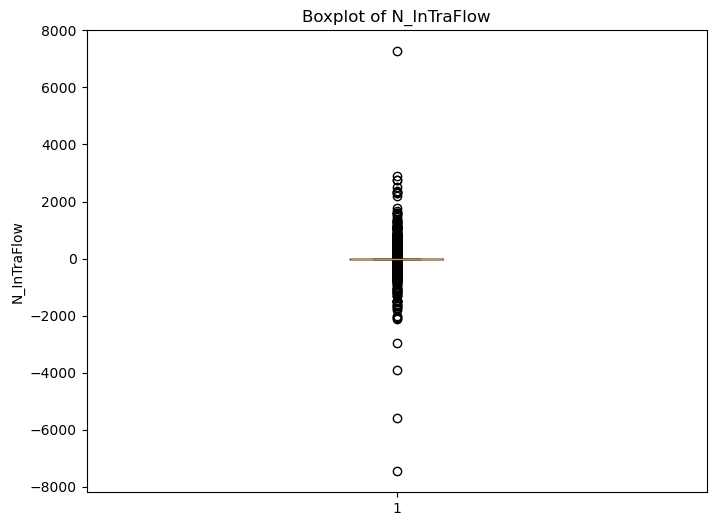

In [5]:
# 查看N_InTraFlow字段的基本统计信息
print(data['N_InTraFlow'].describe())

# 画出数据的箱形图，以便检测异常值
plt.figure(figsize=(8, 6))
plt.boxplot(data['N_InTraFlow'].dropna())
plt.title('Boxplot of N_InTraFlow')
plt.ylabel('N_InTraFlow')
plt.show()


count    1.156943e+07
mean     7.912248e-02
std      7.322907e+00
min     -7.452790e+03
25%     -8.477602e-02
50%      0.000000e+00
75%      2.013384e-01
max      7.266723e+03
Name: N_InTraFlow, dtype: float64


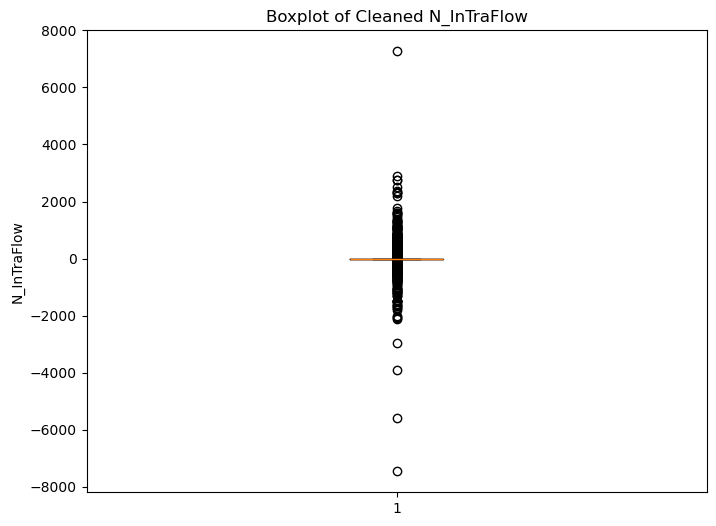

In [6]:
# 移除N_InTraFlow中的inf和NaN值
cleaned_n_intraflow = data['N_InTraFlow'].replace([np.inf, -np.inf], np.nan).dropna()

# 重新统计清理后的数据
print(cleaned_n_intraflow.describe())

# 绘制箱形图以查看清理后的数据分布
plt.figure(figsize=(8, 6))
plt.boxplot(cleaned_n_intraflow)
plt.title('Boxplot of Cleaned N_InTraFlow')
plt.ylabel('N_InTraFlow')
plt.show()


C:\Users\Administrator\AppData\Local\Temp\ipykernel_28604\1568316129.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cleaned_n_intraflow, shade=True)


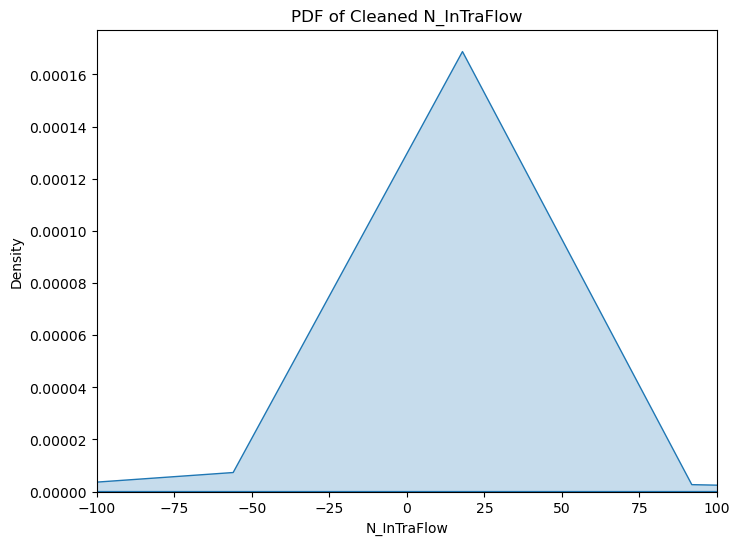

In [9]:
import seaborn as sns

# 绘制N_InTraFlow字段的PDF图（在-1到1之间）
plt.figure(figsize=(8, 6))
sns.kdeplot(cleaned_n_intraflow, shade=True)

# 设置横坐标限制在-1到1之间
plt.xlim(-100, 100)

# 添加标题和标签
plt.title('PDF of Cleaned N_InTraFlow')
plt.xlabel('N_InTraFlow')
plt.ylabel('Density')

# 显示图形
plt.show()


In [11]:
import pandas as pd
import numpy as np

# 读取源文件
file_path = 'Merged_IMC_多字段_InTraFlow_N_InTraFlow.tsv'  # 替换为你的文件路径
data = pd.read_csv(file_path, sep='\t')

# 清洗数据，去掉N_InTraFlow中的无穷大和NaN
data['N_InTraFlow'] = data['N_InTraFlow'].replace([np.inf, -np.inf], np.nan)

# 统计总行数和清洗后的空值数量
total_rows = data.shape[0]
missing_values = data['N_InTraFlow'].isna().sum()

# 打印统计信息
print(f"总行数: {total_rows}")
print(f"空值数量: {missing_values}")

# 如果你需要将空值对应的行置为空值，可以使用以下代码：
# 如果只是对`N_InTraFlow`字段为空值的行进行处理，留下空值:
data.loc[data['N_InTraFlow'].isna(), 'N_InTraFlow'] = np.nan

# 如果你需要将清洗后的数据保存为新文件，可以使用以下代码：
cleaned_file_path = 'cleaned_Merged_IMC_多字段_InTraFlow_N_InTraFlow.tsv'
data.to_csv(cleaned_file_path, sep='\t', index=False)


总行数: 11613323
空值数量: 43895


In [12]:
import pandas as pd

# 读取源文件
file_path = 'InTraFlow_Cleanned.tsv'  # 替换为你的文件路径
data = pd.read_csv(file_path, sep='\t')

# 删除'IMCp'字段
if 'IMCp' in data.columns:
    data = data.drop(columns=['IMCp'])
    print("'IMCp'字段已删除。")
else:
    print("'IMCp'字段不存在。")

# 保存删除字段后的文件
cleaned_file_path = 'cleaned_Merged_IMC_多字段_InTraFlow_N_InTraFlow.tsv'  # 设置保存的新文件路径
data.to_csv(cleaned_file_path, sep='\t', index=False)

print(f"修改后的文件已保存为: {cleaned_file_path}")


'IMCp'字段已删除。
修改后的文件已保存为: cleaned_Merged_IMC_多字段_InTraFlow_N_InTraFlow.tsv


In [ ]:
import pandas as pd

# 读取源文件
file_path = 'InTraFlow_Cleanned.tsv'  # 替换为你的文件路径
data = pd.read_csv(file_path, sep='\t')

# 删除'IMCp'字段
if 'IMCp' in data.columns:
    data = data.drop(columns=['IMCp'])
    print("'IMCp'字段已删除。")
else:
    print("'IMCp'字段不存在。")

# 保存删除字段后的文件
cleaned_file_path = 'cleaned_Merged_IMC_多字段_InTraFlow_N_InTraFlow.tsv'  # 设置保存的新文件路径
data.to_csv(cleaned_file_path, sep='\t', index=False)

print(f"修改后的文件已保存为: {cleaned_file_path}")

In [1]:
import pandas as pd
import time
import os

# 开始计时
start_time = time.time()

# 文件路径
file1_path = "Cleaned_InTraFlow.tsv"  # 原始文件
file2_path = "SciSciNet_Papers.tsv"  # 大文件 (16.3GB)
output_path = "Merged_Cleaned_InTraFlow.tsv"  # 输出文件

print(f"开始合并操作...")

try:
    # 读取较小的文件
    print(f"读取较小的文件...")
    df_small = pd.read_csv(file1_path, sep='\t')
    
    print(f"小文件读取完成。形状: {df_small.shape}")
    
    # 验证PaperID在第二列
    columns = df_small.columns.tolist()
    if len(columns) >= 2:
        print(f"第二列: {columns[1]}")
    
    # 创建PaperID集合用于快速查找
    paper_ids = set(df_small['PaperID'].unique())
    
    print(f"从小文件中提取了 {len(paper_ids)} 个唯一PaperID")
    
    # 初始化DataFrame存储大文件中匹配的记录
    large_columns = ['PaperID', 'Patent_Count', 'NIH_Count', 'NSF_Count']
    df_matches = pd.DataFrame(columns=large_columns)
    
    # 分块处理大文件
    print(f"以分块方式处理大文件...")
    
    chunk_size = 1000000  # 根据可用内存调整
    chunks_read = 0
    total_matches = 0
    paper_ids_to_find = paper_ids.copy()  # 创建副本用于跟踪
    
    # 读取并处理大文件
    for chunk in pd.read_csv(file2_path, sep='\t', 
                          usecols=large_columns,
                          chunksize=chunk_size):
        chunks_read += 1
        if chunks_read % 10 == 0:
            print(f"已处理 {chunks_read} 个分块，找到 {total_matches} 条匹配记录...")
            print(f"还剩 {len(paper_ids_to_find)} 个PaperID未匹配")
        
        # 过滤匹配的PaperID
        matches = chunk[chunk['PaperID'].isin(paper_ids_to_find)]
        total_matches += len(matches)
        
        # 添加到匹配集合
        df_matches = pd.concat([df_matches, matches])
        
        # 从待查找集合中移除已匹配ID
        matched_ids = set(matches['PaperID'])
        paper_ids_to_find -= matched_ids
        
        # 如果已找到所有ID，停止处理
        if len(paper_ids_to_find) == 0:
            print(f"已找到所有匹配的PaperID，停止处理")
            break
    
    print(f"大文件处理完成。找到 {total_matches} 条匹配记录。")
    
    # 执行合并
    print(f"合并数据帧...")
    df_merged = pd.merge(df_small, df_matches, on='PaperID', how='left')
    
    print(f"合并完成。合并后数据的形状: {df_merged.shape}")
    
    # 保存合并后的数据
    print(f"保存合并后的数据...")
    df_merged.to_csv(output_path, sep='\t', index=False)
    
    print(f"数据已成功保存到 {output_path}")
    
    # 计算并显示总运行时间
    elapsed_time = time.time() - start_time
    print(f"总执行时间: {elapsed_time:.2f} 秒")

except Exception as e:
    print(f"发生错误: {str(e)}")

开始合并操作...
读取较小的文件...
小文件读取完成。形状: (11613323, 15)
第二列: PaperID
从小文件中提取了 11613323 个唯一PaperID
以分块方式处理大文件...
已处理 10 个分块，找到 779799 条匹配记录...
还剩 10833524 个PaperID未匹配
已处理 20 个分块，找到 1645605 条匹配记录...
还剩 9967718 个PaperID未匹配
已处理 30 个分块，找到 2512650 条匹配记录...
还剩 9100673 个PaperID未匹配
已处理 40 个分块，找到 3377434 条匹配记录...
还剩 8235889 个PaperID未匹配
已处理 50 个分块，找到 4244098 条匹配记录...
还剩 7369225 个PaperID未匹配
已处理 60 个分块，找到 5108397 条匹配记录...
还剩 6504926 个PaperID未匹配
已处理 70 个分块，找到 5973844 条匹配记录...
还剩 5639479 个PaperID未匹配
已处理 80 个分块，找到 6840381 条匹配记录...
还剩 4772942 个PaperID未匹配
已处理 90 个分块，找到 7706442 条匹配记录...
还剩 3906881 个PaperID未匹配
已处理 100 个分块，找到 8573283 条匹配记录...
还剩 3040040 个PaperID未匹配
已处理 110 个分块，找到 9440767 条匹配记录...
还剩 2172556 个PaperID未匹配
已处理 120 个分块，找到 10305154 条匹配记录...
还剩 1308169 个PaperID未匹配
已处理 130 个分块，找到 11170635 条匹配记录...
还剩 442688 个PaperID未匹配
已找到所有匹配的PaperID，停止处理
大文件处理完成。找到 11613323 条匹配记录。
合并数据帧...
合并完成。合并后数据的形状: (11613323, 18)
保存合并后的数据...
数据已成功保存到 Merged_Cleaned_InTraFlow.tsv
总执行时间: 349.96 秒


In [2]:
import csv

def analyze_tsv_file(file_path):
    """
    分析 TSV 文件，统计每个字段的行数、空值和 NaN 值。

    Args:
        file_path (str): TSV 文件的路径。
    """

    try:
        with open(file_path, 'r', encoding='utf-8') as tsvfile:
            reader = csv.reader(tsvfile, delimiter='\t')
            header = next(reader, None)  # 读取 header 行

            if not header:
                print(f"错误: 文件 '{file_path}' 没有 header 行或为空文件。")
                return

            column_data = {field: [] for field in header} # 使用字典存储每列的数据

            for row in reader:
                for i, value in enumerate(row):
                    if i < len(header): # 确保列索引在 header 范围内
                        column_data[header[i]].append(value.strip()) # 去除值两端空格

            print(f"文件 '{file_path}' 分析报告:\n")

            for field in header:
                values = column_data[field]
                total_rows = len(values)
                empty_count = values.count('')
                nan_count = values.count('NaN') if field == 'InTraFlowf' else 0 # 只对 InTraFlowf 列统计 NaN

                print(f"字段: '{field}'")
                print(f"  总行数 (不含 header): {total_rows}")
                print(f"  空值 (空字符串) 数量: {empty_count}")
                if field == 'InTraFlowf':
                    print(f"  NaN 值 数量: {nan_count}") # 只在 InTraFlowf 列显示 NaN 计数
                print("-" * 30)

    except FileNotFoundError:
        print(f"错误: 文件 '{file_path}' 未找到，请检查文件路径。")
    except Exception as e:
        print(f"读取文件 '{file_path}' 时发生错误: {e}")


# 定义要分析的文件路径
file_path_to_analyze = "Merged_Cleaned_InTraFlow.tsv" # 替换为您要分析的文件路径
analyze_tsv_file(file_path_to_analyze)

文件 'Merged_Cleaned_InTraFlow.tsv' 分析报告:

字段: 'FieldID'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 0
------------------------------
字段: 'PaperID'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 0
------------------------------
字段: 'C_f'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 3
------------------------------
字段: 'Year'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 3
------------------------------
字段: 'Citation_Count'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 0
------------------------------
字段: 'C10'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 5924481
------------------------------
字段: 'C5'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 3085294
------------------------------
字段: 'Team_size'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 167
------------------------------
字段: 'Disruption'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 4711622
------------------------------
字段: 'Atyp_Median_Z'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 7816176
------------------------------
字段: 'SB_B'
  总行数 (不含 

In [3]:
import pandas as pd

def calculate_fund_and_drop_counts(input_file_path, output_file_path):
    """
    计算 'Fund' 字段 (NIH_Count + NSF_Count) 并删除 'NIH_Count' 和 'NSF_Count' 列。

    Args:
        input_file_path (str): 输入 TSV 文件路径 (Merged_Cleaned_InTraFlow.tsv).
        output_file_path (str): 输出 TSV 文件路径 (例如 Merged_Cleaned_InTraFlow_Fund.tsv).
    """

    try:
        # 读取 Merged_Cleaned_InTraFlow.tsv 文件
        df = pd.read_csv(input_file_path, sep='\t', low_memory=False)

        # 检查 'NIH_Count' 和 'NSF_Count' 列是否存在
        if 'NIH_Count' not in df.columns or 'NSF_Count' not in df.columns:
            print(f"错误: 文件 '{input_file_path}' 缺少 'NIH_Count' 或 'NSF_Count' 列，请检查文件。")
            return

        # 将 'NIH_Count' 和 'NSF_Count' 列转换为数值类型，并将无法转换的值转换为 NaN
        df['NIH_Count'] = pd.to_numeric(df['NIH_Count'], errors='coerce')
        df['NSF_Count'] = pd.to_numeric(df['NSF_Count'], errors='coerce')

        # 使用 fillna(0) 将 NaN 值替换为 0，然后计算 'Fund' 列
        df['Fund'] = df['NIH_Count'].fillna(0) + df['NSF_Count'].fillna(0)

        # 删除 'NIH_Count' 和 'NSF_Count' 列
        df.drop(columns=['NIH_Count', 'NSF_Count'], inplace=True)

        # 保存修改后的 DataFrame 到新的 TSV 文件
        df.to_csv(output_file_path, sep='\t', index=False)

        print(f"已成功计算 'Fund' 字段并删除 'NIH_Count' 和 'NSF_Count' 列。")
        print(f"结果已保存到 {output_file_path}")

    except FileNotFoundError:
        print(f"错误: 文件 '{input_file_path}' 未找到，请检查文件路径。")
    except Exception as e:
        print(f"处理文件时发生错误: {e}")
        print(e)


# 定义输入和输出文件路径
input_file_path = "Merged_Cleaned_InTraFlow.tsv"  # 修改为你的 Merged_Cleaned_InTraFlow.tsv 文件路径
output_file_path = "Merged_Cleaned_InTraFlow_Fund.tsv" # 输出文件路径

# 调用函数执行计算和删除列操作
calculate_fund_and_drop_counts(input_file_path, output_file_path)

已成功计算 'Fund' 字段并删除 'NIH_Count' 和 'NSF_Count' 列。
结果已保存到 Merged_Cleaned_InTraFlow_Fund.tsv


In [4]:
import pandas as pd

def create_field_dummies(input_file_path, output_file_path):
    """
    根据 FieldID 列创建 Field_CS, Field_Eng, Field_Eco 三个学科哑变量。

    Args:
        input_file_path (str): 输入 TSV 文件路径 (Merged_Cleaned_InTraFlow_Fund.tsv).
        output_file_path (str): 输出 TSV 文件路径 (例如 Merged_Cleaned_InTraFlow_Fund_Dummies.tsv).
    """

    try:
        # 读取 Merged_Cleaned_InTraFlow_Fund.tsv 文件
        df = pd.read_csv(input_file_path, sep='\t', low_memory=False)

        # 目标 FieldID 和对应的哑变量列名
        field_targets = {
            41008148: 'Field_CS',
            127413603: 'Field_Eng',
            162324750: 'Field_Eco'
        }

        # 创建新的哑变量列，并初始化为 0
        for field_name in field_targets.values():
            df[field_name] = 0

        # 遍历 DataFrame 的每一行
        for index, row in df.iterrows():
            field_id_value = row['FieldID'] # 获取 FieldID 值

            # 检查 FieldID 是否匹配任何目标学科 ID
            for target_field_id, dummy_column_name in field_targets.items():
                # 考虑到 FieldID 可能是浮点数或整数，进行类型转换后比较
                if pd.notna(field_id_value) and float(field_id_value) == float(target_field_id):
                    df.at[index, dummy_column_name] = 1 # 设置对应的哑变量列为 1
                    break # 如果匹配到一个学科，则跳出内层循环

        # 保存修改后的 DataFrame 到新的 TSV 文件
        df.to_csv(output_file_path, sep='\t', index=False)

        print(f"已成功创建 Field_CS, Field_Eng, Field_Eco 哑变量。")
        print(f"结果已保存到 {output_file_path}")

    except FileNotFoundError:
        print(f"错误: 文件 '{input_file_path}' 未找到，请检查文件路径。")
    except KeyError:
        print(f"错误: 文件 '{input_file_path}' 缺少 'FieldID' 列，请检查文件结构。")
    except Exception as e:
        print(f"处理文件时发生错误: {e}")
        print(e)


# 定义输入和输出文件路径
input_file_path = "Merged_Cleaned_InTraFlow_Fund.tsv"  # 修改为你的 Merged_Cleaned_InTraFlow_Fund.tsv 文件路径
output_file_path = "Merged_Cleaned_InTraFlow_Fund_Dummies.tsv" # 输出文件路径

# 调用函数执行创建哑变量操作
create_field_dummies(input_file_path, output_file_path)

已成功创建 Field_CS, Field_Eng, Field_Eco 哑变量。
结果已保存到 Merged_Cleaned_InTraFlow_Fund_Dummies.tsv


In [5]:
import pandas as pd
import numpy as np

def calculate_log_transformations(input_file_path, output_file_path, columns_to_log):
    """
    对指定的列进行对数 (自然对数) 转换，并生成新的变量。

    Args:
        input_file_path (str): 输入 TSV 文件路径 (Merged_Cleaned_InTraFlow_Fund_Dummies.tsv).
        output_file_path (str): 输出 TSV 文件路径 (例如 Merged_Cleaned_InTraFlow_Fund_Dummies_Log.tsv).
        columns_to_log (list): 需要进行对数转换的列名列表.
    """

    try:
        # 读取 TSV 文件
        df = pd.read_csv(input_file_path, sep='\t', low_memory=False)

        for column in columns_to_log:
            if column not in df.columns:
                print(f"警告: 列 '{column}' 未在文件中找到，跳过对数转换。")
                continue

            # 将列转换为数值类型，并将无法转换的值转换为 NaN
            df[column] = pd.to_numeric(df[column], errors='coerce')

            # 应用对数 (自然对数) 转换，使用 log1p 处理 0 值和负数
            log_column_name = 'Log_' + column  # 新的对数转换后的列名
            df[log_column_name] = np.log1p(df[column].fillna(0)) # fillna(0) to handle NaN values before log transform, log1p(x) = log(1+x)

        # 保存修改后的 DataFrame 到新的 TSV 文件
        df.to_csv(output_file_path, sep='\t', index=False)

        print(f"已成功对列 {columns_to_log} 进行对数转换，并保存到 {output_file_path}")

    except FileNotFoundError:
        print(f"错误: 文件 '{input_file_path}' 未找到，请检查文件路径。")
    except KeyError:
        print(f"错误: 文件 '{input_file_path}' 缺少指定列，请检查文件结构。")
    except Exception as e:
        print(f"处理文件时发生错误: {e}")
        print(e)


# 定义输入和输出文件路径
input_file_path = "Merged_Cleaned_InTraFlow_Fund_Dummies.tsv"  # 修改为你的输入文件路径
output_file_path = "Merged_Cleaned_InTraFlow_Fund_Dummies_Log.tsv" # 输出文件路径
columns_to_log = ['Team_size', 'C5', 'Patent_Count', 'Fund'] # 需要进行对数转换的列名列表

# 调用函数执行对数转换操作
calculate_log_transformations(input_file_path, output_file_path, columns_to_log)

已成功对列 ['Team_size', 'C5', 'Patent_Count', 'Fund'] 进行对数转换，并保存到 Merged_Cleaned_InTraFlow_Fund_Dummies_Log.tsv


In [6]:
import csv

def get_tsv_column_names(file_path):
    """
    读取 TSV 文件的 header 行并打印所有列名。

    Args:
        file_path (str): TSV 文件的路径.
    """

    try:
        with open(file_path, 'r', encoding='utf-8') as tsvfile:
            reader = csv.reader(tsvfile, delimiter='\t')
            header = next(reader, None)  # 读取第一行作为 header

            if header:
                print(f"文件 '{file_path}' 的列名:")
                for i, column_name in enumerate(header):
                    print(f"  列 {i+1}: {column_name}")
            else:
                print(f"错误: 文件 '{file_path}' 没有 header 行或为空文件。")

    except FileNotFoundError:
        print(f"错误: 文件 '{file_path}' 未找到，请检查文件路径。")
    except Exception as e:
        print(f"读取文件 '{file_path}' 时发生错误: {e}")
        print(e)


# 定义要读取列名的文件路径
file_path_to_read_columns = "Merged_Cleaned_InTraFlow.tsv" # 修改为你的新生成的文件路径

# 调用函数读取并打印列名
get_tsv_column_names(file_path_to_read_columns)

文件 'Merged_Cleaned_InTraFlow.tsv' 的列名:
  列 1: FieldID
  列 2: PaperID
  列 3: C_f
  列 4: Year
  列 5: Citation_Count
  列 6: C10
  列 7: C5
  列 8: Team_size
  列 9: Disruption
  列 10: Atyp_Median_Z
  列 11: SB_B
  列 12: SB_T
  列 13: InTraFlowf
  列 14: InTraFlow
  列 15: N_InTraFlow
  列 16: Patent_Count
  列 17: Fund
  列 18: Field_CS
  列 19: Field_Eng
  列 20: Field_Eco
  列 21: Log_Team_size
  列 22: Log_C5
  列 23: Log_Patent_Count
  列 24: Log_Fund


In [8]:
import pandas as pd
import numpy as np
import scipy.stats as stats

def calculate_and_export_correlations_descriptive(input_file_path, output_excel_path, variables):
    """
    计算指定变量之间的相关性、均值和标准差，输出到 Excel 文件，并标记相关性显著性。

    Args:
        input_file_path (str): 输入 TSV 文件路径.
        output_excel_path (str): 输出 Excel 文件路径.
        variables (list): 需要计算相关性和描述性统计的变量名列表.
    """

    try:
        # 读取 TSV 文件
        df = pd.read_csv(input_file_path, sep='\t', low_memory=False)

        # 检查变量是否存在于 DataFrame 中
        missing_variables = [var for var in variables if var not in df.columns]
        if missing_variables:
            print(f"警告: 以下变量未在文件中找到，将跳过这些变量: {missing_variables}")
            variables = [var for var in variables if var in df.columns]
            if not variables:
                print("错误: 指定的变量列表中没有找到任何有效的列名，无法计算相关性和描述性统计。")
                return

        # 提取需要计算的变量列
        data = df[variables]

        # 计算相关性矩阵 (Pearson correlation)
        correlation_matrix = data.corr(method='pearson')

        # 计算 p-value 矩阵
        p_value_matrix = pd.DataFrame(index=correlation_matrix.index, columns=correlation_matrix.columns)
        for col in correlation_matrix.columns:
            for row in correlation_matrix.index:
                if row != col: # Avoid calculating p-value for correlation of variable with itself
                    corr_val = correlation_matrix.loc[row, col]
                    if pd.notna(corr_val): # Check for NaN correlation values
                        p_value = stats.pearsonr(data[row].dropna(), data[col].dropna())[1] # Use dropna to handle potential NaNs
                        p_value_matrix.loc[row, col] = p_value
                    else:
                        p_value_matrix.loc[row, col] = np.nan
                else:
                    p_value_matrix.loc[row, col] = np.nan # No p-value for self-correlation


        # 定义显著性标记函数
        def get_significance_stars(p_value):
            if pd.isna(p_value): # Handle NaN p-values
                return ""
            if p_value < 0.001:
                return "***"
            elif p_value < 0.01:
                return "**"
            elif p_value < 0.05:
                return "*"
            else:
                return ""

        # 应用显著性标记到相关性矩阵
        correlation_matrix_with_stars = correlation_matrix.copy()
        for col in correlation_matrix.columns:
            for row in correlation_matrix.index:
                if row != col:
                    p_val = p_value_matrix.loc[row, col]
                    stars = get_significance_stars(p_val)
                    correlation_matrix_with_stars.loc[row, col] = f"{correlation_matrix.loc[row, col]:.2f}{stars}" # Format to 2 decimal places

        # 计算均值和标准差
        descriptive_stats = pd.DataFrame({
            'Mean': data.mean(),
            'Standard Deviation': data.std()
        })

        # 将结果输出到 Excel 文件
        with pd.ExcelWriter(output_excel_path, engine='xlsxwriter') as writer:
            correlation_matrix_with_stars.to_excel(writer, sheet_name='Correlation Matrix', index=True)
            correlation_matrix.to_excel(writer, sheet_name='Correlation Values (Raw)', index=True)
            p_value_matrix.to_excel(writer, sheet_name='P-Values', index=True)
            descriptive_stats.to_excel(writer, sheet_name='Descriptive Statistics', index=True) # 添加描述性统计到新的 sheet

        print(f"已成功计算变量相关性、均值和标准差，并输出到 Excel 文件: {output_excel_path}")

    except FileNotFoundError:
        print(f"错误: 文件 '{input_file_path}' 未找到，请检查文件路径。")
    except KeyError:
        print(f"错误: 文件 '{input_file_path}' 缺少指定列，请检查文件结构。")
    except Exception as e:
        print(f"处理文件时发生错误: {e}")
        print(e)


# 定义文件路径和变量列表
input_file_path = "Merged_Cleaned_InTraFlow.tsv"  # 修改为你的输入文件路径
output_excel_path = "Correlation_Matrix_Descriptive.xlsx" # 输出 Excel 文件路径 (修改了输出文件名)
variables_to_correlate_descriptive = [
    'InTraFlow', 'N_InTraFlow', 'Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T',
    'Team_size', 'Log_C5', 'Log_Patent_Count', 'Log_Fund', 'Field_CS', 'Field_Eng', 'Field_Eco'
]

# 调用函数计算相关性、描述性统计并输出到 Excel
calculate_and_export_correlations_descriptive(input_file_path, output_excel_path, variables_to_correlate_descriptive)

处理文件时发生错误: x and y must have the same length.
x and y must have the same length.


In [15]:
import pandas as pd
import numpy as np
import scipy.stats as stats

def calculate_correlations_descriptive_complete_cases_corrected_excel_sheet_names(input_file_path, output_excel_path, variables):
    """
    计算指定变量的 complete case 相关性、均值和标准差，输出到 Excel 文件，并标记相关性显著性.
    Uses only rows where ALL specified variables have non-missing values (complete cases).
    Corrected version to handle FutureWarning and Excel sheet name length limit.

    Args:
        input_file_path (str): 输入 TSV 文件路径.
        output_excel_path (str): 输出 Excel 文件路径.
        variables (list): 需要计算相关性和描述性统计的变量名列表.
    """

    try:
        # 读取 TSV 文件
        df = pd.read_csv(input_file_path, sep='\t', low_memory=False)

        # 检查变量是否存在于 DataFrame 中
        missing_variables = [var for var in variables if var not in df.columns]
        if missing_variables:
            print(f"警告: 以下变量未在文件中找到，将跳过这些变量: {missing_variables}")
            variables = [var for var in variables if var in df.columns]
            if not variables:
                print("错误: 指定的变量列表中没有找到任何有效的列名，无法计算相关性和描述性统计。")
                return

        # 提取需要计算的变量列
        data = df[variables].copy()

        # Convert all relevant columns to numeric, coercing errors to NaN
        for var in variables:
            data[var] = pd.to_numeric(data[var], errors='coerce')

        # Filter out rows where ANY of the specified variables are NaN (complete case analysis)
        complete_data = data.dropna(subset=variables)

        print(f"分析基于 Complete Cases: 符合所有变量均非空值的行数: {len(complete_data)}")

        if complete_data.empty:
            print("警告: 没有 Complete Cases (所有指定变量均非空的行)，无法计算相关性和描述性统计。")
            return

        # 计算相关性矩阵 (Pearson correlation) on complete cases
        correlation_matrix = complete_data.corr(method='pearson')

        # 计算 p-value 矩阵 on complete cases
        p_value_matrix = pd.DataFrame(index=correlation_matrix.index, columns=correlation_matrix.columns)
        for col in correlation_matrix.columns:
            for row in correlation_matrix.index:
                if row != col: # Avoid calculating p-value for correlation of variable with itself
                    corr_val = correlation_matrix.loc[row, col]
                    if pd.notna(corr_val): # Check for NaN correlation values
                        series_x = complete_data[row].dropna() # dropna here is redundant as complete_data is already dropna, but kept for consistency
                        series_y = complete_data[col].dropna() # dropna here is redundant as complete_data is already dropna, but kept for consistency

                        if len(series_x) == len(series_y) and len(series_x) > 0:
                            try:
                                p_value = stats.pearsonr(series_x, series_y)[1]
                                p_value_matrix.loc[row, col] = p_value
                            except ValueError as ve:
                                print(f"警告: ValueError in pearsonr for '{row}' and '{col}': {ve}. Setting p-value to NaN.")
                                p_value_matrix.loc[row, col] = np.nan
                            except Exception as e:
                                print(f"警告: Unexpected error in pearsonr for '{row}' and '{col}': {e}. Setting p-value to NaN.")
                                p_value_matrix.loc[row, col] = np.nan
                        else:
                            print(f"警告: 变量 '{row}' 和 '{col}' 在Complete Cases中去除 NaN 值后长度不一致 或 为空，跳过 p-value 计算。")
                            p_value_matrix.loc[row, col] = np.nan
                    else:
                        p_value_matrix.loc[row, col] = np.nan
                else:
                    p_value_matrix.loc[row, col] = np.nan # No p-value for self-correlation

        # 定义显著性标记函数 (no change needed)
        def get_significance_stars(p_value):
            if pd.isna(p_value): # Handle NaN p-values
                return ""
            if p_value < 0.001:
                return "***"
            elif p_value < 0.01:
                return "**"
            elif p_value < 0.05:
                return "*"
            else:
                return ""

        # 应用显著性标记到相关性矩阵
        correlation_matrix_with_stars = correlation_matrix.copy().astype(str) # Explicitly cast to string type HERE
        for col in correlation_matrix.columns:
            for row in correlation_matrix.index:
                if row != col:
                    p_val = p_value_matrix.loc[row, col]
                    stars = get_significance_stars(p_val)
                    correlation_matrix_with_stars.loc[row, col] = f"{correlation_matrix.loc[row, col]:.2f}{stars}" # Format to 2 decimal places

        # 计算均值和标准差 on complete cases (no change needed)
        descriptive_stats = pd.DataFrame({
            'Mean': complete_data.mean(),
            'Standard Deviation': complete_data.std()
        })

        # 将结果输出到 Excel 文件 (Sheet names shortened to be <= 31 chars)
        with pd.ExcelWriter(output_excel_path, engine='xlsxwriter') as writer:
            correlation_matrix_with_stars.to_excel(writer, sheet_name='Corr Matrix (Complete)', index=True) # Shortened sheet name
            correlation_matrix.to_excel(writer, sheet_name='Corr Values (Complete)', index=True) # Shortened sheet name
            p_value_matrix.to_excel(writer, sheet_name='P-Values (Complete)', index=True) # Shortened sheet name
            descriptive_stats.to_excel(writer, sheet_name='Descriptive Stats (Complete)', index=True) # Shortened sheet name

        print(f"已成功计算 Complete Case 变量相关性、均值和标准差，并输出到 Excel 文件: {output_excel_path}")

    except FileNotFoundError:
        print(f"错误: 文件 '{input_file_path}' 未找到，请检查文件路径。")
    except KeyError:
        print(f"错误: 文件 '{input_file_path}' 缺少指定列，请检查文件结构。")
    except Exception as e:
        print(f"处理文件时发生错误: {e}")
        print(e)


# 定义文件路径和变量列表 (no change needed)
input_file_path = "Merged_Cleaned_InTraFlow.tsv"  # 修改为你的输入文件路径
output_excel_path = "Correlation_Matrix_Descriptive_CompleteCases_2.xlsx" # 输出 Excel 文件路径 (修改了输出文件名)
variables_to_correlate_descriptive_complete_cases = [
    'InTraFlow', 'N_InTraFlow', 'Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T',
    'Log_Team_size', 'Log_C5', 'Log_Patent_Count', 'Log_Fund', 'Field_CS', 'Field_Eng', 'Field_Eco'
]

# 调用函数计算相关性、描述性统计并输出到 Excel (no change needed)
calculate_correlations_descriptive_complete_cases_corrected_excel_sheet_names(input_file_path, output_excel_path, variables_to_correlate_descriptive_complete_cases)

分析基于 Complete Cases: 符合所有变量均非空值的行数: 3012743
已成功计算 Complete Case 变量相关性、均值和标准差，并输出到 Excel 文件: Correlation_Matrix_Descriptive_CompleteCases_2.xlsx


In [17]:
import pandas as pd
import statsmodels.formula.api as smf

def perform_ols_regressions_and_export(input_file_path, output_excel_path):
    """
    执行 5 个 OLS 回归模型，并将结果输出到 Excel 文件。

    Model1：Disruption ~ InTraFlow + Log_Team_size + Log_Patent_Count + Log_Fund + Field_CS + Field_Eng + Field_Eco
    Model2：Atyp_Median_Z ~ InTraFlow + Log_Team_size + Log_Patent_Count + Log_Fund + Field_CS + Field_Eng + Field_Eco
    Model3：SB_B ~ InTraFlow + Log_Team_size + Log_Patent_Count + Log_Fund + Field_CS + Field_Eng + Field_Eco
    Model4：SB_T ~ InTraFlow + Log_Team_size + Log_Patent_Count + Log_Fund + Field_CS + Field_Eng + Field_Eco
    Model5：Log_C5 ~ InTraFlow + Log_Team_size + Log_Patent_Count + Log_Fund + Field_CS + Field_Eng + Field_Eco

    Args:
        input_file_path (str): 输入 TSV 文件路径.
        output_excel_path (str): 输出 Excel 文件路径.
    """

    try:
        # 读取 TSV 文件
        df = pd.read_csv(input_file_path, sep='\t', low_memory=False)

        # 定义因变量和自变量
        dependent_variables = ['Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T', 'Log_C5']
        independent_variables = ['InTraFlow', 'Log_Team_size', 'Log_Patent_Count', 'Log_Fund', 'Field_CS', 'Field_Eng', 'Field_Eco']

        results_dict = {} # 用于存储每个模型的回归结果

        for model_num, dep_var in enumerate(dependent_variables, 1):
            model_name = f'Model {model_num}'
            formula = f"{dep_var} ~ {' + '.join(independent_variables)}"

            try:
                model = smf.ols(formula, data=df).fit(robust='HC1') # 使用稳健标准误 (HC1)
                results_summary = model.summary()
                params = model.params
                bse = model.bse
                pvalues = model.pvalues
                nobs = model.nobs
                rsquared_adj = model.rsquared_adj

                model_results = {}
                for var in independent_variables + ['Intercept']: # Include Intercept for constant term
                    if var == 'Intercept':
                        var_name = 'Constant' # Rename Intercept to Constant for output
                    else:
                        var_name = var

                    if var_name in params: # Check if variable exists in model results
                        coef = params[var_name]
                        se = bse[var_name]
                        p_val = pvalues[var_name]

                        stars = ''
                        if p_val < 0.001:
                            stars = '***'
                        elif p_val < 0.01:
                            stars = '**'
                        elif p_val < 0.05:
                            stars = '*'

                        model_results[var_name] = {
                            'Coefficient': f'{coef:.4f}{stars}',
                            'Std. Error': f'({se:.4f})',
                            'P-value': f'{p_val:.4f}' # Keep p-value for potential further use if needed
                        }
                    else: # Handle cases where a variable might be dropped due to collinearity etc.
                        model_results[var_name] = {
                            'Coefficient': 'NA',
                            'Std. Error': 'NA',
                            'P-value': 'NA'
                        }


                model_output = pd.DataFrame(model_results).T # Transpose to have variables as rows
                model_output.insert(0, 'Variables', model_output.index) # Add Variables column
                model_output = model_output.reset_index(drop=True) # Reset index

                # 添加 N 和 Adjusted R-squared
                n_row = pd.DataFrame([{'Variables': 'N', 'Coefficient': f'{int(nobs):,}', 'Std. Error': '', 'P-value': ''}]) # Format N with comma separator
                r2_adj_row = pd.DataFrame([{'Variables': 'Adjusted R²', 'Coefficient': f'{rsquared_adj:.3f}', 'Std. Error': '', 'P-value': ''}])

                model_output = pd.concat([model_output, n_row, r2_adj_row], ignore_index=True)

                results_dict[model_name] = model_output

            except Exception as e:
                print(f"执行 {model_name} 回归时发生错误: {e}")
                results_dict[model_name] = pd.DataFrame([{'Variables': 'Error', 'Coefficient': str(e), 'Std. Error': '', 'P-value': ''}], index=[0]) # Output error message


        # 输出到 Excel
        with pd.ExcelWriter(output_excel_path, engine='xlsxwriter') as writer:
            for model_name, result_df in results_dict.items():
                result_df.to_excel(writer, sheet_name=model_name, index=False) # 每个模型一个 sheet

        print(f"OLS 回归结果已成功输出到 Excel 文件: {output_excel_path}")

    except FileNotFoundError:
        print(f"错误: 文件 '{input_file_path}' 未找到，请检查文件路径。")
    except KeyError as e:
        print(f"错误: 文件 '{input_file_path}' 缺少列: {e}, 请检查文件结构。")
    except Exception as e:
        print(f"处理文件时发生错误: {e}")
        print(e)


# 定义文件路径
input_file_path = "Merged_Cleaned_InTraFlow.tsv"  # 修改为你的输入文件路径
output_excel_path = "OLS_Regression_Results.xlsx" # 输出 Excel 文件路径

# 调用函数执行 OLS 回归并输出结果
perform_ols_regressions_and_export(input_file_path, output_excel_path)

执行 Model 1 回归时发生错误: exog contains inf or nans
执行 Model 2 回归时发生错误: exog contains inf or nans
执行 Model 3 回归时发生错误: exog contains inf or nans
执行 Model 4 回归时发生错误: exog contains inf or nans
执行 Model 5 回归时发生错误: exog contains inf or nans
OLS 回归结果已成功输出到 Excel 文件: OLS_Regression_Results.xlsx


In [19]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np  # 导入 numpy 用于处理 NaN/inf 检查

def perform_ols_regressions_and_export_corrected_nan_inf_zh(input_file_path, output_excel_path):
    """
    执行 5 个 OLS 回归模型，并将结果输出到 Excel 文件。
    **修改说明：** 修正版本，通过移除相关变量中包含 NaN 或 inf 值的行来处理 "exog contains inf or nans" 错误。

    Model1：Disruption ~ InTraFlow + Log_Team_size + Log_Patent_Count + Log_Fund + Field_CS + Field_Eng + Field_Eco
    Model2：Atyp_Median_Z ~ InTraFlow + Log_Team_size + Log_Patent_Count + Log_Fund + Field_CS + Field_Eng + Field_Eco
    Model3：SB_B ~ InTraFlow + Log_Team_size + Log_Patent_Count + Log_Fund + Field_CS + Field_Eng + Field_Eco
    Model4：SB_T ~ InTraFlow + Log_Team_size + Log_Patent_Count + Log_Fund + Field_CS + Field_Eng + Field_Eco
    Model5：Log_C5 ~ InTraFlow + Log_Team_size + Log_Patent_Count + Log_Fund + Field_CS + Field_Eng + Field_Eco

    Args:
        input_file_path (str): 输入 TSV 文件路径.
        output_excel_path (str): 输出 Excel 文件路径.
    """

    try:
        # 读取 TSV 文件
        df = pd.read_csv(input_file_path, sep='\t', low_memory=False)

        # 定义因变量和自变量
        dependent_variables = ['Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T', 'Log_C5']
        independent_variables = ['InTraFlow', 'Log_Team_size', 'Log_Patent_Count', 'Log_Fund', 'Field_CS', 'Field_Eng', 'Field_Eco']

        results_dict = {} # 用于存储每个模型的回归结果

        for model_num, dep_var in enumerate(dependent_variables, 1):
            model_name = f'模型 {model_num}' # 修改为中文模型名
            formula = f"{dep_var} ~ {' + '.join(independent_variables)}"

            # 准备模型数据，去除 NaN 和 inf 行
            model_vars = [dep_var] + independent_variables
            model_data = df[model_vars].replace([np.inf, -np.inf], np.nan).dropna() # 先用 NaN 替换 inf，然后删除 NaN 行

            print(f"模型 {model_num}: 移除 NaN/Inf 值后，分析 {len(model_data)} 行数据。") # 修改为中文输出

            try:
                model = smf.ols(formula, data=model_data).fit(robust='HC1') # 使用稳健标准误 (HC1)
                results_summary = model.summary()
                params = model.params
                bse = model.bse
                pvalues = model.pvalues
                nobs = model.nobs
                rsquared_adj = model.rsquared_adj

                model_results = {}
                for var in independent_variables + ['Intercept']: # 包括截距项作为常数项
                    if var == 'Intercept':
                        var_name = 'Constant' # 将 Intercept 重命名为 Constant 以便输出
                    else:
                        var_name = var

                    if var_name in params: # 检查模型结果中是否存在变量
                        coef = params[var_name]
                        se = bse[var_name]
                        p_val = pvalues[var_name]

                        stars = ''
                        if p_val < 0.001:
                            stars = '***'
                        elif p_val < 0.01:
                            stars = '**'
                        elif p_val < 0.05:
                            stars = '*'

                        model_results[var_name] = {
                            'Coefficient': f'{coef:.4f}{stars}',
                            'Std. Error': f'({se:.4f})',
                            'P-value': f'{p_val:.4f}' # 保留 p-value 以便后续可能使用
                        }
                    else: # 处理由于共线性等原因变量可能被删除的情况
                        model_results[var_name] = {
                            'Coefficient': 'NA',
                            'Std. Error': 'NA',
                            'P-value': 'NA'
                        }


                model_output = pd.DataFrame(model_results).T # 转置以使变量作为行
                model_output.insert(0, 'Variables', model_output.index) # 添加 Variables 列
                model_output = model_output.reset_index(drop=True) # 重置索引

                # 添加 N 和 Adjusted R-squared
                n_row = pd.DataFrame([{'Variables': 'N', 'Coefficient': f'{int(nobs):,}', 'Std. Error': '', 'P-value': ''}]) # 格式化 N，使用逗号分隔符
                r2_adj_row = pd.DataFrame([{'Variables': 'Adjusted R²', 'Coefficient': f'{rsquared_adj:.3f}', 'Std. Error': '', 'P-value': ''}])

                model_output = pd.concat([model_output, n_row, r2_adj_row], ignore_index=True)

                results_dict[model_name] = model_output

            except Exception as e:
                print(f"执行 {model_name} 回归时发生错误: {e}") # 修改为中文输出
                results_dict[model_name] = pd.DataFrame([{'Variables': 'Error', 'Coefficient': str(e), 'Std. Error': '', 'P-value': ''}], index=[0]) # 输出错误信息


        # 输出到 Excel
        with pd.ExcelWriter(output_excel_path, engine='xlsxwriter') as writer:
            for model_name, result_df in results_dict.items():
                result_df.to_excel(writer, sheet_name=model_name, index=False) # 每个模型一个 sheet，sheet 名为模型名

        print(f"OLS 回归结果已成功输出到 Excel 文件: {output_excel_path}") # 修改为中文输出

    except FileNotFoundError:
        print(f"错误: 文件 '{input_file_path}' 未找到，请检查文件路径。") # 修改为中文输出
    except KeyError as e:
        print(f"错误: 文件 '{input_file_path}' 缺少列: {e}, 请检查文件结构。") # 修改为中文输出
    except Exception as e:
        print(f"处理文件时发生错误: {e}") # 修改为中文输出
        print(e)


# 定义文件路径
input_file_path = "Merged_Cleaned_InTraFlow.tsv"  # 修改为你的输入文件路径
output_excel_path = "OLS_Regression_Results.xlsx" # 输出 Excel 文件路径

# 调用函数执行 OLS 回归并输出结果
perform_ols_regressions_and_export_corrected_nan_inf_zh(input_file_path, output_excel_path)

模型 1: 移除 NaN/Inf 值后，分析 6881165 行数据。
模型 2: 移除 NaN/Inf 值后，分析 3790718 行数据。
模型 3: 移除 NaN/Inf 值后，分析 4179612 行数据。
模型 4: 移除 NaN/Inf 值后，分析 4179612 行数据。
模型 5: 移除 NaN/Inf 值后，分析 11569428 行数据。
OLS 回归结果已成功输出到 Excel 文件: OLS_Regression_Results.xlsx


In [21]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np  # 导入 numpy 用于处理 NaN/inf 检查

def perform_ols_regressions_and_export_corrected_nan_inf_zh(input_file_path, output_excel_path):
    """
    执行 5 个 OLS 回归模型，并将结果输出到 Excel 文件。
    **修改说明：** 修正版本，通过移除相关变量中包含 NaN 或 inf 值的行来处理 "exog contains inf or nans" 错误，并**解决多重共线性问题**。
    **中文输出版本。**

    Model1：Disruption ~ InTraFlow + Log_Team_size + Log_Patent_Count + Log_Fund + Field_CS + Field_Eng  (**移除 Field_Eco**)
    Model2：Atyp_Median_Z ~ InTraFlow + Log_Team_size + Log_Patent_Count + Log_Fund + Field_CS + Field_Eng + Field_Eco
    Model3：SB_B ~ InTraFlow + Log_Team_size + Log_Patent_Count + Log_Fund + Field_CS + Field_Eng + Field_Eco
    Model4：SB_T ~ InTraFlow + Log_Team_size + Log_Patent_Count + Log_Fund + Field_CS + Field_Eng + Field_Eco
    Model5：Log_C5 ~ InTraFlow + Log_Team_size + Log_Patent_Count + Log_Fund + Field_CS + Field_Eng + Field_Eco

    Args:
        input_file_path (str): 输入 TSV 文件路径.
        output_excel_path (str): 输出 Excel 文件路径.
    """

    try:
        # 读取 TSV 文件
        df = pd.read_csv(input_file_path, sep='\t', low_memory=False)

        # 定义因变量和自变量
        dependent_variables = ['Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T', 'Log_C5']
        independent_variables_common = ['InTraFlow', 'Log_Team_size', 'Log_Patent_Count', 'Log_Fund', 'Field_CS', 'Field_Eng'] # 移除 Field_Eco，作为基准类别
        independent_variables_all_fields = independent_variables_common + ['Field_Eco'] # 包含所有学科哑变量的列表，用于 Model 2-5 (如果需要)

        results_dict = {} # 用于存储每个模型的回归结果

        for model_num, dep_var in enumerate(dependent_variables, 1):
            model_name = f'模型 {model_num}' # 修改为中文模型名
            if model_num == 1: # Model 1 公式 - 移除 Field_Eco 以解决多重共线性
                formula = f"{dep_var} ~ {' + '.join(independent_variables_common)}" # 使用移除 Field_Eco 的自变量列表
            else: # Models 2-5 - 保留所有学科哑变量 (如果需要与其他模型保持一致，但通常所有模型都应采用相同基准类别)
                formula = f"{dep_var} ~ {' + '.join(independent_variables_all_fields)}" # 使用包含所有学科哑变量的列表

            # 准备模型数据，去除 NaN 和 inf 行
            model_vars = [dep_var]
            if model_num == 1:
                model_vars.extend(independent_variables_common)
            else:
                model_vars.extend(independent_variables_all_fields)

            model_data = df[model_vars].replace([np.inf, -np.inf], np.nan).dropna() # 先用 NaN 替换 inf，然后删除 NaN 行

            print(f"模型 {model_num}: 移除 NaN/Inf 值后，分析 {len(model_data)} 行数据。") # 修改为中文输出

            try:
                model = smf.ols(formula, data=model_data).fit(robust='HC1') # 使用稳健标准误 (HC1)
                results_summary = model.summary()
                params = model.params
                bse = model.bse
                pvalues = model.pvalues
                nobs = model.nobs
                rsquared_adj = model.rsquared_adj

                model_results = {}
                independent_vars_for_output = independent_variables_common if model_num == 1 else independent_variables_all_fields # 根据模型选择自变量列表用于输出
                for var in independent_vars_for_output + ['Intercept']: # 包括截距项作为常数项
                    if var == 'Intercept':
                        var_name = 'Constant' # 将 Intercept 重命名为 Constant 以便输出
                    else:
                        var_name = var

                    if var_name in params: # 检查模型结果中是否存在变量
                        coef = params[var_name]
                        se = bse[var_name]
                        p_val = pvalues[var_name]

                        stars = ''
                        if p_val < 0.001:
                            stars = '***'
                        elif p_val < 0.01:
                            stars = '**'
                        elif p_val < 0.05:
                            stars = '*'

                        model_results[var_name] = {
                            'Coefficient': f'{coef:.4f}{stars}',
                            'Std. Error': f'({se:.4f})',
                            'P-value': f'{p_val:.4f}' # 保留 p-value 以便后续可能使用
                        }
                    else: # 处理由于共线性等原因变量可能被删除的情况
                        model_results[var_name] = {
                            'Coefficient': 'NA',
                            'Std. Error': 'NA',
                            'P-value': 'NA'
                        }


                model_output = pd.DataFrame(model_results).T # 转置以使变量作为行
                model_output.insert(0, 'Variables', model_output.index) # 添加 Variables 列
                model_output = model_output.reset_index(drop=True) # 重置索引

                # 添加 N 和 Adjusted R-squared
                n_row = pd.DataFrame([{'Variables': 'N', 'Coefficient': f'{int(nobs):,}', 'Std. Error': '', 'P-value': ''}]) # 格式化 N，使用逗号分隔符
                r2_adj_row = pd.DataFrame([{'Variables': 'Adjusted R²', 'Coefficient': f'{rsquared_adj:.3f}', 'Std. Error': '', 'P-value': ''}])

                model_output = pd.concat([model_output, n_row, r2_adj_row], ignore_index=True)

                results_dict[model_name] = model_output

            except Exception as e:
                print(f"执行 {model_name} 回归时发生错误: {e}") # 修改为中文输出
                results_dict[model_name] = pd.DataFrame([{'Variables': 'Error', 'Coefficient': str(e), 'Std. Error': '', 'P-value': ''}], index=[0]) # 输出错误信息


        # 输出到 Excel
        with pd.ExcelWriter(output_excel_path, engine='xlsxwriter') as writer:
            for model_name, result_df in results_dict.items():
                result_df.to_excel(writer, sheet_name=model_name, index=False) # 每个模型一个 sheet，sheet 名为模型名

        print(f"OLS 回归结果已成功输出到 Excel 文件: {output_excel_path}") # 修改为中文输出

    except FileNotFoundError:
        print(f"错误: 文件 '{input_file_path}' 未找到，请检查文件路径。") # 修改为中文输出
    except KeyError as e:
        print(f"错误: 文件 '{input_file_path}' 缺少列: {e}, 请检查文件结构。") # 修改为中文输出
    except Exception as e:
        print(f"处理文件时发生错误: {e}") # 修改为中文输出
        print(e)


# 定义文件路径
input_file_path = "Merged_Cleaned_InTraFlow.tsv"  # 修改为你的输入文件路径
output_excel_path = "OLS_Regression_Results.xlsx" # 输出 Excel 文件路径

# 调用函数执行 OLS 回归并输出结果
perform_ols_regressions_and_export_corrected_nan_inf_zh(input_file_path, output_excel_path)

模型 1: 移除 NaN/Inf 值后，分析 6881165 行数据。
模型 2: 移除 NaN/Inf 值后，分析 3790718 行数据。
模型 3: 移除 NaN/Inf 值后，分析 4179612 行数据。
模型 4: 移除 NaN/Inf 值后，分析 4179612 行数据。
模型 5: 移除 NaN/Inf 值后，分析 11569428 行数据。
OLS 回归结果已成功输出到 Excel 文件: OLS_Regression_Results.xlsx


In [23]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np  # 导入 numpy 用于处理 NaN/inf 检查

def perform_ols_regressions_and_export_corrected_nan_inf_zh(input_file_path, output_excel_path):
    """
    执行 5 个 OLS 回归模型，并将结果输出到 Excel 文件。
    **修改说明：** 修正版本，通过移除相关变量中包含 NaN 或 inf 值的行来处理 "exog contains inf or nans" 错误，并**解决所有模型的多重共线性问题**。
    **所有模型均移除基准类别哑变量 Field_Eco，保持基准类别一致性。**
    **中文输出版本。**

    Model1：Disruption ~ InTraFlow + Log_Team_size + Log_Patent_Count + Log_Fund + Field_CS + Field_Eng  (**移除 Field_Eco**)
    Model2：Atyp_Median_Z ~ InTraFlow + Log_Team_size + Log_Patent_Count + Log_Fund + Field_CS + Field_Eng  (**移除 Field_Eco**)
    Model3：SB_B ~ InTraFlow + Log_Team_size + Log_Patent_Count + Log_Fund + Field_CS + Field_Eng  (**移除 Field_Eco**)
    Model4：SB_T ~ InTraFlow + Log_Team_size + Log_Patent_Count + Log_Fund + Field_CS + Field_Eng  (**移除 Field_Eco**)
    Model5：Log_C5 ~ InTraFlow + Log_Team_size + Log_Patent_Count + Log_Fund + Field_CS + Field_Eng  (**移除 Field_Eco**)

    Args:
        input_file_path (str): 输入 TSV 文件路径.
        output_excel_path (str): 输出 Excel 文件路径.
    """

    try:
        # 读取 TSV 文件
        df = pd.read_csv(input_file_path, sep='\t', low_memory=False)

        # 定义因变量和自变量
        dependent_variables = ['Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T', 'Log_C5']
        independent_variables_common = ['InTraFlow', 'Log_Team_size', 'Log_Patent_Count', 'Log_Fund', 'Field_CS', 'Field_Eng'] # 移除 Field_Eco，作为基准类别

        results_dict = {} # 用于存储每个模型的回归结果

        for model_num, dep_var in enumerate(dependent_variables, 1):
            model_name = f'模型 {model_num}' # 修改为中文模型名
            # **所有模型公式均移除 Field_Eco，解决多重共线性并保持基准类别一致**
            formula = f"{dep_var} ~ {' + '.join(independent_variables_common)}" # 所有模型都使用移除 Field_Eco 的自变量列表

            # 准备模型数据，去除 NaN 和 inf 行
            model_vars = [dep_var] + independent_variables_common # 所有模型都使用相同的自变量列表
            model_data = df[model_vars].replace([np.inf, -np.inf], np.nan).dropna() # 先用 NaN 替换 inf，然后删除 NaN 行

            print(f"模型 {model_num}: 移除 NaN/Inf 值后，分析 {len(model_data)} 行数据。") # 修改为中文输出

            try:
                model = smf.ols(formula, data=model_data).fit(robust='HC1') # 使用稳健标准误 (HC1)
                results_summary = model.summary()
                params = model.params
                bse = model.bse
                pvalues = model.pvalues
                nobs = model.nobs
                rsquared_adj = model.rsquared_adj

                model_results = {}
                for var in independent_variables_common + ['Intercept']: # 包括截距项作为常数项 (自变量列表已统一)
                    if var == 'Intercept':
                        var_name = 'Constant' # 将 Intercept 重命名为 Constant 以便输出
                    else:
                        var_name = var

                    if var_name in params: # 检查模型结果中是否存在变量
                        coef = params[var_name]
                        se = bse[var_name]
                        p_val = pvalues[var_name]

                        stars = ''
                        if p_val < 0.001:
                            stars = '***'
                        elif p_val < 0.01:
                            stars = '**'
                        elif p_val < 0.05:
                            stars = '*'

                        model_results[var_name] = {
                            'Coefficient': f'{coef:.4f}{stars}',
                            'Std. Error': f'({se:.4f})',
                            'P-value': f'{p_val:.4f}' # 保留 p-value 以便后续可能使用
                        }
                    else: # 处理由于共线性等原因变量可能被删除的情况
                        model_results[var_name] = {
                            'Coefficient': 'NA',
                            'Std. Error': 'NA',
                            'P-value': 'NA'
                        }


                model_output = pd.DataFrame(model_results).T # 转置以使变量作为行
                model_output.insert(0, 'Variables', model_output.index) # 添加 Variables 列
                model_output = model_output.reset_index(drop=True) # 重置索引

                # 添加 N 和 Adjusted R-squared
                n_row = pd.DataFrame([{'Variables': 'N', 'Coefficient': f'{int(nobs):,}', 'Std. Error': '', 'P-value': ''}]) # 格式化 N，使用逗号分隔符
                r2_adj_row = pd.DataFrame([{'Variables': 'Adjusted R²', 'Coefficient': f'{rsquared_adj:.3f}', 'Std. Error': '', 'P-value': ''}])

                model_output = pd.concat([model_output, n_row, r2_adj_row], ignore_index=True)

                results_dict[model_name] = model_output

            except Exception as e:
                print(f"执行 {model_name} 回归时发生错误: {e}") # 修改为中文输出
                results_dict[model_name] = pd.DataFrame([{'Variables': 'Error', 'Coefficient': str(e), 'Std. Error': '', 'P-value': ''}], index=[0]) # 输出错误信息


        # 输出到 Excel
        with pd.ExcelWriter(output_excel_path, engine='xlsxwriter') as writer:
            for model_name, result_df in results_dict.items():
                result_df.to_excel(writer, sheet_name=model_name, index=False) # 每个模型一个 sheet，sheet 名为模型名

        print(f"OLS 回归结果已成功输出到 Excel 文件: {output_excel_path}") # 修改为中文输出

    except FileNotFoundError:
        print(f"错误: 文件 '{input_file_path}' 未找到，请检查文件路径。") # 修改为中文输出
    except KeyError as e:
        print(f"错误: 文件 '{input_file_path}' 缺少列: {e}, 请检查文件结构。") # 修改为中文输出
    except Exception as e:
        print(f"处理文件时发生错误: {e}") # 修改为中文输出
        print(e)


# 定义文件路径
input_file_path = "Merged_Cleaned_InTraFlow.tsv"  # 修改为你的输入文件路径
output_excel_path = "OLS_Regression_Results.xlsx" # 输出 Excel 文件路径

# 调用函数执行 OLS 回归并输出结果
perform_ols_regressions_and_export_corrected_nan_inf_zh(input_file_path, output_excel_path)

模型 1: 移除 NaN/Inf 值后，分析 6881165 行数据。
模型 2: 移除 NaN/Inf 值后，分析 3790718 行数据。
模型 3: 移除 NaN/Inf 值后，分析 4179612 行数据。
模型 4: 移除 NaN/Inf 值后，分析 4179612 行数据。
模型 5: 移除 NaN/Inf 值后，分析 11569428 行数据。
OLS 回归结果已成功输出到 Excel 文件: OLS_Regression_Results.xlsx


In [26]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from openpyxl import load_workbook
from openpyxl.styles import Font, Alignment, Border, Side
import warnings
warnings.filterwarnings('ignore')  # 忽略一些警告信息

# 读取TSV文件
file_path = 'Merged_Cleaned_InTraFlow.tsv'
data = pd.read_csv(file_path, sep='\t')
print(f"原始数据集大小: {data.shape}")

# 定义因变量和自变量 (移除Field_Eco)
dependent_vars = ['Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T', 'Log_C5']
independent_vars = ['InTraFlow', 'Log_Team_size', 'Log_Patent_Count', 'Log_Fund', 
                    'Field_CS', 'Field_Eng']  # 移除了Field_Eco

# 检查列是否存在
missing_cols = [col for col in dependent_vars + independent_vars if col not in data.columns]
if missing_cols:
    print(f"错误: 以下列不存在于数据中: {missing_cols}")
    exit(1)

# 打印每个变量的基本信息
print("\n各变量缺失值情况:")
for col in dependent_vars + independent_vars:
    na_count = data[col].isna().sum()
    inf_count = np.isinf(data[col]).sum() if pd.api.types.is_numeric_dtype(data[col]) else 0
    print(f"{col}: 缺失值={na_count}, 无穷值={inf_count}")

# 检查自变量之间的相关性
corr_matrix = data[independent_vars].corr()
print("\n自变量相关性矩阵:")
print(corr_matrix)

# 执行回归分析并存储结果
results = []

for i, dv in enumerate(dependent_vars):
    print(f"\n{'='*50}")
    print(f"处理 Model {i+1}: {dv}")
    
    # 为每个模型单独提取数据并处理缺失值
    model_vars = [dv] + independent_vars
    model_data = data[model_vars].copy()
    
    # 打印处理前的样本量
    print(f"处理前样本量: {len(model_data)}")
    
    # 替换无穷值为NaN并删除缺失值
    model_data = model_data.replace([np.inf, -np.inf], np.nan)
    model_data = model_data.dropna()
    print(f"处理后有效样本量: {len(model_data)}")
    
    if len(model_data) == 0:
        print(f"错误: Model {i+1} ({dv}) 没有有效数据!")
        continue
    
    # 检查多重共线性
    X_check = sm.add_constant(model_data[independent_vars])
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X_check.columns
    vif_data["VIF"] = [variance_inflation_factor(X_check.values, j) 
                       for j in range(X_check.shape[1])]
    print("VIF值 (多重共线性检测):")
    print(vif_data)
    
    # 执行OLS回归
    y = model_data[dv]
    X = sm.add_constant(model_data[independent_vars])
    model = sm.OLS(y, X).fit()
    
    # 输出基本回归结果
    print(f"回归结果摘要:")
    print(f"  R-squared: {model.rsquared:.4f}")
    print(f"  Adj R-squared: {model.rsquared_adj:.4f}")
    print(f"  F-statistic: {model.fvalue:.4f} (p-value: {model.f_pvalue:.4f})")
    
    # 提取结果
    result = {
        'Model': f"Model {i+1}",
        'DV': dv,
        'Coefficients': model.params,
        'P_values': model.pvalues,
        'Std_Errors': model.bse,
        'R_squared': model.rsquared,
        'Adj_R_squared': model.rsquared_adj,
        'F_statistic': model.fvalue,
        'F_pvalue': model.f_pvalue,
        'N': model.nobs
    }
    results.append(result)

# 创建结果DataFrame
output_file = 'Regression_Results.xlsx'
result_df = pd.DataFrame()

# 添加变量名
var_names = ['Constant'] + independent_vars
result_df['Variable'] = var_names + ['', 'Observations', 'R-squared', 'Adjusted R-squared', 'F-statistic', 'Prob > F']

# 添加每个模型的结果
for i, result in enumerate(results):
    model_col = []
    
    # 添加系数和标准误
    for var in ['const'] + independent_vars:
        coef = result['Coefficients'][var]
        stderr = result['Std_Errors'][var]
        pval = result['P_values'][var]
        
        # 添加显著性星号
        stars = ''
        if pval < 0.01:
            stars = '***'
        elif pval < 0.05:
            stars = '**'
        elif pval < 0.1:
            stars = '*'
        
        # 格式化系数和标准误
        model_col.append(f"{coef:.3f}{stars}\n({stderr:.3f})")
    
    # 添加空行和统计量
    model_col.append('')
    model_col.append(f"{int(result['N'])}")
    model_col.append(f"{result['R_squared']:.3f}")
    model_col.append(f"{result['Adj_R_squared']:.3f}")
    model_col.append(f"{result['F_statistic']:.3f}")
    model_col.append(f"{result['F_pvalue']:.6f}")
    
    # 添加到结果DataFrame
    result_df[f"Model {i+1}\n{result['DV']}"] = model_col

# 保存到Excel
result_df.to_excel(output_file, sheet_name='Regression Results', index=False)

# 格式化Excel文件
wb = load_workbook(output_file)
ws = wb['Regression Results']

# 设置列宽和样式
for col in ws.columns:
    column = col[0].column_letter
    max_length = max(len(str(cell.value or '')) for cell in col)
    adjusted_width = max(max_length + 2, 15)  # 最小宽度15
    ws.column_dimensions[column].width = adjusted_width

# 设置样式
header_font = Font(bold=True)
align_center = Alignment(horizontal='center', vertical='center', wrap_text=True)
align_left = Alignment(horizontal='left', vertical='center', wrap_text=True)
border = Border(left=Side(style='thin'), right=Side(style='thin'), 
                top=Side(style='thin'), bottom=Side(style='thin'))

# 应用样式
for row_idx, row in enumerate(ws.rows, 1):
    for col_idx, cell in enumerate(row, 1):
        cell.border = border
        
        if row_idx == 1:  # 标题行
            cell.font = header_font
            cell.alignment = align_center
        else:
            if col_idx == 1:  # 变量名列
                cell.alignment = align_left
            else:
                cell.alignment = align_center

# 添加注释说明星号的含义
footnote_row = ws.max_row + 2
ws.cell(row=footnote_row, column=1, value="注: *** p<0.01, ** p<0.05, * p<0.1，括号内为标准误")

# 保存格式化后的Excel
wb.save(output_file)

print(f"\n回归结果已保存到 {output_file}")

原始数据集大小: (11613323, 24)

各变量缺失值情况:
Disruption: 缺失值=4711622, 无穷值=0
Atyp_Median_Z: 缺失值=7816176, 无穷值=0
SB_B: 缺失值=7423844, 无穷值=0
SB_T: 缺失值=7423844, 无穷值=0
Log_C5: 缺失值=0, 无穷值=0
InTraFlow: 缺失值=0, 无穷值=43895
Log_Team_size: 缺失值=0, 无穷值=0
Log_Patent_Count: 缺失值=0, 无穷值=0
Log_Fund: 缺失值=0, 无穷值=0
Field_CS: 缺失值=0, 无穷值=0
Field_Eng: 缺失值=0, 无穷值=0

自变量相关性矩阵:
                  InTraFlow  Log_Team_size  Log_Patent_Count  Log_Fund  \
InTraFlow          1.000000      -0.127807         -0.100689 -0.039634   
Log_Team_size     -0.127807       1.000000          0.036887  0.090651   
Log_Patent_Count  -0.100689       0.036887          1.000000  0.031096   
Log_Fund          -0.039634       0.090651          0.031096  1.000000   
Field_CS          -0.307229       0.182514          0.052576  0.066168   
Field_Eng          0.307117      -0.023063          0.001021 -0.045859   

                  Field_CS  Field_Eng  
InTraFlow        -0.307229   0.307117  
Log_Team_size     0.182514  -0.023063  
Log_Patent_Count  0.05

In [27]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from openpyxl import load_workbook
from openpyxl.styles import Font, Alignment, Border, Side
import warnings
warnings.filterwarnings('ignore')  # 忽略警告信息

# 读取TSV文件
file_path = 'Merged_Cleaned_InTraFlow.tsv'
data = pd.read_csv(file_path, sep='\t')
print(f"原始数据集大小: {data.shape}")

# 定义因变量
dependent_vars = ['Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T', 'Log_C5']

# 定义两组自变量（移除Field_Eco）
independent_vars_1 = ['InTraFlow', 'Log_Team_size', 'Log_Patent_Count', 'Log_Fund', 
                     'Field_CS', 'Field_Eng']  # 第一组模型的自变量
                     
independent_vars_2 = ['N_InTraFlow', 'Log_Team_size', 'Log_Patent_Count', 'Log_Fund', 
                     'Field_CS', 'Field_Eng']  # 第二组模型的自变量

# 检查列是否存在
all_vars = list(set(dependent_vars + independent_vars_1 + independent_vars_2))
missing_cols = [col for col in all_vars if col not in data.columns]
if missing_cols:
    print(f"错误: 以下列不存在于数据中: {missing_cols}")
    print(f"可用的列: {data.columns.tolist()}")
    exit(1)

# 打印每个变量的基本信息
print("\n各变量缺失值情况:")
for col in all_vars:
    na_count = data[col].isna().sum()
    inf_count = np.isinf(data[col]).sum() if pd.api.types.is_numeric_dtype(data[col]) else 0
    print(f"{col}: 缺失值={na_count}, 无穷值={inf_count}")

# 执行回归分析并存储结果
results = []

# 模型1-5: 使用InTraFlow
for i, dv in enumerate(dependent_vars):
    print(f"\n{'='*50}")
    print(f"处理 Model {i+1}: {dv} (使用InTraFlow)")
    
    # 为每个模型单独提取数据并处理缺失值
    model_vars = [dv] + independent_vars_1
    model_data = data[model_vars].copy()
    
    # 打印处理前的样本量
    print(f"处理前样本量: {len(model_data)}")
    
    # 替换无穷值为NaN并删除缺失值
    model_data = model_data.replace([np.inf, -np.inf], np.nan)
    model_data = model_data.dropna()
    print(f"处理后有效样本量: {len(model_data)}")
    
    if len(model_data) == 0:
        print(f"错误: Model {i+1} ({dv}) 没有有效数据!")
        continue
    
    # 检查多重共线性
    X_check = sm.add_constant(model_data[independent_vars_1])
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X_check.columns
    vif_data["VIF"] = [variance_inflation_factor(X_check.values, j) 
                       for j in range(X_check.shape[1])]
    print("VIF值 (多重共线性检测):")
    print(vif_data)
    
    # 执行OLS回归
    y = model_data[dv]
    X = sm.add_constant(model_data[independent_vars_1])
    model = sm.OLS(y, X).fit()
    
    # 输出基本回归结果
    print(f"回归结果摘要:")
    print(f"  R-squared: {model.rsquared:.4f}")
    print(f"  Adj R-squared: {model.rsquared_adj:.4f}")
    print(f"  F-statistic: {model.fvalue:.4f} (p-value: {model.f_pvalue:.4f})")
    
    # 提取结果
    result = {
        'Model': f"Model {i+1}",
        'DV': dv,
        'IV': 'InTraFlow',
        'Coefficients': model.params,
        'P_values': model.pvalues,
        'Std_Errors': model.bse,
        'R_squared': model.rsquared,
        'Adj_R_squared': model.rsquared_adj,
        'F_statistic': model.fvalue,
        'F_pvalue': model.f_pvalue,
        'N': model.nobs
    }
    results.append(result)

# 模型6-10: 使用N_InTraFlow
for i, dv in enumerate(dependent_vars):
    model_number = i + 6  # 模型编号从6开始
    print(f"\n{'='*50}")
    print(f"处理 Model {model_number}: {dv} (使用N_InTraFlow)")
    
    # 为每个模型单独提取数据并处理缺失值
    model_vars = [dv] + independent_vars_2
    model_data = data[model_vars].copy()
    
    # 打印处理前的样本量
    print(f"处理前样本量: {len(model_data)}")
    
    # 替换无穷值为NaN并删除缺失值
    model_data = model_data.replace([np.inf, -np.inf], np.nan)
    model_data = model_data.dropna()
    print(f"处理后有效样本量: {len(model_data)}")
    
    if len(model_data) == 0:
        print(f"错误: Model {model_number} ({dv}) 没有有效数据!")
        continue
    
    # 检查多重共线性
    X_check = sm.add_constant(model_data[independent_vars_2])
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X_check.columns
    vif_data["VIF"] = [variance_inflation_factor(X_check.values, j) 
                       for j in range(X_check.shape[1])]
    print("VIF值 (多重共线性检测):")
    print(vif_data)
    
    # 执行OLS回归
    y = model_data[dv]
    X = sm.add_constant(model_data[independent_vars_2])
    model = sm.OLS(y, X).fit()
    
    # 输出基本回归结果
    print(f"回归结果摘要:")
    print(f"  R-squared: {model.rsquared:.4f}")
    print(f"  Adj R-squared: {model.rsquared_adj:.4f}")
    print(f"  F-statistic: {model.fvalue:.4f} (p-value: {model.f_pvalue:.4f})")
    
    # 提取结果
    result = {
        'Model': f"Model {model_number}",
        'DV': dv,
        'IV': 'N_InTraFlow',
        'Coefficients': model.params,
        'P_values': model.pvalues,
        'Std_Errors': model.bse,
        'R_squared': model.rsquared,
        'Adj_R_squared': model.rsquared_adj,
        'F_statistic': model.fvalue,
        'F_pvalue': model.f_pvalue,
        'N': model.nobs
    }
    results.append(result)

# 创建结果DataFrame
output_file = 'Regression_Results_2.xlsx'
result_df = pd.DataFrame()

# 添加变量名 (使用第一组变量的名称，但在展示时会区分)
var_names = ['Constant'] + independent_vars_1[1:]  # 除了第一个变量外的所有变量
result_df['Variable'] = ['InTraFlow/N_InTraFlow'] + var_names + ['', 'Observations', 'R-squared', 'Adjusted R-squared', 'F-statistic', 'Prob > F']

# 添加每个模型的结果
for result in results:
    model_col = []
    
    # 确定使用哪组变量
    if result['IV'] == 'InTraFlow':
        iv_vars = ['InTraFlow'] + independent_vars_1[1:]
    else:
        iv_vars = ['N_InTraFlow'] + independent_vars_2[1:]
    
    # 添加系数和标准误
    for var in ['const'] + iv_vars:
        coef = result['Coefficients'][var]
        stderr = result['Std_Errors'][var]
        pval = result['P_values'][var]
        
        # 添加显著性星号
        stars = ''
        if pval < 0.01:
            stars = '***'
        elif pval < 0.05:
            stars = '**'
        elif pval < 0.1:
            stars = '*'
        
        # 格式化系数和标准误
        model_col.append(f"{coef:.3f}{stars}\n({stderr:.3f})")
    
    # 添加空行和统计量
    model_col.append('')
    model_col.append(f"{int(result['N'])}")
    model_col.append(f"{result['R_squared']:.3f}")
    model_col.append(f"{result['Adj_R_squared']:.3f}")
    model_col.append(f"{result['F_statistic']:.3f}")
    model_col.append(f"{result['F_pvalue']:.6f}")
    
    # 添加到结果DataFrame
    result_df[f"Model {result['Model'].split()[1]}\n{result['DV']}"] = model_col

# 保存到Excel
result_df.to_excel(output_file, sheet_name='Regression Results', index=False)

# 格式化Excel文件
wb = load_workbook(output_file)
ws = wb['Regression Results']

# 设置列宽和样式
for col in ws.columns:
    column = col[0].column_letter
    max_length = max(len(str(cell.value or '')) for cell in col)
    adjusted_width = max(max_length + 2, 15)  # 最小宽度15
    ws.column_dimensions[column].width = adjusted_width

# 设置样式
header_font = Font(bold=True)
align_center = Alignment(horizontal='center', vertical='center', wrap_text=True)
align_left = Alignment(horizontal='left', vertical='center', wrap_text=True)
border = Border(left=Side(style='thin'), right=Side(style='thin'), 
                top=Side(style='thin'), bottom=Side(style='thin'))

# 应用样式
for row_idx, row in enumerate(ws.rows, 1):
    for col_idx, cell in enumerate(row, 1):
        cell.border = border
        
        if row_idx == 1:  # 标题行
            cell.font = header_font
            cell.alignment = align_center
        else:
            if col_idx == 1:  # 变量名列
                cell.alignment = align_left
            else:
                cell.alignment = align_center

# 添加注释说明星号的含义
footnote_row = ws.max_row + 2
ws.cell(row=footnote_row, column=1, value="注: *** p<0.01, ** p<0.05, * p<0.1，括号内为标准误")
ws.cell(row=footnote_row+1, column=1, value="Model 1-5使用InTraFlow作为自变量，Model 6-10使用N_InTraFlow作为自变量")

# 保存格式化后的Excel
wb.save(output_file)

print(f"\n回归结果已保存到 {output_file}")

原始数据集大小: (11613323, 24)

各变量缺失值情况:
Field_Eng: 缺失值=0, 无穷值=0
Field_CS: 缺失值=0, 无穷值=0
Log_Team_size: 缺失值=0, 无穷值=0
InTraFlow: 缺失值=0, 无穷值=43895
SB_T: 缺失值=7423844, 无穷值=0
SB_B: 缺失值=7423844, 无穷值=0
N_InTraFlow: 缺失值=43895, 无穷值=0
Atyp_Median_Z: 缺失值=7816176, 无穷值=0
Log_Patent_Count: 缺失值=0, 无穷值=0
Log_C5: 缺失值=0, 无穷值=0
Disruption: 缺失值=4711622, 无穷值=0
Log_Fund: 缺失值=0, 无穷值=0

处理 Model 1: Disruption (使用InTraFlow)
处理前样本量: 11613323
处理后有效样本量: 6881165
VIF值 (多重共线性检测):
           Variable        VIF
0             const  15.472618
1         InTraFlow   1.189404
2     Log_Team_size   1.089108
3  Log_Patent_Count   1.024196
4          Log_Fund   1.013345
5          Field_CS   2.445881
6         Field_Eng   2.409421
回归结果摘要:
  R-squared: 0.0116
  Adj R-squared: 0.0116
  F-statistic: 13452.7996 (p-value: 0.0000)

处理 Model 2: Atyp_Median_Z (使用InTraFlow)
处理前样本量: 11613323
处理后有效样本量: 3790718
VIF值 (多重共线性检测):
           Variable        VIF
0             const  12.883314
1         InTraFlow   1.113956
2     Log_Team_size   1.

In [28]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from openpyxl import load_workbook
from openpyxl.styles import Font, Alignment, Border, Side
import warnings
warnings.filterwarnings('ignore')  # 忽略一些警告信息

# 读取TSV文件
file_path = 'Merged_Cleaned_InTraFlow.tsv'
data = pd.read_csv(file_path, sep='\t')
print(f"原始数据集大小: {data.shape}")

# 定义因变量和自变量 (移除Field_Eco)
dependent_vars = ['Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T', 'Log_C5']
independent_vars = ['N_InTraFlow', 'Log_Team_size', 'Log_Patent_Count', 'Log_Fund', 
                    'Field_CS', 'Field_Eng']  # 移除了Field_Eco

# 检查列是否存在
missing_cols = [col for col in dependent_vars + independent_vars if col not in data.columns]
if missing_cols:
    print(f"错误: 以下列不存在于数据中: {missing_cols}")
    exit(1)

# 打印每个变量的基本信息
print("\n各变量缺失值情况:")
for col in dependent_vars + independent_vars:
    na_count = data[col].isna().sum()
    inf_count = np.isinf(data[col]).sum() if pd.api.types.is_numeric_dtype(data[col]) else 0
    print(f"{col}: 缺失值={na_count}, 无穷值={inf_count}")

# 检查自变量之间的相关性
corr_matrix = data[independent_vars].corr()
print("\n自变量相关性矩阵:")
print(corr_matrix)

# 执行回归分析并存储结果
results = []

for i, dv in enumerate(dependent_vars):
    print(f"\n{'='*50}")
    print(f"处理 Model {i+1}: {dv}")
    
    # 为每个模型单独提取数据并处理缺失值
    model_vars = [dv] + independent_vars
    model_data = data[model_vars].copy()
    
    # 打印处理前的样本量
    print(f"处理前样本量: {len(model_data)}")
    
    # 替换无穷值为NaN并删除缺失值
    model_data = model_data.replace([np.inf, -np.inf], np.nan)
    model_data = model_data.dropna()
    print(f"处理后有效样本量: {len(model_data)}")
    
    if len(model_data) == 0:
        print(f"错误: Model {i+1} ({dv}) 没有有效数据!")
        continue
    
    # 检查多重共线性
    X_check = sm.add_constant(model_data[independent_vars])
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X_check.columns
    vif_data["VIF"] = [variance_inflation_factor(X_check.values, j) 
                       for j in range(X_check.shape[1])]
    print("VIF值 (多重共线性检测):")
    print(vif_data)
    
    # 执行OLS回归
    y = model_data[dv]
    X = sm.add_constant(model_data[independent_vars])
    model = sm.OLS(y, X).fit()
    
    # 输出基本回归结果
    print(f"回归结果摘要:")
    print(f"  R-squared: {model.rsquared:.4f}")
    print(f"  Adj R-squared: {model.rsquared_adj:.4f}")
    print(f"  F-statistic: {model.fvalue:.4f} (p-value: {model.f_pvalue:.4f})")
    
    # 提取结果
    result = {
        'Model': f"Model {i+1}",
        'DV': dv,
        'Coefficients': model.params,
        'P_values': model.pvalues,
        'Std_Errors': model.bse,
        'R_squared': model.rsquared,
        'Adj_R_squared': model.rsquared_adj,
        'F_statistic': model.fvalue,
        'F_pvalue': model.f_pvalue,
        'N': model.nobs
    }
    results.append(result)

# 创建结果DataFrame
output_file = 'Regression_Results_6-10.xlsx'
result_df = pd.DataFrame()

# 添加变量名
var_names = ['Constant'] + independent_vars
result_df['Variable'] = var_names + ['', 'Observations', 'R-squared', 'Adjusted R-squared', 'F-statistic', 'Prob > F']

# 添加每个模型的结果
for i, result in enumerate(results):
    model_col = []
    
    # 添加系数和标准误
    for var in ['const'] + independent_vars:
        coef = result['Coefficients'][var]
        stderr = result['Std_Errors'][var]
        pval = result['P_values'][var]
        
        # 添加显著性星号
        stars = ''
        if pval < 0.01:
            stars = '***'
        elif pval < 0.05:
            stars = '**'
        elif pval < 0.1:
            stars = '*'
        
        # 格式化系数和标准误
        model_col.append(f"{coef:.3f}{stars}\n({stderr:.3f})")
    
    # 添加空行和统计量
    model_col.append('')
    model_col.append(f"{int(result['N'])}")
    model_col.append(f"{result['R_squared']:.3f}")
    model_col.append(f"{result['Adj_R_squared']:.3f}")
    model_col.append(f"{result['F_statistic']:.3f}")
    model_col.append(f"{result['F_pvalue']:.6f}")
    
    # 添加到结果DataFrame
    result_df[f"Model {i+1}\n{result['DV']}"] = model_col

# 保存到Excel
result_df.to_excel(output_file, sheet_name='Regression Results', index=False)

# 格式化Excel文件
wb = load_workbook(output_file)
ws = wb['Regression Results']

# 设置列宽和样式
for col in ws.columns:
    column = col[0].column_letter
    max_length = max(len(str(cell.value or '')) for cell in col)
    adjusted_width = max(max_length + 2, 15)  # 最小宽度15
    ws.column_dimensions[column].width = adjusted_width

# 设置样式
header_font = Font(bold=True)
align_center = Alignment(horizontal='center', vertical='center', wrap_text=True)
align_left = Alignment(horizontal='left', vertical='center', wrap_text=True)
border = Border(left=Side(style='thin'), right=Side(style='thin'), 
                top=Side(style='thin'), bottom=Side(style='thin'))

# 应用样式
for row_idx, row in enumerate(ws.rows, 1):
    for col_idx, cell in enumerate(row, 1):
        cell.border = border
        
        if row_idx == 1:  # 标题行
            cell.font = header_font
            cell.alignment = align_center
        else:
            if col_idx == 1:  # 变量名列
                cell.alignment = align_left
            else:
                cell.alignment = align_center

# 添加注释说明星号的含义
footnote_row = ws.max_row + 2
ws.cell(row=footnote_row, column=1, value="注: *** p<0.01, ** p<0.05, * p<0.1，括号内为标准误")

# 保存格式化后的Excel
wb.save(output_file)

print(f"\n回归结果已保存到 {output_file}")

原始数据集大小: (11613323, 24)

各变量缺失值情况:
Disruption: 缺失值=4711622, 无穷值=0
Atyp_Median_Z: 缺失值=7816176, 无穷值=0
SB_B: 缺失值=7423844, 无穷值=0
SB_T: 缺失值=7423844, 无穷值=0
Log_C5: 缺失值=0, 无穷值=0
N_InTraFlow: 缺失值=43895, 无穷值=0
Log_Team_size: 缺失值=0, 无穷值=0
Log_Patent_Count: 缺失值=0, 无穷值=0
Log_Fund: 缺失值=0, 无穷值=0
Field_CS: 缺失值=0, 无穷值=0
Field_Eng: 缺失值=0, 无穷值=0

自变量相关性矩阵:
                  N_InTraFlow  Log_Team_size  Log_Patent_Count  Log_Fund  \
N_InTraFlow          1.000000      -0.016346         -0.044368 -0.002555   
Log_Team_size       -0.016346       1.000000          0.036887  0.090651   
Log_Patent_Count    -0.044368       0.036887          1.000000  0.031096   
Log_Fund            -0.002555       0.090651          0.031096  1.000000   
Field_CS            -0.053466       0.182514          0.052576  0.066168   
Field_Eng            0.056079      -0.023063          0.001021 -0.045859   

                  Field_CS  Field_Eng  
N_InTraFlow      -0.053466   0.056079  
Log_Team_size     0.182514  -0.023063  
Log_Pa

In [1]:
import csv

def analyze_tsv_file(file_path):
    """
    分析 TSV 文件，统计每个字段的行数、空值和 NaN 值。

    Args:
        file_path (str): TSV 文件的路径。
    """

    try:
        with open(file_path, 'r', encoding='utf-8') as tsvfile:
            reader = csv.reader(tsvfile, delimiter='\t')
            header = next(reader, None)  # 读取 header 行

            if not header:
                print(f"错误: 文件 '{file_path}' 没有 header 行或为空文件。")
                return

            column_data = {field: [] for field in header} # 使用字典存储每列的数据

            for row in reader:
                for i, value in enumerate(row):
                    if i < len(header): # 确保列索引在 header 范围内
                        column_data[header[i]].append(value.strip()) # 去除值两端空格

            print(f"文件 '{file_path}' 分析报告:\n")

            for field in header:
                values = column_data[field]
                total_rows = len(values)
                empty_count = values.count('')
                nan_count = values.count('NaN') if field == 'InTraFlowf' else 0 # 只对 InTraFlowf 列统计 NaN

                print(f"字段: '{field}'")
                print(f"  总行数 (不含 header): {total_rows}")
                print(f"  空值 (空字符串) 数量: {empty_count}")
                if field == 'InTraFlowf':
                    print(f"  NaN 值 数量: {nan_count}") # 只在 InTraFlowf 列显示 NaN 计数
                print("-" * 30)

    except FileNotFoundError:
        print(f"错误: 文件 '{file_path}' 未找到，请检查文件路径。")
    except Exception as e:
        print(f"读取文件 '{file_path}' 时发生错误: {e}")


# 定义要分析的文件路径
file_path_to_analyze = "Merged_Cleaned_InTraFlow_CareerYear.tsv" # 替换为您要分析的文件路径
analyze_tsv_file(file_path_to_analyze)

文件 'Merged_Cleaned_InTraFlow_CareerYear.tsv' 分析报告:

字段: 'FieldID'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 0
------------------------------
字段: 'PaperID'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 0
------------------------------
字段: 'C_f'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 3
------------------------------
字段: 'Year'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 3
------------------------------
字段: 'Citation_Count'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 0
------------------------------
字段: 'C10'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 5924481
------------------------------
字段: 'C5'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 3085294
------------------------------
字段: 'Team_size'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 167
------------------------------
字段: 'Disruption'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 4711622
------------------------------
字段: 'Atyp_Median_Z'
  总行数 (不含 header): 11613323
  空值 (空字符串) 数量: 7816176
------------------------------
字段: 'SB_B'

In [2]:
import pandas as pd

# 加载数据
file_path = 'Merged_Cleaned_InTraFlow_CareerYear.tsv'
df = pd.read_csv(file_path, sep='\t')

# 定义需要计算均值的列名
columns_to_mean = [
    'Citation_Count', 'C10', 'C5', 'Team_size', 'Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T',
    'InTraFlowf', 'InTraFlow', 'N_InTraFlow', 'Patent_Count', 'Fund', 'Field_CS', 'Field_Eng',
    'Field_Eco', 'Log_Team_size', 'Log_C5', 'Log_Patent_Count', 'Log_Fund'
]

# 按 'Career Year' 分组并计算均值
career_year_group_means = df.groupby('Career Year')[columns_to_mean].mean().reset_index()

# 输出到 Excel 文件
output_excel_file = 'CareerYear_Grouped_Means.xlsx'
career_year_group_means.to_excel(output_excel_file, index=False)

print(f"已将按 Career Year 分组计算的均值结果输出到文件: {output_excel_file}")

已将按 Career Year 分组计算的均值结果输出到文件: CareerYear_Grouped_Means.xlsx


In [3]:
import csv

def extract_paperid_year(input_file_path, output_file_path):
    """
    从大型 TSV 文件中提取 'PaperID' 和 'Year' 列，并保存到新的 TSV 文件。

    Args:
        input_file_path (str): 输入 TSV 文件的路径。
        output_file_path (str): 输出 TSV 文件的路径。
    """
    try:
        with open(input_file_path, 'r', encoding='utf-8') as infile, \
             open(output_file_path, 'w', encoding='utf-8', newline='') as outfile:

            reader = csv.reader(infile, delimiter='\t') # 创建 TSV 读取器
            writer = csv.writer(outfile, delimiter='\t') # 创建 TSV 写入器

            header = next(reader) # 读取首行作为 header
            paperid_index = -1
            year_index = -1

            # 查找 'PaperID' 和 'Year' 列的索引
            for index, column_name in enumerate(header):
                if column_name == 'PaperID':
                    paperid_index = index
                elif column_name == 'Year':
                    year_index = index

            # 检查是否找到了需要的列
            if paperid_index == -1 or year_index == -1:
                raise ValueError("Input file does not contain 'PaperID' or 'Year' column.")

            # 写入新的 header 到输出文件
            writer.writerow(['PaperID', 'Year'])

            # 逐行处理数据并写入到输出文件
            for row in reader:
                try:
                    paper_id = row[paperid_index]
                    year = row[year_index]
                    writer.writerow([paper_id, year])
                except IndexError:
                    print(f"Warning: 行数据不完整，缺少列，已跳过该行: {row}") # 捕获行数据可能不完整的情况

        print(f"成功提取 'PaperID' 和 'Year' 列并保存到: {output_file_path}")

    except FileNotFoundError:
        print(f"错误: 输入文件 '{input_file_path}' 未找到.")
    except ValueError as e:
        print(f"值错误: {e}")
    except Exception as e:
        print(f"发生未知错误: {e}")

# 设置输入和输出文件路径
input_tsv_file = 'SciSciNet_Papers.tsv'
output_tsv_file = 'PaperID_Year.tsv'

# 执行提取操作
extract_paperid_year(input_tsv_file, output_tsv_file)

成功提取 'PaperID' 和 'Year' 列并保存到: PaperID_Year.tsv


In [4]:
import pandas as pd

def sort_paperid_year_file(input_file_path, output_file_path):
    """
    读取 TSV 文件，按照 'PaperID' 列的数值大小升序排序，并将结果保存到新的 TSV 文件。

    Args:
        input_file_path (str): 输入 TSV 文件的路径 (PaperID_Year.tsv).
        output_file_path (str): 输出排序后 TSV 文件的路径 (例如: PaperID_Year_sorted.tsv).
    """
    try:
        # 读取 TSV 文件到 DataFrame
        df = pd.read_csv(input_file_path, sep='\t')

        # 确保 'PaperID' 列是数值类型，如果不是，尝试转换为数值型
        # errors='coerce' 会将无法转换为数值的值设置为 NaN
        df['PaperID'] = pd.to_numeric(df['PaperID'], errors='coerce')

        # 排序前移除 NaN 值，避免排序错误，并记录移除的行数
        initial_rows = len(df)
        df_cleaned = df.dropna(subset=['PaperID'])
        removed_rows = initial_rows - len(df_cleaned)
        if removed_rows > 0:
            print(f"Warning: Removed {removed_rows} rows with non-numeric or missing PaperID values before sorting.")
        df = df_cleaned # 使用 cleaned DataFrame 进行后续操作

        # 按照 'PaperID' 列升序排序
        df_sorted = df.sort_values(by='PaperID', ascending=True)

        # 将排序后的 DataFrame 保存为新的 TSV 文件，不包含索引
        df_sorted.to_csv(output_file_path, sep='\t', index=False)

        print(f"文件已按照 'PaperID' 数值大小升序排序，并保存到: {output_file_path}")

    except FileNotFoundError:
        print(f"错误: 输入文件 '{input_file_path}' 未找到.")
    except pd.errors.ParserError:
        print(f"错误: 解析文件 '{input_file_path}' 失败，请检查文件格式是否为 TSV.")
    except KeyError as e:
        print(f"键错误: 列名 '{e}' 不存在于文件中.")
    except Exception as e:
        print(f"发生未知错误: {e}")

# 设置输入和输出文件路径
input_tsv_file = 'PaperID_Year.tsv' # 上一步生成的文件名
output_tsv_file = 'PaperID_Year_sorted.tsv' # 排序后的文件名

# 执行排序操作
sort_paperid_year_file(input_tsv_file, output_tsv_file)

文件已按照 'PaperID' 数值大小升序排序，并保存到: PaperID_Year_sorted.tsv


In [5]:
import pandas as pd

# 加载数据
file_path = 'SciSciNet_MergedData_pandas.tsv'
df = pd.read_csv(file_path, sep='\t')

# 计算每位作者的职业生涯起始年份
author_career_start_year = df.groupby('AuthorID')['Year'].min().reset_index()
author_career_start_year.rename(columns={'Year': 'Career_Start_Year'}, inplace=True)

# 合并 Career Start Year 到原始 DataFrame
df_merged = pd.merge(df, author_career_start_year, on='AuthorID', how='left')

# 计算 Career Year
df_merged['Career Year'] = df_merged['Year'] - df_merged['Career_Start_Year'] + 1

# (可选) 保存结果到新的 TSV 文件
output_file_path = 'SciSciNet_MergedData_CareerYear.tsv'
df_merged.to_csv(output_file_path, sep='\t', index=False)

print(f"已将包含 'Career Year' 的数据保存到: {output_file_path}")

# 打印结果DataFrame的信息，包括新的 'Career Year' 列
print(df_merged.head())
print(df_merged.info())

已将包含 'Career Year' 的数据保存到: SciSciNet_MergedData_CareerYear.tsv
   PaperID    AuthorID    Year  Atyp_Median_Z  Career_Start_Year  Career Year
0       15   199142497  2013.0            NaN             2013.0          1.0
1       23  1243978490  2012.0            NaN             2002.0         11.0
2       79  2662843304  2009.0            NaN             2009.0          1.0
3      108  2126642415  2013.0            NaN             2013.0          1.0
4      125  2002579779  1988.0            NaN             1987.0          2.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135827039 entries, 0 to 135827038
Data columns (total 6 columns):
 #   Column             Dtype  
---  ------             -----  
 0   PaperID            int64  
 1   AuthorID           int64  
 2   Year               float64
 3   Atyp_Median_Z      float64
 4   Career_Start_Year  float64
 5   Career Year        float64
dtypes: float64(4), int64(2)
memory usage: 6.1 GB
None


In [6]:
import pandas as pd

def count_papers_by_career_year(input_file_path, output_file_path=None):
    """
    统计每个职业生涯年份发表的论文数量。

    Args:
        input_file_path (str): 输入 TSV 文件的路径 (SciSciNet_MergedData_CareerYear.tsv).
        output_file_path (str, optional): 输出结果 TSV 文件的路径. 如果为 None，则只打印结果.
                                         Defaults to None.

    Returns:
        pandas.DataFrame: 包含职业生涯年份和论文数量的 DataFrame.
                          如果 output_file_path 不为 None, 则返回的 DataFrame 也保存到文件.
    """
    try:
        # 读取包含 'Career Year' 列的 TSV 文件
        df = pd.read_csv(input_file_path, sep='\t')

        # 按照 'Career Year' 分组，并计算每组的大小 (即论文数量)
        career_year_counts = df.groupby('Career Year').size().reset_index(name='Paper_Count')

        # 对结果按照 'Career Year' 升序排序 (可选，但通常使结果更有序)
        career_year_counts_sorted = career_year_counts.sort_values(by='Career Year')

        # 打印结果
        print("各职业生涯年份的论文数量统计:")
        print(career_year_counts_sorted)

        # 如果指定了输出文件路径，则保存结果到 TSV 文件
        if output_file_path:
            career_year_counts_sorted.to_csv(output_file_path, sep='\t', index=False)
            print(f"\n已将结果保存到: {output_file_path}")

        return career_year_counts_sorted

    except FileNotFoundError:
        print(f"错误: 输入文件 '{input_file_path}' 未找到.")
        return None
    except pd.errors.ParserError:
        print(f"错误: 解析文件 '{input_file_path}' 失败，请检查文件格式是否为 TSV.")
        return None
    except KeyError as e:
        print(f"键错误: 列名 '{e}' 不存在于文件中. 确保文件包含 'Career Year' 列.")
        return None
    except Exception as e:
        print(f"发生未知错误: {e}")
        return None

# 设置输入和输出文件路径
input_tsv_file = 'SciSciNet_MergedData_CareerYear.tsv' # 上一步生成的文件名
output_tsv_file = 'CareerYear_PaperCounts.tsv' # 输出统计结果的文件名 (可选)

# 执行统计并保存结果 (如果需要保存文件，则取消注释 output_tsv_file 参数)
career_year_paper_counts_df = count_papers_by_career_year(input_tsv_file, output_tsv_file)
# 如果只想打印结果，可以这样调用:
# career_year_paper_counts_df = count_papers_by_career_year(input_tsv_file)

各职业生涯年份的论文数量统计:
     Career Year  Paper_Count
0            1.0     75151857
1            2.0      7537801
2            3.0      6268893
3            4.0      5121045
4            5.0      4330963
..           ...          ...
217        218.0          242
218        219.0          169
219        220.0          289
220        221.0          126
221        222.0           54

[222 rows x 2 columns]

已将结果保存到: CareerYear_PaperCounts.tsv


Career Year 列的描述性统计:
count    1.358265e+08
mean     5.736116e+00
std      1.017554e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      6.000000e+00
max      2.220000e+02
Name: Career Year, dtype: float64


d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35770 (\N{CJK UNIFIED IDEOGRAPH-8BBA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site

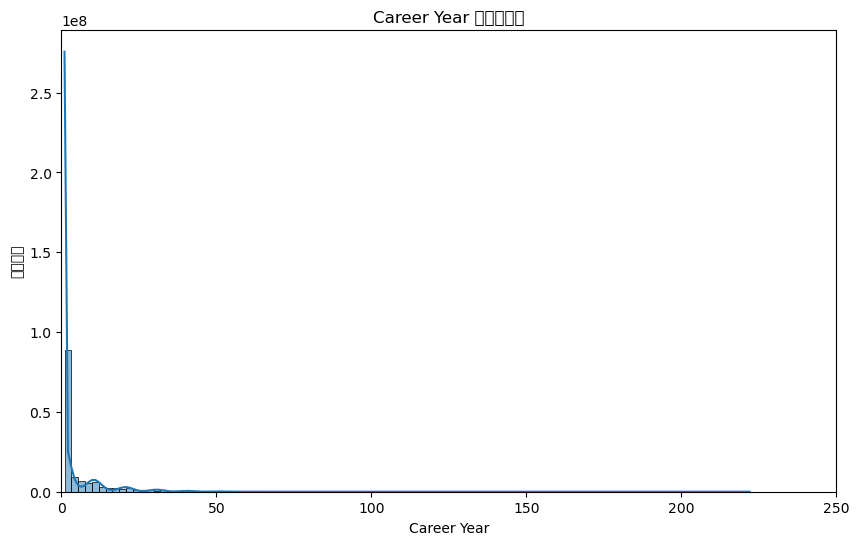

KeyboardInterrupt: 

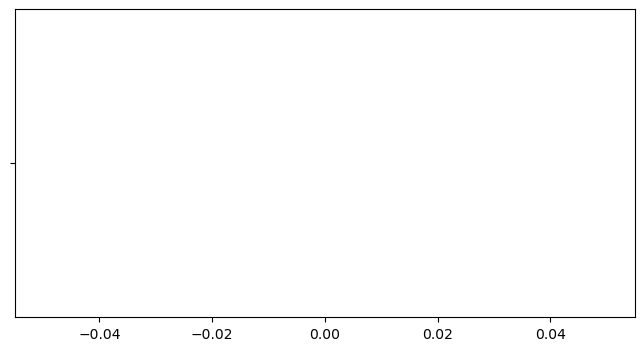

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 加载数据
file_path = 'SciSciNet_MergedData_CareerYear.tsv'
df_career = pd.read_csv(file_path, sep='\t')

# 描述性统计
print("Career Year 列的描述性统计:")
print(df_career['Career Year'].describe())

# 绘制 Career Year 的分布直方图
plt.figure(figsize=(10, 6))
sns.histplot(df_career['Career Year'], bins=100, kde=True) # bins 可以调整直方图的柱子数量
plt.title('Career Year histogram')
plt.xlabel('Career Year')
plt.ylabel('Number of Papers')
plt.xlim(0, 250) # 可以根据描述性统计的结果调整 x 轴范围，更清晰地展示分布
plt.show()

# 绘制 Career Year 的箱线图，查看异常值
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_career['Career Year'])
plt.title('Career Year 箱线图 (异常值检测)')
plt.xlabel('Career Year')
plt.show()

In [1]:
import pandas as pd

def count_papers_by_year(input_file_path, output_file_path=None):
    """
    统计 SciSciNet_MergedData_CareerYear.tsv 文件中，每个年份发表的论文数量。

    Args:
        input_file_path (str): 输入 TSV 文件的路径 (SciSciNet_MergedData_CareerYear.tsv).
        output_file_path (str, optional): 输出结果 TSV 文件的路径. 如果为 None，则只打印结果.
                                         Defaults to None.

    Returns:
        pandas.DataFrame: 包含年份和论文数量的 DataFrame.
                          如果 output_file_path 不为 None, 则返回的 DataFrame 也保存到文件.
    """
    try:
        # 读取 TSV 文件
        df = pd.read_csv(input_file_path, sep='\t')

        # 统计 'Year' 列中每个年份的出现次数
        year_counts = df['Year'].value_counts().reset_index()
        year_counts.columns = ['Year', 'Paper_Count'] # 设置列名

        # 按照年份升序排序 (可选，但通常使结果更有序)
        year_counts_sorted = year_counts.sort_values(by='Year')

        # 打印结果
        print("各年份的论文数量统计:")
        print(year_counts_sorted)

        # 如果指定了输出文件路径，则保存结果到 TSV 文件
        if output_file_path:
            year_counts_sorted.to_csv(output_file_path, sep='\t', index=False)
            print(f"\n已将结果保存到: {output_file_path}")

        return year_counts_sorted

    except FileNotFoundError:
        print(f"错误: 输入文件 '{input_file_path}' 未找到.")
        return None
    except pd.errors.ParserError:
        print(f"错误: 解析文件 '{input_file_path}' 失败，请检查文件格式是否为 TSV.")
        return None
    except KeyError as e:
        print(f"键错误: 列名 '{e}' 不存在于文件中. 确保文件包含 'Year' 列.")
        return None
    except Exception as e:
        print(f"发生未知错误: {e}")
        return None

# 设置输入和输出文件路径
input_tsv_file = 'SciSciNet_MergedData_CareerYear.tsv' # 你的输入文件名
output_tsv_file = 'Year_PaperCounts.tsv' # 输出统计结果的文件名 (可选)

# 执行统计并保存结果 (如果需要保存文件，则取消注释 output_tsv_file 参数)
year_paper_counts_df = count_papers_by_year(input_tsv_file, output_tsv_file)
# 如果只想打印结果，可以这样调用:
# year_paper_counts_df = count_papers_by_year(input_tsv_file)

各年份的论文数量统计:
       Year  Paper_Count
196  1800.0         1476
203  1801.0          895
209  1802.0          815
206  1803.0          827
218  1804.0          725
..      ...          ...
4    2018.0      5967295
1    2019.0      6308169
0    2020.0      6606804
2    2021.0      6262356
75   2022.0       105852

[223 rows x 2 columns]

已将结果保存到: Year_PaperCounts.tsv


In [3]:
import pandas as pd

def extract_long_career_years(input_file_path, output_file_path):
    """
    从 SciSciNet_MergedData_CareerYear.tsv 文件中提取职业生涯年份超过或等于 200 年的论文记录，
    并将这些记录保存到新的 TSV 文件。

    Args:
        input_file_path (str): 输入 TSV 文件的路径 (SciSciNet_MergedData_CareerYear.tsv).
        output_file_path (str): 输出 TSV 文件的路径，用于保存职业生涯年份过长的记录.
    """
    try:
        # 读取 TSV 文件
        df = pd.read_csv(input_file_path, sep='\t')

        # 筛选 'Career Year' 大于等于 200 的行
        long_career_year_df = df[df['Career Year'] >= 200]

        # 检查是否找到符合条件的记录
        if long_career_year_df.empty:
            print("没有找到职业生涯年份大于等于 200 年的论文记录。")
        else:
            # 保存筛选结果到新的 TSV 文件，不包含索引
            long_career_year_df.to_csv(output_file_path, sep='\t', index=False)
            print(f"已将职业生涯年份大于等于 200 年的论文记录保存到: {output_file_path}")

    except FileNotFoundError:
        print(f"错误: 输入文件 '{input_file_path}' 未找到.")
    except pd.errors.ParserError:
        print(f"错误: 解析文件 '{input_file_path}' 失败，请检查文件格式是否为 TSV.")
    except KeyError as e:
        print(f"键错误: 列名 '{e}' 不存在于文件中. 确保文件包含 'Career Year' 列.")
    except Exception as e:
        print(f"发生未知错误: {e}")

# 设置输入和输出文件路径
input_tsv_file = 'SciSciNet_MergedData_CareerYear.tsv' # 你的输入文件名
output_tsv_file = 'Long_Career_Years_Papers.tsv' # 输出文件名，用于保存职业生涯年份过长的论文记录

# 执行提取操作
extract_long_career_years(input_tsv_file, output_tsv_file)

已将职业生涯年份大于等于 200 年的论文记录保存到: Long_Career_Years_Papers.tsv


In [4]:
import pandas as pd

def extract_long_career_years(input_file_path, output_file_path):
    """
    从 SciSciNet_MergedData_CareerYear.tsv 文件中提取职业生涯年份超过或等于 200 年的论文记录，
    并将这些记录保存到新的 TSV 文件。

    Args:
        input_file_path (str): 输入 TSV 文件的路径 (SciSciNet_MergedData_CareerYear.tsv).
        output_file_path (str): 输出 TSV 文件的路径，用于保存职业生涯年份过长的记录.
    """
    try:
        # 读取 TSV 文件
        df = pd.read_csv(input_file_path, sep='\t')

        # 筛选 'Career Year' 大于等于 200 的行
        long_career_year_df = df[df['Career Year'] >= 200]

        # 检查是否找到符合条件的记录
        if long_career_year_df.empty:
            print("没有找到职业生涯年份大于等于 200 年的论文记录。")
        else:
            # 保存筛选结果到新的 TSV 文件，不包含索引
            long_career_year_df.to_csv(output_file_path, sep='\t', index=False)
            print(f"已将职业生涯年份大于等于 200 年的论文记录保存到: {output_file_path}")

    except FileNotFoundError:
        print(f"错误: 输入文件 '{input_file_path}' 未找到.")
    except pd.errors.ParserError:
        print(f"错误: 解析文件 '{input_file_path}' 失败，请检查文件格式是否为 TSV.")
    except KeyError as e:
        print(f"键错误: 列名 '{e}' 不存在于文件中. 确保文件包含 'Career Year' 列.")
    except Exception as e:
        print(f"发生未知错误: {e}")

# 设置输入和输出文件路径
input_tsv_file = 'Merged_Cleaned_InTraFlow_CareerYear.tsv' # 你的输入文件名
output_tsv_file = 'Long_Career_Years_Papers_intraflow.tsv' # 输出文件名，用于保存职业生涯年份过长的论文记录

# 执行提取操作
extract_long_career_years(input_tsv_file, output_tsv_file)

已将职业生涯年份大于等于 200 年的论文记录保存到: Long_Career_Years_Papers_intraflow.tsv


In [5]:
import pandas as pd

def merge_career_year_by_paperid(intraflow_file_path, career_year_file_path, output_file_path):
    """
    根据 PaperID 将 Merged_Cleaned_InTraFlow.tsv 文件与 SciSciNet_MergedData_CareerYear.tsv 文件合并，
    添加 Career Year 信息到 Merged_Cleaned_InTraFlow.tsv。

    Args:
        intraflow_file_path (str): Merged_Cleaned_InTraFlow.tsv 文件的路径.
        career_year_file_path (str): SciSciNet_MergedData_CareerYear.tsv 文件的路径.
        output_file_path (str): 输出合并后 TSV 文件的路径.
    """
    try:
        # 读取 Merged_Cleaned_InTraFlow.tsv 文件
        df_intraflow = pd.read_csv(intraflow_file_path, sep='\t')

        # 读取 SciSciNet_MergedData_CareerYear.tsv 文件，只读取 PaperID 和 Career Year 列
        df_career_year = pd.read_csv(career_year_file_path, sep='\t', usecols=['PaperID', 'Career Year'])

        # 确保两个 DataFrame 中用于合并的列名都是 'PaperID'
        # Merged_Cleaned_InTraFlow.tsv 的 PaperID 列在索引为 1 的位置，假设没有 header，或者header是第一行
        # 假设 Merged_Cleaned_InTraFlow.tsv 的 header 是在第一行，并且第二列的列名可以自动识别或者不需要指定列名
        # 如果 Merged_Cleaned_InTraFlow.tsv 没有 header 并且第二列没有列名，需要手动设置列名或者使用 header=None 并指定 names

        # 假设 Merged_Cleaned_InTraFlow.tsv 的第二列就是 PaperID，且列名正确或可以访问，例如 "PaperID" 或 默认索引访问
        # 如果列名不是 "PaperID"，或者需要根据位置访问，可能需要先检查或重命名列
        # 为了通用性，假设 Merged_Cleaned_InTraFlow.tsv 的第二列（索引 1）是我们需要的 PaperID 列
        # 并且假设它已经有一个合适的列名或者我们稍后可以通过索引来操作

        # 合并两个 DataFrame，基于 'PaperID' 列
        df_merged = pd.merge(df_intraflow, df_career_year, on='PaperID', how='left')

        # 保存合并后的 DataFrame 到新的 TSV 文件
        df_merged.to_csv(output_file_path, sep='\t', index=False)
        print(f"已将合并后的文件保存到: {output_file_path}")

    except FileNotFoundError:
        print(f"错误: 文件未找到，请检查文件路径是否正确.")
    except pd.errors.ParserError:
        print(f"错误: 解析文件失败，请检查文件格式是否为 TSV.")
    except KeyError as e:
        print(f"键错误: 列名 '{e}' 不存在于文件中. 确保文件包含 'PaperID' 和 'Career Year' 列.")
    except Exception as e:
        print(f"发生未知错误: {e}")

# 设置文件路径
intraflow_file = 'Merged_Cleaned_InTraFlow.tsv'
career_year_file = 'SciSciNet_MergedData_CareerYear.tsv'
output_file = 'Merged_Cleaned_InTraFlow_CareerYear.tsv' # 输出文件，将包含 Career Year

# 执行合并操作
merge_career_year_by_paperid(intraflow_file, career_year_file, output_file)

已将合并后的文件保存到: Merged_Cleaned_InTraFlow_CareerYear.tsv


In [6]:
import pandas as pd

def count_papers_by_year(input_file_path, output_file_path=None):
    """
    统计 SciSciNet_MergedData_CareerYear.tsv 文件中，每个年份发表的论文数量。

    Args:
        input_file_path (str): 输入 TSV 文件的路径 (SciSciNet_MergedData_CareerYear.tsv).
        output_file_path (str, optional): 输出结果 TSV 文件的路径. 如果为 None，则只打印结果.
                                         Defaults to None.

    Returns:
        pandas.DataFrame: 包含年份和论文数量的 DataFrame.
                          如果 output_file_path 不为 None, 则返回的 DataFrame 也保存到文件.
    """
    try:
        # 读取 TSV 文件
        df = pd.read_csv(input_file_path, sep='\t')

        # 统计 'Year' 列中每个年份的出现次数
        year_counts = df['Year'].value_counts().reset_index()
        year_counts.columns = ['Year', 'Paper_Count'] # 设置列名

        # 按照年份升序排序 (可选，但通常使结果更有序)
        year_counts_sorted = year_counts.sort_values(by='Year')

        # 打印结果
        print("各年份的论文数量统计:")
        print(year_counts_sorted)

        # 如果指定了输出文件路径，则保存结果到 TSV 文件
        if output_file_path:
            year_counts_sorted.to_csv(output_file_path, sep='\t', index=False)
            print(f"\n已将结果保存到: {output_file_path}")

        return year_counts_sorted

    except FileNotFoundError:
        print(f"错误: 输入文件 '{input_file_path}' 未找到.")
        return None
    except pd.errors.ParserError:
        print(f"错误: 解析文件 '{input_file_path}' 失败，请检查文件格式是否为 TSV.")
        return None
    except KeyError as e:
        print(f"键错误: 列名 '{e}' 不存在于文件中. 确保文件包含 'Year' 列.")
        return None
    except Exception as e:
        print(f"发生未知错误: {e}")
        return None

# 设置输入和输出文件路径
input_tsv_file = 'PaperID_Year_sorted.tsv' # 你的输入文件名
output_tsv_file = 'Year_PaperCounts_all.tsv' # 输出统计结果的文件名 (可选)

# 执行统计并保存结果 (如果需要保存文件，则取消注释 output_tsv_file 参数)
year_paper_counts_df = count_papers_by_year(input_tsv_file, output_tsv_file)
# 如果只想打印结果，可以这样调用:
# year_paper_counts_df = count_papers_by_year(input_tsv_file)

各年份的论文数量统计:
       Year  Paper_Count
196  1800.0         1510
203  1801.0          905
209  1802.0          825
207  1803.0          833
218  1804.0          729
..      ...          ...
4    2018.0      5845847
1    2019.0      6148831
0    2020.0      6415292
2    2021.0      6058310
75   2022.0       100990

[223 rows x 2 columns]

已将结果保存到: Year_PaperCounts_all.tsv


In [7]:
import pandas as pd

def extract_long_career_years(input_file_path, output_file_path):
    """
    从 SciSciNet_MergedData_CareerYear.tsv 文件中提取职业生涯年份超过或等于 200 年的论文记录，
    并将这些记录保存到新的 TSV 文件。

    Args:
        input_file_path (str): 输入 TSV 文件的路径 (SciSciNet_MergedData_CareerYear.tsv).
        output_file_path (str): 输出 TSV 文件的路径，用于保存职业生涯年份过长的记录.
    """
    try:
        # 读取 TSV 文件
        df = pd.read_csv(input_file_path, sep='\t')

        # 筛选 'Career Year' 大于等于 200 的行
        long_career_year_df = df[df['Career Year'] >= 200]

        # 检查是否找到符合条件的记录
        if long_career_year_df.empty:
            print("没有找到职业生涯年份大于等于 200 年的论文记录。")
        else:
            # 保存筛选结果到新的 TSV 文件，不包含索引
            long_career_year_df.to_csv(output_file_path, sep='\t', index=False)
            print(f"已将职业生涯年份大于等于 200 年的论文记录保存到: {output_file_path}")

    except FileNotFoundError:
        print(f"错误: 输入文件 '{input_file_path}' 未找到.")
    except pd.errors.ParserError:
        print(f"错误: 解析文件 '{input_file_path}' 失败，请检查文件格式是否为 TSV.")
    except KeyError as e:
        print(f"键错误: 列名 '{e}' 不存在于文件中. 确保文件包含 'Career Year' 列.")
    except Exception as e:
        print(f"发生未知错误: {e}")

# 设置输入和输出文件路径
input_tsv_file = 'Merged_Cleaned_InTraFlow_CareerYear.tsv' # 你的输入文件名
output_tsv_file = 'Long_Career_Years_Papers_intraflow.tsv' # 输出文件名，用于保存职业生涯年份过长的论文记录

# 执行提取操作
extract_long_career_years(input_tsv_file, output_tsv_file)

已将职业生涯年份大于等于 200 年的论文记录保存到: Long_Career_Years_Papers_intraflow.tsv


In [8]:
import pandas as pd

def count_papers_by_year(input_file_path, output_file_path=None):
    """
    统计 SciSciNet_MergedData_CareerYear.tsv 文件中，每个年份发表的论文数量。

    Args:
        input_file_path (str): 输入 TSV 文件的路径 (SciSciNet_MergedData_CareerYear.tsv).
        output_file_path (str, optional): 输出结果 TSV 文件的路径. 如果为 None，则只打印结果.
                                         Defaults to None.

    Returns:
        pandas.DataFrame: 包含年份和论文数量的 DataFrame.
                          如果 output_file_path 不为 None, 则返回的 DataFrame 也保存到文件.
    """
    try:
        # 读取 TSV 文件
        df = pd.read_csv(input_file_path, sep='\t')

        # 统计 'Year' 列中每个年份的出现次数
        year_counts = df['Year'].value_counts().reset_index()
        year_counts.columns = ['Year', 'Paper_Count'] # 设置列名

        # 按照年份升序排序 (可选，但通常使结果更有序)
        year_counts_sorted = year_counts.sort_values(by='Year')

        # 打印结果
        print("各年份的论文数量统计:")
        print(year_counts_sorted)

        # 如果指定了输出文件路径，则保存结果到 TSV 文件
        if output_file_path:
            year_counts_sorted.to_csv(output_file_path, sep='\t', index=False)
            print(f"\n已将结果保存到: {output_file_path}")

        return year_counts_sorted

    except FileNotFoundError:
        print(f"错误: 输入文件 '{input_file_path}' 未找到.")
        return None
    except pd.errors.ParserError:
        print(f"错误: 解析文件 '{input_file_path}' 失败，请检查文件格式是否为 TSV.")
        return None
    except KeyError as e:
        print(f"键错误: 列名 '{e}' 不存在于文件中. 确保文件包含 'Year' 列.")
        return None
    except Exception as e:
        print(f"发生未知错误: {e}")
        return None

# 设置输入和输出文件路径
input_tsv_file = 'Merged_Cleaned_InTraFlow_CareerYear.tsv' # 你的输入文件名
output_tsv_file = 'Year_PaperCounts_intraflow.tsv' # 输出统计结果的文件名 (可选)

# 执行统计并保存结果 (如果需要保存文件，则取消注释 output_tsv_file 参数)
year_paper_counts_df = count_papers_by_year(input_tsv_file, output_tsv_file)
# 如果只想打印结果，可以这样调用:
# year_paper_counts_df = count_papers_by_year(input_tsv_file)

各年份的论文数量统计:
       Year  Paper_Count
183  1800.0           30
219  1801.0            8
222  1802.0            5
199  1803.0           15
216  1804.0            9
..      ...          ...
6    2018.0       593809
1    2019.0       640476
0    2020.0       652036
2    2021.0       635015
48   2022.0        18547

[223 rows x 2 columns]

已将结果保存到: Year_PaperCounts_intraflow.tsv


In [10]:
import pandas as pd
import numpy as np

# 加载数据
file_path = 'Merged_Cleaned_InTraFlow_CareerYear.tsv'
df = pd.read_csv(file_path, sep='\t')

# 步骤 1: 直接根据 Career Year 筛选，排除 Career Year 大于 80 的数据
df_filtered_career_year = df[df['Career Year'] <= 80]
df = df_filtered_career_year # 更新 DataFrame 为 Career Year 过滤后的数据

# 定义需要计算均值的列名 (包括原始的 InTraFlow 列)
columns_to_mean = [
    'Citation_Count', 'C10', 'C5', 'Team_size', 'Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T',
    'InTraFlowf', 'InTraFlow', 'N_InTraFlow', 'Patent_Count', 'Fund', 'Field_CS', 'Field_Eng',
    'Field_Eco', 'Log_Team_size', 'Log_C5', 'Log_Patent_Count', 'Log_Fund'
]

# 步骤 2: 处理 inf 值，将 inf 替换为 NaN
for col in columns_to_mean:
    if df[col].dtype in ['float64', 'int64']: # 仅对数值型列进行 inf 值处理
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)

# 步骤 3: 按 'Career Year' 分组并计算均值
career_year_group_means = df.groupby('Career Year')[columns_to_mean].mean().reset_index()

# 输出到 Excel 文件
output_excel_file = 'CareerYear_Grouped_Means_CareerYearFiltered_NaNInf.xlsx' # 修改输出文件名以反映修改
career_year_group_means.to_excel(output_excel_file, index=False)

print(f"已将 Career Year 在80年以内的数据，并处理inf值的按 Career Year 分组计算的均值结果输出到文件: {output_excel_file}")

已将 Career Year 在80年以内的数据，并处理inf值的按 Career Year 分组计算的均值结果输出到文件: CareerYear_Grouped_Means_CareerYearFiltered_NaNInf.xlsx


In [11]:
import pandas as pd
import numpy as np

# 加载数据
file_path = 'Merged_Cleaned_InTraFlow_CareerYear.tsv'
df = pd.read_csv(file_path, sep='\t')

# 步骤 1: 直接根据 Career Year 筛选，排除 Career Year 大于 80 的数据
df_filtered_career_year = df[df['Career Year'] <= 80]
df = df_filtered_career_year # 更新 DataFrame 为 Career Year 过滤后的数据

# 定义需要计算均值的列名 (排除 InTraFlow 本身，以及其他不需要的列，和之前的保持一致)
columns_to_mean = [
    'Citation_Count', 'C10', 'C5', 'Team_size', 'Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T',
    'Patent_Count', 'Fund', 'Field_CS', 'Field_Eng',
    'Field_Eco', 'Log_Team_size', 'Log_C5', 'Log_Patent_Count', 'Log_Fund'
]

# 步骤 2: 处理 inf 值，将 inf 替换为 NaN (在计算百分位数之前处理)
for col in columns_to_mean + ['InTraFlow', 'N_InTraFlow']: # 包括 InTraFlow 和 N_InTraFlow 列
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)

# 步骤 3: 划分 InTraFlow 高低组
q1_intraflow = df['InTraFlow'].quantile(0.25)
q3_intraflow = df['InTraFlow'].quantile(0.75)

df_low_intraflow = df[df['InTraFlow'] <= q1_intraflow]
df_high_intraflow = df[df['InTraFlow'] >= q3_intraflow]

# 步骤 4: 分别计算高低 InTraFlow 组在每个 Career Year 的平均值
mean_low_intraflow = df_low_intraflow.groupby('Career Year')[columns_to_mean].mean().reset_index()
mean_high_intraflow = df_high_intraflow.groupby('Career Year')[columns_to_mean].mean().reset_index()

# 步骤 5: 输出到 Excel 文件，不同 sheet 存放高低组数据
output_excel_file = 'CareerYear_Grouped_Means_HighLowInTraFlow.xlsx'

with pd.ExcelWriter(output_excel_file) as writer:
    mean_low_intraflow.to_excel(writer, sheet_name='Low_InTraFlow', index=False)
    mean_high_intraflow.to_excel(writer, sheet_name='High_InTraFlow', index=False)

print(f"已将高低 InTraFlow 组按 Career Year 分组计算的均值结果输出到文件: {output_excel_file}")

已将高低 InTraFlow 组按 Career Year 分组计算的均值结果输出到文件: CareerYear_Grouped_Means_HighLowInTraFlow.xlsx


In [12]:
import pandas as pd
import numpy as np

# 加载数据
file_path = 'Merged_Cleaned_InTraFlow_CareerYear.tsv'
df = pd.read_csv(file_path, sep='\t')

# 步骤 1: 直接根据 Career Year 筛选，排除 Career Year 大于 80 的数据
df_filtered_career_year = df[df['Career Year'] <= 80]
df = df_filtered_career_year # 更新 DataFrame 为 Career Year 过滤后的数据

# 定义需要计算均值的列名 (排除 InTraFlow 本身，以及其他不需要的列，和之前的保持一致)
columns_to_mean = [
    'Citation_Count', 'C10', 'C5', 'Team_size', 'Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T',
    'Patent_Count', 'Fund', 'Field_CS', 'Field_Eng',
    'Field_Eco', 'Log_Team_size', 'Log_C5', 'Log_Patent_Count', 'Log_Fund'
]

# 步骤 2: 处理 inf 值，将 inf 替换为 NaN (在计算百分位数之前处理)
for col in columns_to_mean + ['InTraFlow', 'N_InTraFlow']: # 包括 InTraFlow 和 N_InTraFlow 列
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)

# 步骤 3: 划分 InTraFlow 高低组
q1_intraflow = df['InTraFlow'].quantile(0.25)
q3_intraflow = df['InTraFlow'].quantile(0.75)

df_low_intraflow = df[df['InTraFlow'] <= q1_intraflow]
df_high_intraflow = df[df['InTraFlow'] >= q3_intraflow]

# 步骤 4: 分别计算高低 InTraFlow 组在每个 Career Year 的平均值
mean_low_intraflow = df_low_intraflow.groupby('Career Year')[columns_to_mean].mean().reset_index()
mean_high_intraflow = df_high_intraflow.groupby('Career Year')[columns_to_mean].mean().reset_index()

# 步骤 5: 添加 'InTraFlow Group' 列，用于区分高低组
mean_low_intraflow['InTraFlow Group'] = 'Low'
mean_high_intraflow['InTraFlow Group'] = 'High'

# 步骤 6: 合并高低 InTraFlow 组的数据到一个 DataFrame
combined_means = pd.concat([mean_low_intraflow, mean_high_intraflow], ignore_index=True)

# 步骤 7: 输出到 Excel 文件，所有数据在同一个 sheet
output_excel_file = 'CareerYear_Grouped_Means_Combined_HighLowInTraFlow.xlsx'
combined_means.to_excel(output_excel_file, sheet_name='Combined_Means', index=False)

print(f"已将高低 InTraFlow 组按 Career Year 分组计算的均值结果合并输出到文件: {output_excel_file}")

已将高低 InTraFlow 组按 Career Year 分组计算的均值结果合并输出到文件: CareerYear_Grouped_Means_Combined_HighLowInTraFlow.xlsx


In [13]:
import pandas as pd
import numpy as np

# 加载数据
file_path = 'Merged_Cleaned_InTraFlow_CareerYear.tsv'
df = pd.read_csv(file_path, sep='\t')

# 步骤 1: 直接根据 Career Year 筛选，排除 Career Year 大于 80 的数据
df_filtered_career_year = df[df['Career Year'] <= 80]
df = df_filtered_career_year # 更新 DataFrame 为 Career Year 过滤后的数据

# 定义需要计算均值的列名 (排除 InTraFlow 本身，以及其他不需要的列，和之前的保持一致)
columns_to_mean = [
    'Citation_Count', 'C10', 'C5', 'Team_size', 'Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T',
    'Patent_Count', 'Fund', 'Field_CS', 'Field_Eng',
    'Field_Eco', 'Log_Team_size', 'Log_C5', 'Log_Patent_Count', 'Log_Fund'
]

# 步骤 2: 处理 inf 值，将 inf 替换为 NaN (在计算百分位数之前处理)
for col in columns_to_mean + ['InTraFlow', 'N_InTraFlow']: # 包括 InTraFlow 和 N_InTraFlow 列
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)

# 步骤 3: 划分 InTraFlow 高低组
q1_intraflow = df['InTraFlow'].quantile(0.25)
q3_intraflow = df['InTraFlow'].quantile(0.75)

df_low_intraflow = df[df['InTraFlow'] <= q1_intraflow]
df_high_intraflow = df[df['InTraFlow'] >= q3_intraflow]

# 步骤 4: 分别计算高低 InTraFlow 组在每个 Career Year 的平均值
mean_low_intraflow = df_low_intraflow.groupby('Career Year')[columns_to_mean].mean().reset_index()
mean_high_intraflow = df_high_intraflow.groupby('Career Year')[columns_to_mean].mean().reset_index()

# 步骤 5: 重命名列名，添加 "_Low" 和 "_High" 后缀
mean_low_intraflow.columns = ['Career Year'] + [col + '_Low' for col in columns_to_mean]
mean_high_intraflow.columns = ['Career Year'] + [col + '_High' for col in columns_to_mean]

# 步骤 6: 横向合并高低 InTraFlow 组的数据，基于 'Career Year'
combined_means_horizontal = pd.merge(mean_low_intraflow, mean_high_intraflow, on='Career Year', how='outer')

# 步骤 7: 输出到 Excel 文件，所有数据在同一个 sheet，横向排列
output_excel_file = 'CareerYear_Grouped_Means_Horizontal_HighLowInTraFlow.xlsx'
combined_means_horizontal.to_excel(output_excel_file, sheet_name='Horizontal_Combined_Means', index=False)

print(f"已将高低 InTraFlow 组按 Career Year 分组计算的均值结果横向合并输出到文件: {output_excel_file}")

已将高低 InTraFlow 组按 Career Year 分组计算的均值结果横向合并输出到文件: CareerYear_Grouped_Means_Horizontal_HighLowInTraFlow.xlsx


In [14]:
import pandas as pd
import numpy as np

# 加载数据
file_path = 'Merged_Cleaned_InTraFlow_CareerYear.tsv'
df = pd.read_csv(file_path, sep='\t')

# 步骤 1: 直接根据 Career Year 筛选，排除 Career Year 大于 80 的数据
df_filtered_career_year = df[df['Career Year'] <= 80]
df = df_filtered_career_year # 更新 DataFrame 为 Career Year 过滤后的数据

# 定义需要计算均值的列名 (排除 InTraFlow 本身，以及其他不需要的列，和之前的保持一致)
columns_to_mean = [
    'Citation_Count', 'C10', 'C5', 'Team_size', 'Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T',
    'Patent_Count', 'Fund', 'Field_CS', 'Field_Eng',
    'Field_Eco', 'Log_Team_size', 'Log_C5', 'Log_Patent_Count', 'Log_Fund'
]

# 步骤 2: 处理 inf 值，将 inf 替换为 NaN (在计算百分位数之前处理)
for col in columns_to_mean + ['InTraFlow', 'N_InTraFlow']: # 包括 InTraFlow 和 N_InTraFlow 列
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)

# 步骤 3: 划分 N_InTraFlow 高低组 (修改为 N_InTraFlow)
q1_n_intraflow = df['N_InTraFlow'].quantile(0.25) # 修改为 N_InTraFlow
q3_n_intraflow = df['N_InTraFlow'].quantile(0.75) # 修改为 N_InTraFlow

df_low_n_intraflow = df[df['N_InTraFlow'] <= q1_n_intraflow] # 修改为 N_InTraFlow 和 q1_n_intraflow
df_high_n_intraflow = df[df['N_InTraFlow'] >= q3_n_intraflow] # 修改为 N_InTraFlow 和 q3_n_intraflow

# 步骤 4: 分别计算高低 N_InTraFlow 组在每个 Career Year 的平均值 (修改为 N_InTraFlow)
mean_low_n_intraflow = df_low_n_intraflow.groupby('Career Year')[columns_to_mean].mean().reset_index() # 修改为 df_low_n_intraflow
mean_high_n_intraflow = df_high_n_intraflow.groupby('Career Year')[columns_to_mean].mean().reset_index() # 修改为 df_high_n_intraflow

# 步骤 5: 重命名列名，添加 "_Low_N" 和 "_High_N" 后缀 (修改为 N_InTraFlow)
mean_low_n_intraflow.columns = ['Career Year'] + [col + '_Low_N' for col in columns_to_mean] # 修改后缀为 _Low_N
mean_high_n_intraflow.columns = ['Career Year'] + [col + '_High_N' for col in columns_to_mean] # 修改后缀为 _High_N

# 步骤 6: 横向合并高低 N_InTraFlow 组的数据，基于 'Career Year' (修改为 N_InTraFlow)
combined_means_horizontal = pd.merge(mean_low_n_intraflow, mean_high_n_intraflow, on='Career Year', how='outer') # 修改为 mean_low_n_intraflow 和 mean_high_n_intraflow

# 步骤 7: 输出到 Excel 文件，所有数据在同一个 sheet，横向排列 (修改为 N_InTraFlow 文件名)
output_excel_file = 'CareerYear_Grouped_Means_Horizontal_HighLowN_InTraFlow.xlsx' # 修改输出文件名为 N_InTraFlow
combined_means_horizontal.to_excel(output_excel_file, sheet_name='Horizontal_Combined_Means_N', index=False) # 修改 sheet 名为 N_InTraFlow

print(f"已将高低 N_InTraFlow 组按 Career Year 分组计算的均值结果横向合并输出到文件: {output_excel_file}") # 修改输出信息为 N_InTraFlow

已将高低 N_InTraFlow 组按 Career Year 分组计算的均值结果横向合并输出到文件: CareerYear_Grouped_Means_Horizontal_HighLowN_InTraFlow.xlsx


In [16]:
import pandas as pd
import numpy as np

# 加载数据
file_path = 'Merged_Cleaned_InTraFlow_CareerYear.tsv'
df = pd.read_csv(file_path, sep='\t')

# 步骤 1: 直接根据 Career Year 筛选，排除 Career Year 大于 80 的数据
df_filtered_career_year = df[df['Career Year'] <= 80]
df = df_filtered_career_year # 更新 DataFrame 为 Career Year 过滤后的数据

# 定义需要计算均值的列名 (现在包括 'N_InTraFlow' 以及其他指标)
columns_to_mean = [
    'Citation_Count', 'C10', 'C5', 'Team_size', 'Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T',
    'Patent_Count', 'Fund', 'Field_CS', 'Field_Eng',
    'Field_Eco', 'Log_Team_size', 'Log_C5', 'Log_Patent_Count', 'Log_Fund', 'N_InTraFlow' # 添加 'N_InTraFlow'
]

# 步骤 2: 处理 inf 值，将 inf 替换为 NaN (在计算百分位数之前处理)
for col in columns_to_mean: #  现在只需要 columns_to_mean
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)

# 步骤 3: 划分 N_InTraFlow 高低组
q1_n_intraflow = df['N_InTraFlow'].quantile(0.25)
q3_n_intraflow = df['N_InTraFlow'].quantile(0.75)

df_low_n_intraflow = df[df['N_InTraFlow'] <= q1_n_intraflow]
df_high_n_intraflow = df[df['N_InTraFlow'] >= q3_n_intraflow]

# 步骤 4: 分别计算高低 N_InTraFlow 组在每个 Career Year 的平均值
mean_low_n_intraflow = df_low_n_intraflow.groupby('Career Year')[columns_to_mean].mean().reset_index()
mean_high_n_intraflow = df_high_n_intraflow.groupby('Career Year')[columns_to_mean].mean().reset_index()

# 步骤 5: 重命名列名，添加 "_Low_N" 和 "_High_N" 后缀
mean_low_n_intraflow.columns = ['Career Year'] + [col + '_Low_N' for col in columns_to_mean]
mean_high_n_intraflow.columns = ['Career Year'] + [col + '_High_N' for col in columns_to_mean]

# 步骤 6: 横向合并高低 N_InTraFlow 组的数据，基于 'Career Year'
combined_means_horizontal = pd.merge(mean_low_n_intraflow, mean_high_n_intraflow, on='Career Year', how='outer')

# 步骤 7: 输出到 Excel 文件，所有数据在同一个 sheet，横向排列
output_excel_file = 'CareerYear_Grouped_Means_Horizontal_HighLowN_InTraFlow_IncN.xlsx' # 修改文件名，缩短
combined_means_horizontal.to_excel(output_excel_file, sheet_name='Horizontal_N', index=False) # 修改 sheet 名为 Horizontal_N (shorter)

print(f"已将高低 N_InTraFlow 组按 Career Year 分组计算的均值结果(包括 N_InTraFlow 均值)横向合并输出到文件: {output_excel_file}") # 修改输出信息

已将高低 N_InTraFlow 组按 Career Year 分组计算的均值结果(包括 N_InTraFlow 均值)横向合并输出到文件: CareerYear_Grouped_Means_Horizontal_HighLowN_InTraFlow_IncN.xlsx


In [17]:
import pandas as pd
import numpy as np

# 加载数据
file_path = 'Merged_Cleaned_InTraFlow_CareerYear.tsv'
df = pd.read_csv(file_path, sep='\t')

# 步骤 1: 直接根据 Career Year 筛选，排除 Career Year 大于 80 的数据
df_filtered_career_year = df[df['Career Year'] <= 80]
df = df_filtered_career_year # 更新 DataFrame 为 Career Year 过滤后的数据

# 定义需要计算均值的列名 (现在包括 'N_InTraFlow' 以及其他指标)
columns_to_mean = [
    'Citation_Count', 'C10', 'C5', 'Team_size', 'Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T',
    'Patent_Count', 'Fund', 'Field_CS', 'Field_Eng',
    'Field_Eco', 'Log_Team_size', 'Log_C5', 'Log_Patent_Count', 'Log_Fund', 'N_InTraFlow' # 添加 'N_InTraFlow'
]

# 步骤 2: 处理 inf 值，将 inf 替换为 NaN (在计算百分位数之前处理)
for col in columns_to_mean: #  现在只需要 columns_to_mean
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)

# 步骤 3: 划分 N_InTraFlow 高低组
q1_n_intraflow = df['InTraFlow'].quantile(0.25)
q3_n_intraflow = df['InTraFlow'].quantile(0.75)

df_low_n_intraflow = df[df['InTraFlow'] <= q1_n_intraflow]
df_high_n_intraflow = df[df['InTraFlow'] >= q3_n_intraflow]

# 步骤 4: 分别计算高低 N_InTraFlow 组在每个 Career Year 的平均值
mean_low_n_intraflow = df_low_n_intraflow.groupby('Career Year')[columns_to_mean].mean().reset_index()
mean_high_n_intraflow = df_high_n_intraflow.groupby('Career Year')[columns_to_mean].mean().reset_index()

# 步骤 5: 重命名列名，添加 "_Low_N" 和 "_High_N" 后缀
mean_low_n_intraflow.columns = ['Career Year'] + [col + '_Low' for col in columns_to_mean]
mean_high_n_intraflow.columns = ['Career Year'] + [col + '_High' for col in columns_to_mean]

# 步骤 6: 横向合并高低 N_InTraFlow 组的数据，基于 'Career Year'
combined_means_horizontal = pd.merge(mean_low_n_intraflow, mean_high_n_intraflow, on='Career Year', how='outer')

# 步骤 7: 输出到 Excel 文件，所有数据在同一个 sheet，横向排列
output_excel_file = 'CareerYear_Grouped_Means_Horizontal_HighLowN_InTraFlow_Inc.xlsx' # 修改文件名，缩短
combined_means_horizontal.to_excel(output_excel_file, sheet_name='Horizontal_N', index=False) # 修改 sheet 名为 Horizontal_N (shorter)

print(f"已将高低 N_InTraFlow 组按 Career Year 分组计算的均值结果(包括 N_InTraFlow 均值)横向合并输出到文件: {output_excel_file}") # 修改输出信息

已将高低 N_InTraFlow 组按 Career Year 分组计算的均值结果(包括 N_InTraFlow 均值)横向合并输出到文件: CareerYear_Grouped_Means_Horizontal_HighLowN_InTraFlow_Inc.xlsx


In [18]:
import pandas as pd
import numpy as np

# 加载数据
file_path = 'Merged_Cleaned_InTraFlow_CareerYear.tsv'
df = pd.read_csv(file_path, sep='\t')

# 步骤 1: 直接根据 Career Year 筛选，排除 Career Year 大于 80 的数据
df_filtered_career_year = df[df['Career Year'] <= 80]
df = df_filtered_career_year # 更新 DataFrame 为 Career Year 过滤后的数据

# 定义需要计算均值的列名 (现在包括 'N_InTraFlow' 以及其他指标)
columns_to_mean = [
    'Citation_Count', 'C10', 'C5', 'Team_size', 'Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T',
    'Patent_Count', 'Fund', 'Field_CS', 'Field_Eng',
    'Field_Eco', 'Log_Team_size', 'Log_C5', 'Log_Patent_Count', 'Log_Fund', 'N_InTraFlow' # 添加 'N_InTraFlow'
]

# 步骤 2: 处理 inf 值，将 inf 替换为 NaN (在计算百分位数之前处理)
for col in columns_to_mean: #  现在只需要 columns_to_mean
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)

# 步骤 3: 严格筛选 InTraFlow 列的前 25% 和后 25%

# 3.1: 按照 'InTraFlow' 列排序 DataFrame
df_sorted_intraflow = df.sort_values(by='InTraFlow', ascending=True)

# 3.2: 计算 25% 和 75% 的索引位置
n_rows = len(df_sorted_intraflow)
index_25 = int(0.25 * n_rows)
index_75 = int(0.75 * n_rows) # 75% 索引用于确定 top 25% 的起始位置

# 3.3: 提取前 25% (bottom 25% based on InTraFlow value) 和 后 25% (top 25% based on InTraFlow value)
df_bottom_25_intraflow = df_sorted_intraflow.iloc[:index_25] #  严格取前 index_25 行作为 bottom 25%
df_top_25_intraflow = df_sorted_intraflow.iloc[index_75:]   #  严格取 index_75 行之后的所有行作为 top 25%


# 步骤 4: 分别计算 前 25% 和 后 25% InTraFlow 组在每个 Career Year 的平均值
mean_bottom_25_intraflow = df_bottom_25_intraflow.groupby('Career Year')[columns_to_mean].mean().reset_index()
mean_top_25_intraflow = df_top_25_intraflow.groupby('Career Year')[columns_to_mean].mean().reset_index()

# 步骤 5: 重命名列名，添加 "_Bottom25_N" 和 "_Top25_N" 后缀
mean_bottom_25_intraflow.columns = ['Career Year'] + [col + '_Bottom25' for col in columns_to_mean]
mean_top_25_intraflow.columns = ['Career Year'] + [col + '_Top25' for col in columns_to_mean]

# 步骤 6: 横向合并 前 25% 和 后 25% InTraFlow 组的数据，基于 'Career Year'
combined_means_horizontal = pd.merge(mean_bottom_25_intraflow, mean_top_25_intraflow, on='Career Year', how='outer')

# 步骤 7: 输出到 Excel 文件，所有数据在同一个 sheet，横向排列
output_excel_file = 'CareerYear_Grouped_Means_Horizontal_TopBottom25N_InTraFlow_Inc.xlsx' # 修改文件名，更清晰
combined_means_horizontal.to_excel(output_excel_file, sheet_name='Horizontal_TopBottom25N', index=False) # 修改 sheet 名

print(f"已将 InTraFlow 排序后，前25% (Bottom 25%) 和后25% (Top 25%) 组按 Career Year 分组计算的均值结果(包括 N_InTraFlow 均值)横向合并输出到文件: {output_excel_file}") # 修改输出信息

已将 InTraFlow 排序后，前25% (Bottom 25%) 和后25% (Top 25%) 组按 Career Year 分组计算的均值结果(包括 N_InTraFlow 均值)横向合并输出到文件: CareerYear_Grouped_Means_Horizontal_TopBottom25N_InTraFlow_Inc.xlsx


In [19]:
import pandas as pd
import numpy as np

# 加载数据
file_path = 'Merged_Cleaned_InTraFlow_CareerYear.tsv'
df = pd.read_csv(file_path, sep='\t')

# 步骤 1: 直接根据 Career Year 筛选，排除 Career Year 大于 80 的数据
df_filtered_career_year = df[df['Career Year'] <= 80]
df = df_filtered_career_year # 更新 DataFrame 为 Career Year 过滤后的数据

# 定义需要计算均值的列名 (现在包括 'N_InTraFlow' 以及其他指标)
columns_to_mean = [
    'Citation_Count', 'C10', 'C5', 'Team_size', 'Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T',
    'Patent_Count', 'Fund', 'Field_CS', 'Field_Eng',
    'Field_Eco', 'Log_Team_size', 'Log_C5', 'Log_Patent_Count', 'Log_Fund', 'N_InTraFlow' # 添加 'N_InTraFlow'
]

# 步骤 2: 处理 inf 值，将 inf 替换为 NaN (在计算百分位数之前处理)
for col in columns_to_mean: #  现在只需要 columns_to_mean
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)

# 步骤 3: 严格筛选 N_InTraFlow 列的前 25% 和后 25%

# 3.1: 按照 'N_InTraFlow' 列排序 DataFrame
df_sorted_n_intraflow = df.sort_values(by='N_InTraFlow', ascending=True) # 修改为 'N_InTraFlow'

# 3.2: 计算 25% 和 75% 的索引位置
n_rows = len(df_sorted_n_intraflow)
index_25 = int(0.25 * n_rows)
index_75 = int(0.75 * n_rows) # 75% 索引用于确定 top 25% 的起始位置

# 3.3: 提取前 25% (bottom 25% based on N_InTraFlow value) 和 后 25% (top 25% based on N_InTraFlow value)
df_bottom_25_n_intraflow = df_sorted_n_intraflow.iloc[:index_25] #  严格取前 index_25 行作为 bottom 25%
df_top_25_n_intraflow = df_sorted_n_intraflow.iloc[index_75:]   #  严格取 index_75 行之后的所有行作为 top 25%


# 步骤 4: 分别计算 前 25% 和 后 25% N_InTraFlow 组在每个 Career Year 的平均值
mean_bottom_25_n_intraflow = df_bottom_25_n_intraflow.groupby('Career Year')[columns_to_mean].mean().reset_index()
mean_top_25_n_intraflow = df_top_25_n_intraflow.groupby('Career Year')[columns_to_mean].mean().reset_index()

# 步骤 5: 重命名列名，添加 "_Bottom25_N" 和 "_Top25_N" 后缀 (保持不变，因为后缀已经体现 N)
mean_bottom_25_n_intraflow.columns = ['Career Year'] + [col + '_Bottom25' for col in columns_to_mean]
mean_top_25_n_intraflow.columns = ['Career Year'] + [col + '_Top25' for col in columns_to_mean]

# 步骤 6: 横向合并 前 25% 和 后 25% N_InTraFlow 组的数据，基于 'Career Year'
combined_means_horizontal = pd.merge(mean_bottom_25_n_intraflow, mean_top_25_n_intraflow, on='Career Year', how='outer')

# 步骤 7: 输出到 Excel 文件，所有数据在同一个 sheet，横向排列
output_excel_file = 'CareerYear_Grouped_Means_Horizontal_TopBottom25N_N_InTraFlow_Inc.xlsx' # 修改文件名，更清晰，更明确 N_InTraFlow
combined_means_horizontal.to_excel(output_excel_file, sheet_name='Horizontal_TopBottom25N', index=False) # 修改 sheet 名 (保持不变)

print(f"已将 N_InTraFlow 排序后，前25% (Bottom 25%) 和后25% (Top 25%) 组按 Career Year 分组计算的均值结果(包括 N_InTraFlow 均值)横向合并输出到文件: {output_excel_file}") # 修改输出信息，更明确 N_InTraFlow

已将 N_InTraFlow 排序后，前25% (Bottom 25%) 和后25% (Top 25%) 组按 Career Year 分组计算的均值结果(包括 N_InTraFlow 均值)横向合并输出到文件: CareerYear_Grouped_Means_Horizontal_TopBottom25N_N_InTraFlow_Inc.xlsx


In [20]:
import pandas as pd
import numpy as np

# 加载数据
file_path = 'Merged_Cleaned_InTraFlow_CareerYear.tsv'
df = pd.read_csv(file_path, sep='\t')

# 步骤 1: 直接根据 Career Year 筛选，排除 Career Year 大于 80 的数据
df_filtered_career_year = df[df['Career Year'] <= 80]
df = df_filtered_career_year # 更新 DataFrame 为 Career Year 过滤后的数据

# 定义需要计算均值的列名 (现在包括 'N_InTraFlow' 以及其他指标)
columns_to_mean = [
    'Citation_Count', 'C10', 'C5', 'Team_size', 'Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T',
    'Patent_Count', 'Fund', 'Log_Team_size', 'Log_C5', 'Log_Patent_Count', 'Log_Fund', 'N_InTraFlow'
]

# 步骤 2: 处理 inf 值，将 inf 替换为 NaN
for col in columns_to_mean:
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)

# 步骤 3: 计算 N_InTraFlow 的总体平均值
overall_mean_n_intraflow = df['N_InTraFlow'].mean()

# 步骤 4: 基于总体平均值划分 N_InTraFlow 高低组
df['N_InTraFlow_Group'] = np.where(df['N_InTraFlow'] >= overall_mean_n_intraflow, 'High_N_Avg', 'Low_N_Avg')

# 步骤 5: 分别计算高低 N_InTraFlow 组在每个 Career Year 的平均值
mean_grouped_n_intraflow = df.groupby(['Career Year', 'N_InTraFlow_Group'])[columns_to_mean].mean().reset_index()

# 步骤 6:  数据透视，将 'N_InTraFlow_Group' 的 'Low_N_Avg' 和 'High_N_Avg' 变为列
pivot_df = mean_grouped_n_intraflow.pivot(index='Career Year', columns='N_InTraFlow_Group', values=columns_to_mean)

# 步骤 7: 展平多级列索引，并重命名列名
pivot_df.columns = [f'{col}_{group}' for group, col in pivot_df.columns]
pivot_df = pivot_df.reset_index() # 将 Career Year 变回列

# 步骤 8: 输出到 Excel 文件
output_excel_file = 'Avg N_InTraFlow.xlsx' # 修改文件名
pivot_df.to_excel(output_excel_file, sheet_name='Horizontal_AvgN', index=False) # 修改 sheet 名

print(f"已将基于 N_InTraFlow 总体平均值分组的高低组按 Career Year 分组计算的均值结果(包括 N_InTraFlow 均值)输出到文件: {output_excel_file}")

已将基于 N_InTraFlow 总体平均值分组的高低组按 Career Year 分组计算的均值结果(包括 N_InTraFlow 均值)输出到文件: Avg N_InTraFlow.xlsx


In [22]:
import pandas as pd
import numpy as np

# 加载数据
file_path = 'Merged_Cleaned_InTraFlow_CareerYear.tsv'
df = pd.read_csv(file_path, sep='\t')

# 步骤 1: 直接根据 Career Year 筛选，排除 Career Year 大于 80 的数据
df_filtered_career_year = df[df['Career Year'] <= 80]
df = df_filtered_career_year # 更新 DataFrame 为 Career Year 过滤后的数据

# 定义需要计算均值的列名 (现在包括 'InTraFlow' 以及其他指标)
columns_to_mean = [
    'Citation_Count', 'C10', 'C5', 'Team_size', 'Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T',
    'Patent_Count', 'Fund', 'Log_Team_size', 'Log_C5', 'Log_Patent_Count', 'Log_Fund', 'InTraFlow'
]

# 步骤 2: 处理 inf 值，将 inf 替换为 NaN
for col in columns_to_mean:
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)

# 步骤 3: 计算 N_InTraFlow 的总体平均值
overall_mean_n_intraflow = df['InTraFlow'].mean()

# 步骤 4: 基于总体平均值划分 N_InTraFlow 高低组
df['InTraFlow_Group'] = np.where(df['InTraFlow'] >= overall_mean_n_intraflow, 'High_N_Avg', 'Low_N_Avg')

# 步骤 5: 分别计算高低 N_InTraFlow 组在每个 Career Year 的平均值
mean_grouped_n_intraflow = df.groupby(['Career Year', 'InTraFlow_Group'])[columns_to_mean].mean().reset_index()

# 步骤 6:  数据透视，将 'InTraFlow_Group' 的 'Low_N_Avg' 和 'High_N_Avg' 变为列
pivot_df = mean_grouped_n_intraflow.pivot(index='Career Year', columns='InTraFlow_Group', values=columns_to_mean)

# 步骤 7: 展平多级列索引，并重命名列名
pivot_df.columns = [f'{col}_{group}' for group, col in pivot_df.columns]
pivot_df = pivot_df.reset_index() # 将 Career Year 变回列

# 步骤 8: 输出到 Excel 文件
output_excel_file = 'Avg InTraFlow.xlsx' # 修改文件名
pivot_df.to_excel(output_excel_file, sheet_name='Horizontal_AvgN', index=False) # 修改 sheet 名

print(f"已将基于 N_InTraFlow 总体平均值分组的高低组按 Career Year 分组计算的均值结果(包括 N_InTraFlow 均值)输出到文件: {output_excel_file}")

已将基于 N_InTraFlow 总体平均值分组的高低组按 Career Year 分组计算的均值结果(包括 N_InTraFlow 均值)输出到文件: Avg InTraFlow.xlsx


In [25]:
import pandas as pd
import numpy as np

# 加载数据
file_path = 'Merged_Cleaned_InTraFlow_CareerYear.tsv'
df = pd.read_csv(file_path, sep='\t')

# 步骤 1: 直接根据 Career Year 筛选，排除 Career Year 大于 80 的数据
df_filtered_career_year = df[df['Career Year'] <= 60]
df = df_filtered_career_year # 更新 DataFrame 为 Career Year 过滤后的数据

# 定义需要计算均值的列名 (现在包括 'N_InTraFlow' 以及其他指标)
columns_to_mean = [
    'Citation_Count', 'C10', 'C5', 'Team_size', 'Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T',
    'Patent_Count', 'Fund', 'Log_Team_size', 'Log_C5', 'Log_Patent_Count', 'Log_Fund', 'N_InTraFlow'
]

# 步骤 2: 处理 inf 值，将 inf 替换为 NaN
for col in columns_to_mean:
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)

# 步骤 3: 计算 N_InTraFlow 的总体平均值 (与之前的代码相同)
overall_mean_n_intraflow = df['N_InTraFlow'].mean()

# 步骤 4: 基于总体平均值划分 N_InTraFlow 高低组 (与之前的代码相同)
df['N_InTraFlow_Group'] = np.where(df['N_InTraFlow'] >= overall_mean_n_intraflow, 'High_N_Avg', 'Low_N_Avg')

# 步骤 5: 计算不同 N_InTraFlow 组各项指标的变异系数 (CV)
def coefficient_of_variation(series):
    """计算变异系数 (Coefficient of Variation, CV)"""
    return series.std() / series.mean()

cv_n_intraflow_group = df.groupby('N_InTraFlow_Group')[columns_to_mean].agg(coefficient_of_variation).reset_index()

# 步骤 6: 重命名列名，添加 "_CV" 后缀，并调整列顺序
new_columns = ['N_InTraFlow_Group'] + [col + '_CV' for col in columns_to_mean]
cv_n_intraflow_group.columns = new_columns

# 步骤 7: 输出到 Excel 文件
output_excel_file = 'N_InTraFlow_Grouped_CVs.xlsx' # 修改文件名，更简洁
cv_n_intraflow_group.to_excel(output_excel_file, sheet_name='CV_by_N_Group', index=False) # 修改 sheet 名

print(f"已将不同 N_InTraFlow 组各项指标的变异系数 (CV) 计算结果输出到文件: {output_excel_file}")

已将不同 N_InTraFlow 组各项指标的变异系数 (CV) 计算结果输出到文件: N_InTraFlow_Grouped_CVs.xlsx


In [26]:
import pandas as pd
import numpy as np

# 加载数据
file_path = 'Merged_Cleaned_InTraFlow_CareerYear.tsv'
df = pd.read_csv(file_path, sep='\t')

# 步骤 1: 直接根据 Career Year 筛选，排除 Career Year 大于 80 的数据
df_filtered_career_year = df[df['Career Year'] <= 60]
df = df_filtered_career_year # 更新 DataFrame 为 Career Year 过滤后的数据

# 定义需要计算均值的列名 (现在包括 'N_InTraFlow' 以及其他指标)
columns_to_mean = [
    'Citation_Count', 'C10', 'C5', 'Team_size', 'Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T',
    'Patent_Count', 'Fund', 'Log_Team_size', 'Log_C5', 'Log_Patent_Count', 'Log_Fund', 'N_InTraFlow'
]

# 步骤 2: 处理 inf 值，将 inf 替换为 NaN
for col in columns_to_mean:
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)

# 步骤 3: 定义计算变异系数 (CV) 的函数 (如果之前没有定义过)
def coefficient_of_variation(series):
    """计算变异系数 (Coefficient of Variation, CV)"""
    return series.std() / series.mean()

# 步骤 4: 按照 Career Year 分组，并计算各项指标的变异系数 (CV)
cv_career_year = df.groupby('Career Year')[columns_to_mean].agg(coefficient_of_variation).reset_index()

# 步骤 5: 重命名列名，添加 "_CV" 后缀
new_columns = ['Career Year'] + [col + '_CV' for col in columns_to_mean]
cv_career_year.columns = new_columns

# 步骤 6: 输出到 Excel 文件
output_excel_file = 'CareerYear_Grouped_CVs.xlsx' # 修改文件名，更简洁
cv_career_year.to_excel(output_excel_file, sheet_name='CV_by_CareerYear', index=False) # 修改 sheet 名

print(f"已将按 Career Year 分组计算的各项指标变异系数 (CV) 结果输出到文件: {output_excel_file}")

已将按 Career Year 分组计算的各项指标变异系数 (CV) 结果输出到文件: CareerYear_Grouped_CVs.xlsx


In [ ]:
import pandas as pd
import numpy as np

# 加载数据
file_path = 'Merged_Cleaned_InTraFlow_CareerYear.tsv'
df = pd.read_csv(file_path, sep='\t')

# 步骤 1: 直接根据 Career Year 筛选，排除 Career Year 大于 80 的数据
df_filtered_career_year = df[df['Career Year'] <= 60]
df = df_filtered_career_year # 更新 DataFrame 为 Career Year 过滤后的数据

# 定义需要计算均值的列名 (现在包括 'N_InTraFlow' 以及其他指标)
columns_to_mean = [
    'Citation_Count', 'C10', 'C5', 'Team_size', 'Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T',
    'Patent_Count', 'Fund', 'Log_Team_size', 'Log_C5', 'Log_Patent_Count', 'Log_Fund', 'N_InTraFlow'
]

# 步骤 2: 处理 inf 值，将 inf 替换为 NaN
for col in columns_to_mean:
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)

# 步骤 3: 计算 N_InTraFlow 的总体平均值 (与之前的代码相同)
overall_mean_n_intraflow = df['N_InTraFlow'].mean()

# 步骤 4: 基于总体平均值划分 N_InTraFlow 高低组 (与之前的代码相同)
df['N_InTraFlow_Group'] = np.where(df['N_InTraFlow'] >= overall_mean_n_intraflow, 'High_N_Avg', 'Low_N_Avg')

# 步骤 5: 定义计算变异系数 (CV) 的函数 (如果之前没有定义过)
def coefficient_of_variation(series):
    """计算变异系数 (Coefficient of Variation, CV)"""
    return series.std() / series.mean()

# 步骤 6: 按照 Career Year 和 N_InTraFlow_Group 分组，并计算各项指标的变异系数 (CV)
cv_career_year_n_group = df.groupby(['Career Year', 'N_InTraFlow_Group'])[columns_to_mean].agg(coefficient_of_variation).reset_index()

# 步骤 7:  数据透视，将 'N_InTraFlow_Group' 的 'Low_N_Avg' 和 'High_N_Avg' 变为列
pivot_cv_df = cv_career_year_n_group.pivot(index='Career Year', columns='N_InTraFlow_Group', values=columns_to_mean)

# 步骤 8: 展平多级列索引，并重命名列名
pivot_cv_df.columns = [f'{col}_CV_{group}' for group, col in pivot_cv_df.columns]
pivot_cv_df = pivot_cv_df.reset_index() # 将 Career Year 变回列

# 步骤 9: 输出到 Excel 文件
output_excel_file = 'CareerYearCVs_N_InTraFlow.xlsx' # 修改文件名，更详细
pivot_cv_df.to_excel(output_excel_file, sheet_name='CV_by_CareerYear_NGroup', index=False) # 修改 sheet 名

print(f"已将按 Career Year 和 N_InTraFlow 组分组计算的各项指标变异系数 (CV) 结果输出到文件: {output_excel_file}")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_22896\73924790.py:32: RuntimeWarning: invalid value encountered in scalar divide
  return series.std() / series.mean()


已将按 Career Year 和 N_InTraFlow 组分组计算的各项指标变异系数 (CV) 结果输出到文件: CareerYearCVs_N_InTraFlow.xlsx


In [28]:
import pandas as pd
import numpy as np

# 加载数据
file_path = 'Merged_Cleaned_InTraFlow_CareerYear.tsv'
df = pd.read_csv(file_path, sep='\t')

# 步骤 1: 直接根据 Career Year 筛选，排除 Career Year 大于 80 的数据
df_filtered_career_year = df[df['Career Year'] <= 60]
df = df_filtered_career_year # 更新 DataFrame 为 Career Year 过滤后的数据

# 定义需要计算均值的列名 (现在包括 'N_InTraFlow' 以及其他指标)
columns_to_mean = [
    'Citation_Count', 'C10', 'C5', 'Team_size', 'Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T',
    'Patent_Count', 'Fund','Log_Team_size', 'Log_C5', 'Log_Patent_Count', 'Log_Fund', 'N_InTraFlow'
]

# 步骤 2: 处理 inf 值，将 inf 替换为 NaN
for col in columns_to_mean:
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)

# 步骤 3: 计算 N_InTraFlow 的总体平均值 (与之前的代码相同)
overall_mean_n_intraflow = df['N_InTraFlow'].mean()

# 步骤 4: 基于总体平均值划分 N_InTraFlow 高低组 (与之前的代码相同)
df['N_InTraFlow_Group'] = np.where(df['N_InTraFlow'] >= overall_mean_n_intraflow, 'High_N_Avg', 'Low_N_Avg')

# 步骤 5: 定义计算变异系数 (CV) 的函数 (如果之前没有定义过)
def coefficient_of_variation(series):
    """计算变异系数 (Coefficient of Variation, CV)，处理均值为 0 的情况"""
    mean_val = series.mean()
    if mean_val == 0:
        return np.nan  # 或者你可以返回 0，或者其他你认为合适的表示
                      # NaN (Not a Number) 通常更合适，因为它表示 CV 未定义
    else:
        return series.std() / mean_val

# 步骤 6: 按照 Career Year 和 N_InTraFlow_Group 分组，并计算各项指标的变异系数 (CV)
cv_career_year_n_group = df.groupby(['Career Year', 'N_InTraFlow_Group'])[columns_to_mean].agg(coefficient_of_variation).reset_index()

# 步骤 7:  数据透视，将 'N_InTraFlow_Group' 的 'Low_N_Avg' 和 'High_N_Avg' 变为列
pivot_cv_df = cv_career_year_n_group.pivot(index='Career Year', columns='N_InTraFlow_Group', values=columns_to_mean)

# 步骤 8: 展平多级列索引，并重命名列名
pivot_cv_df.columns = [f'{col}_CV_{group}' for group, col in pivot_cv_df.columns]
pivot_cv_df = pivot_cv_df.reset_index() # 将 Career Year 变回列

# 步骤 9: 输出到 Excel 文件
output_excel_file = 'CareerYearCVs_N_InTraFlow.xlsx' # 修改文件名，更详细
pivot_cv_df.to_excel(output_excel_file, sheet_name='CV_by_CareerYear_NGroup', index=False) # 修改 sheet 名

print(f"已将按 Career Year 和 N_InTraFlow 组分组计算的各项指标变异系数 (CV) 结果输出到文件: {output_excel_file}")
print(f"输出文件路径: {output_excel_file}") # 添加输出文件路径的中文输出
print("警告信息 (如果存在): 运行时可能会出现关于除以零的警告，已在代码中处理。") # 添加警告信息说明 (中文)
print("请检查输出的 Excel 文件，名为：", output_excel_file) #  更友好的提示，并使用中文文件名

已将按 Career Year 和 N_InTraFlow 组分组计算的各项指标变异系数 (CV) 结果输出到文件: CareerYearCVs_N_InTraFlow.xlsx
输出文件路径: CareerYearCVs_N_InTraFlow.xlsx
警告信息 (如果存在): 运行时可能会出现关于除以零的警告，已在代码中处理。
请检查输出的 Excel 文件，名为： CareerYearCVs_N_InTraFlow.xlsx


In [29]:
import pandas as pd
import numpy as np

# 加载数据
file_path = 'Merged_Cleaned_InTraFlow_CareerYear.tsv'
df = pd.read_csv(file_path, sep='\t')

# 步骤 1: 直接根据 Career Year 筛选，排除 Career Year 大于 80 的数据
df_filtered_career_year = df[df['Career Year'] <= 80]
df = df_filtered_career_year # 更新 DataFrame 为 Career Year 过滤后的数据

# 定义需要分析的列名，这里只关注 'Atyp_Median_Z'
columns_to_analyze = ['Atyp_Median_Z']

# 步骤 2: 处理 inf 值，将 inf 替换为 NaN
for col in columns_to_analyze:
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)

# 步骤 3: 计算 N_InTraFlow 的总体平均值 (与之前的代码相同)
overall_mean_n_intraflow = df['N_InTraFlow'].mean()

# 步骤 4: 基于总体平均值划分 N_InTraFlow 高低组 (与之前的代码相同)
df['N_InTraFlow_Group'] = np.where(df['N_InTraFlow'] >= overall_mean_n_intraflow, 'High_N_Avg', 'Low_N_Avg')

# 步骤 5: 按照 Career Year 和 N_InTraFlow_Group 分组，计算 'Atyp_Median_Z' 的平均值
mean_atyp_median_z_by_group_year = df.groupby(['Career Year', 'N_InTraFlow_Group'])[columns_to_analyze].mean().reset_index()

# 步骤 6: 分别找到高低组中 'Atyp_Median_Z' 平均值最高的 Career Year
max_atyp_year_high_n = mean_atyp_median_z_by_group_year[mean_atyp_median_z_by_group_year['N_InTraFlow_Group'] == 'High_N_Avg'].sort_values(
    by='Atyp_Median_Z', ascending=False
).iloc[0]

max_atyp_year_low_n = mean_atyp_median_z_by_group_year[mean_atyp_median_z_by_group_year['N_InTraFlow_Group'] == 'Low_N_Avg'].sort_values(
    by='Atyp_Median_Z', ascending=False
).iloc[0]

# 步骤 7: 提取结果 Career Year 和 最大平均值
career_year_high_n = max_atyp_year_high_n['Career Year']
max_atyp_value_high_n = max_atyp_year_high_n['Atyp_Median_Z']

career_year_low_n = max_atyp_year_low_n['Career Year']
max_atyp_value_low_n = max_atyp_year_low_n['Atyp_Median_Z']

# 步骤 8: 输出结果
print("=" * 50)
print("高 N_InTraFlow 组 (High_N_Avg) Atyp_Median_Z 平均值最高的 Career Year:")
print(f"  Career Year: {career_year_high_n}")
print(f"  最高平均值: {max_atyp_value_high_n:.4f}") # 格式化输出，保留4位小数

print("-" * 50) # 分隔线

print("低 N_InTraFlow 组 (Low_N_Avg) Atyp_Median_Z 平均值最高的 Career Year:")
print(f"  Career Year: {career_year_low_n}")
print(f"  最高平均值: {max_atyp_value_low_n:.4f}") # 格式化输出，保留4位小数
print("=" * 50)

高 N_InTraFlow 组 (High_N_Avg) Atyp_Median_Z 平均值最高的 Career Year:
  Career Year: 62.0
  最高平均值: 375.8459
--------------------------------------------------
低 N_InTraFlow 组 (Low_N_Avg) Atyp_Median_Z 平均值最高的 Career Year:
  Career Year: 76.0
  最高平均值: 341.8383


In [30]:
import pandas as pd
import numpy as np

# 加载数据
file_path = 'Merged_Cleaned_InTraFlow_CareerYear.tsv'
df = pd.read_csv(file_path, sep='\t')

# 步骤 1: 直接根据 Career Year 筛选，排除 Career Year 大于 80 的数据
df_filtered_career_year = df[df['Career Year'] <= 80]
df = df_filtered_career_year # 更新 DataFrame 为 Career Year 过滤后的数据

# 定义需要分析的列名，这里关注 'Citation_Count' (作为论文数量的代表)
columns_to_analyze = ['Citation_Count']

# 步骤 2: 处理 inf 值，将 inf 替换为 NaN
for col in columns_to_analyze:
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)

# 步骤 3: 计算 N_InTraFlow 的总体平均值 (与之前的代码相同)
overall_mean_n_intraflow = df['N_InTraFlow'].mean()

# 步骤 4: 基于总体平均值划分 N_InTraFlow 高低组 (与之前的代码相同)
df['N_InTraFlow_Group'] = np.where(df['N_InTraFlow'] >= overall_mean_n_intraflow, 'High_N_Avg', 'Low_N_Avg')

# 步骤 5: 按照 Career Year 和 N_InTraFlow_Group 分组，计算 'Citation_Count' 的平均值
mean_citation_count_by_group_year = df.groupby(['Career Year', 'N_InTraFlow_Group'])[columns_to_analyze].mean().reset_index()

# 步骤 6: 输出结果到控制台 (表格形式)
print("=" * 60)
print("不同 N_InTraFlow 组在不同 Career Year 的平均论文数量 (Citation_Count)")
print("=" * 60)

for group in ['High_N_Avg', 'Low_N_Avg']:
    print(f"\nN_InTraFlow 组: {group}")
    group_data = mean_citation_count_by_group_year[mean_citation_count_by_group_year['N_InTraFlow_Group'] == group]
    for index, row in group_data.iterrows():
        career_year = int(row['Career Year']) # 转换为整数，使输出更整洁
        avg_citation_count = row['Citation_Count']
        print(f"  Career Year {career_year}: 平均论文数量 (Citation_Count): {avg_citation_count:.2f}") # 格式化输出

print("=" * 60)

# 步骤 7:  (可选) 输出结果到 Excel 文件
output_excel_file = 'CareerYear_Grouped_Mean_CitationCount_by_NGroup.xlsx'
mean_citation_count_by_group_year.to_excel(output_excel_file, sheet_name='Mean_CitationCount', index=False)
print(f"\n结果已输出到 Excel 文件: {output_excel_file}")

不同 N_InTraFlow 组在不同 Career Year 的平均论文数量 (Citation_Count)

N_InTraFlow 组: High_N_Avg
  Career Year 1: 平均论文数量 (Citation_Count): 12.79
  Career Year 2: 平均论文数量 (Citation_Count): 17.43
  Career Year 3: 平均论文数量 (Citation_Count): 20.13
  Career Year 4: 平均论文数量 (Citation_Count): 22.15
  Career Year 5: 平均论文数量 (Citation_Count): 23.93
  Career Year 6: 平均论文数量 (Citation_Count): 24.82
  Career Year 7: 平均论文数量 (Citation_Count): 25.80
  Career Year 8: 平均论文数量 (Citation_Count): 26.11
  Career Year 9: 平均论文数量 (Citation_Count): 27.57
  Career Year 10: 平均论文数量 (Citation_Count): 28.08
  Career Year 11: 平均论文数量 (Citation_Count): 27.86
  Career Year 12: 平均论文数量 (Citation_Count): 28.46
  Career Year 13: 平均论文数量 (Citation_Count): 28.69
  Career Year 14: 平均论文数量 (Citation_Count): 29.98
  Career Year 15: 平均论文数量 (Citation_Count): 29.61
  Career Year 16: 平均论文数量 (Citation_Count): 31.76
  Career Year 17: 平均论文数量 (Citation_Count): 33.41
  Career Year 18: 平均论文数量 (Citation_Count): 33.97
  Career Year 19: 平均论文数量 (Citation_Count): 

In [31]:
import pandas as pd
import numpy as np

# 加载数据
file_path = 'Merged_Cleaned_InTraFlow_CareerYear.tsv'
df = pd.read_csv(file_path, sep='\t')

# 步骤 1: 直接根据 Career Year 筛选，排除 Career Year 大于 80 的数据
df_filtered_career_year = df[df['Career Year'] <= 60]
df = df_filtered_career_year # 更新 DataFrame 为 Career Year 过滤后的数据

# 步骤 2: 计算 N_InTraFlow 的总体平均值 (与之前的代码相同)
overall_mean_n_intraflow = df['N_InTraFlow'].mean()

# 步骤 3: 基于总体平均值划分 N_InTraFlow 高低组 (与之前的代码相同)
df['N_InTraFlow_Group'] = np.where(df['N_InTraFlow'] >= overall_mean_n_intraflow, 'High_N_Avg', 'Low_N_Avg')

# 步骤 4: 按照 Career Year 和 N_InTraFlow_Group 分组，计算数据条数 (论文数量)
paper_count_by_group_year = df.groupby(['Career Year', 'N_InTraFlow_Group'])['Citation_Count'].count().reset_index() # 使用 count() 而不是 mean()

# 步骤 5: 输出结果到控制台 (表格形式)
print("=" * 60)
print("不同 N_InTraFlow 组在不同 Career Year 的论文数量 (数据条数)") # 修改标题
print("=" * 60)

for group in ['High_N_Avg', 'Low_N_Avg']:
    print(f"\nN_InTraFlow 组: {group}")
    group_data = paper_count_by_group_year[paper_count_by_group_year['N_InTraFlow_Group'] == group]
    for index, row in group_data.iterrows():
        career_year = int(row['Career Year']) # 转换为整数，使输出更整洁
        paper_count = row['Citation_Count'] # 列名仍然是 'Citation_Count'，但现在是计数
        print(f"  Career Year {career_year}: 论文数量 (数据条数): {paper_count}") # 修改输出文字

print("=" * 60)

# 步骤 6:  (可选) 输出结果到 Excel 文件
output_excel_file = 'CareerYear_Grouped_PaperCount_by_NGroup.xlsx' # 修改文件名
paper_count_by_group_year.to_excel(output_excel_file, sheet_name='PaperCount', index=False) # 修改 sheet 名
print(f"\n结果已输出到 Excel 文件: {output_excel_file}")

不同 N_InTraFlow 组在不同 Career Year 的论文数量 (数据条数)

N_InTraFlow 组: High_N_Avg
  Career Year 1: 论文数量 (数据条数): 1735903
  Career Year 2: 论文数量 (数据条数): 262044
  Career Year 3: 论文数量 (数据条数): 232990
  Career Year 4: 论文数量 (数据条数): 194449
  Career Year 5: 论文数量 (数据条数): 165345
  Career Year 6: 论文数量 (数据条数): 141549
  Career Year 7: 论文数量 (数据条数): 123242
  Career Year 8: 论文数量 (数据条数): 107152
  Career Year 9: 论文数量 (数据条数): 93934
  Career Year 10: 论文数量 (数据条数): 83285
  Career Year 11: 论文数量 (数据条数): 73834
  Career Year 12: 论文数量 (数据条数): 65570
  Career Year 13: 论文数量 (数据条数): 59002
  Career Year 14: 论文数量 (数据条数): 53008
  Career Year 15: 论文数量 (数据条数): 48193
  Career Year 16: 论文数量 (数据条数): 43002
  Career Year 17: 论文数量 (数据条数): 39517
  Career Year 18: 论文数量 (数据条数): 36187
  Career Year 19: 论文数量 (数据条数): 32974
  Career Year 20: 论文数量 (数据条数): 30378
  Career Year 21: 论文数量 (数据条数): 27966
  Career Year 22: 论文数量 (数据条数): 25803
  Career Year 23: 论文数量 (数据条数): 23403
  Career Year 24: 论文数量 (数据条数): 21525
  Career Year 25: 论文数量 (数据条数): 19900
  C

In [1]:
import pandas as pd
import numpy as np

# 加载数据
file_path = 'Merged_Cleaned_InTraFlow_CareerYear.tsv'
df = pd.read_csv(file_path, sep='\t')

# 步骤 1: 直接根据 Career Year 筛选，排除 Career Year 大于 80 的数据
df_filtered_career_year = df[df['Career Year'] <= 60]
df = df_filtered_career_year # 更新 DataFrame 为 Career Year 过滤后的数据

# 步骤 2: 计算 N_InTraFlow 的总体平均值 (与之前的代码相同)
overall_mean_n_intraflow = df['N_InTraFlow'].mean()

# 步骤 3: 基于总体平均值划分 N_InTraFlow 高低组 (与之前的代码相同)
df['N_InTraFlow_Group'] = np.where(df['N_InTraFlow'] >= overall_mean_n_intraflow, 'High_N_Avg', 'Low_N_Avg')

# 步骤 4: 按照 Career Year 和 N_InTraFlow_Group 分组，计算 Citation_Count 的平均值
average_citation_by_group_year = df.groupby(['Career Year', 'N_InTraFlow_Group'])['Citation_Count'].mean().reset_index()

# 步骤 5: 将结果转换为横向表格 (使用 pivot_table)
pivot_df = average_citation_by_group_year.pivot_table(index='Career Year', columns='N_InTraFlow_Group', values='Citation_Count').reset_index()

# 为了美观，填充 NaN 值为 0 (如果需要)
pivot_df = pivot_df.fillna(0)

# 步骤 6: 输出结果到控制台 (表格形式)
print("=" * 60)
print("不同 N_InTraFlow 组在不同 Career Year 的平均 Citation Count")
print("=" * 60)
print(pivot_df) # 直接打印 DataFrame

print("=" * 60)

# 步骤 7: (可选) 输出结果到 Excel 文件
output_excel_file = 'CareerYear_Grouped_AvgCitation_by_NGroup.xlsx' # 修改文件名
pivot_df.to_excel(output_excel_file, sheet_name='AvgCitation', index=False) # 修改 sheet 名
print(f"\n结果已输出到 Excel 文件: {output_excel_file}")

不同 N_InTraFlow 组在不同 Career Year 的平均 Citation Count
N_InTraFlow_Group  Career Year  High_N_Avg  Low_N_Avg
0                          1.0   12.773926   6.547727
1                          2.0   17.419605  11.863303
2                          3.0   20.107279  13.964987
3                          4.0   22.128337  15.901754
4                          5.0   23.905936  16.206506
5                          6.0   24.798494  17.257924
6                          7.0   25.778168  17.443652
7                          8.0   26.083844  17.780371
8                          9.0   27.548364  17.356177
9                         10.0   28.055688  17.402245
10                        11.0   27.836281  17.791208
11                        12.0   28.435336  17.309157
12                        13.0   28.669689  18.630916
13                        14.0   29.962515  18.330960
14                        15.0   29.576163  18.889790
15                        16.0   31.734524  19.040253
16                        17.0 

In [2]:
import sys

def analyze_tsv(file_path):
    """
    分析大型TSV文件，输出字段数、行数和空值数量。

    Args:
        file_path (str): TSV文件路径。
    """
    field_count = 0
    row_count = 0
    null_counts = None  # 用于存储每个字段的空值计数
    field_names = None # 用于存储字段名

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line_number, line in enumerate(f, start=1):
                line = line.strip()  # 移除行尾空白
                if not line:  # 跳过空行
                    continue

                fields = line.split('\t')

                if line_number == 1:
                    # 第一行作为字段名行
                    field_count = len(fields)
                    null_counts = [0] * field_count  # 初始化空值计数列表
                    print(f"文件字段数: {field_count}")
                    field_names = fields # 保存字段名
                else:
                    row_count += 1
                    # 统计空值
                    for i, field in enumerate(fields):
                        if i < field_count and not field:  # 检查是否为空值 (针对空字符串)
                            null_counts[i] += 1

        print(f"数据行数: {row_count}")
        print("各字段空值数量:")
        if field_names and null_counts: # 如果有字段名，则一起输出
            for i in range(field_count):
                print(f"字段 {field_names[i]}: {null_counts[i]} 个空值")
        else: # 否则只输出字段序号和空值数量
            for i in range(field_count):
                print(f"字段 {i+1}: {null_counts[i]} 个空值")


    except FileNotFoundError:
        print(f"错误: 文件未找到: {file_path}")
    except Exception as e:
        print(f"发生错误: {e}")

if __name__ == "__main__":
    # 直接指定文件名
    tsv_file_path = "SciSciNet_MergedData_CareerYear.tsv"
    # 注意：请确保 SciSciNet_MergedData_CareerYear.tsv 文件与该 Python 脚本在同一目录下，
    # 或者提供文件的完整路径。

    analyze_tsv(tsv_file_path)

文件字段数: 6
数据行数: 135827039
各字段空值数量:
字段 PaperID: 0 个空值
字段 AuthorID: 0 个空值
字段 Year: 3 个空值
字段 Atyp_Median_Z: 90073430 个空值
字段 Career_Start_Year: 0 个空值
字段 Career Year: 0 个空值


In [3]:
import sys

def analyze_tsv(file_path):
    """
    分析大型TSV文件，输出字段数、行数和空值数量。

    Args:
        file_path (str): TSV文件路径。
    """
    field_count = 0
    row_count = 0
    null_counts = None  # 用于存储每个字段的空值计数
    field_names = None # 用于存储字段名

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line_number, line in enumerate(f, start=1):
                line = line.strip()  # 移除行尾空白
                if not line:  # 跳过空行
                    continue

                fields = line.split('\t')

                if line_number == 1:
                    # 第一行作为字段名行
                    field_count = len(fields)
                    null_counts = [0] * field_count  # 初始化空值计数列表
                    print(f"文件字段数: {field_count}")
                    field_names = fields # 保存字段名
                else:
                    row_count += 1
                    # 统计空值
                    for i, field in enumerate(fields):
                        if i < field_count and not field:  # 检查是否为空值 (针对空字符串)
                            null_counts[i] += 1

        print(f"数据行数: {row_count}")
        print("各字段空值数量:")
        if field_names and null_counts: # 如果有字段名，则一起输出
            for i in range(field_count):
                print(f"字段 {field_names[i]}: {null_counts[i]} 个空值")
        else: # 否则只输出字段序号和空值数量
            for i in range(field_count):
                print(f"字段 {i+1}: {null_counts[i]} 个空值")


    except FileNotFoundError:
        print(f"错误: 文件未找到: {file_path}")
    except Exception as e:
        print(f"发生错误: {e}")

if __name__ == "__main__":
    # 直接指定文件名
    tsv_file_path = "Merged_Cleaned_InTraFlow_CareerYear.tsv"
    # 注意：请确保 SciSciNet_MergedData_CareerYear.tsv 文件与该 Python 脚本在同一目录下，
    # 或者提供文件的完整路径。

    analyze_tsv(tsv_file_path)

文件字段数: 25
数据行数: 11756016
各字段空值数量:
字段 FieldID: 0 个空值
字段 PaperID: 0 个空值
字段 C_f: 3 个空值
字段 Year: 3 个空值
字段 Citation_Count: 0 个空值
字段 C10: 6031619 个空值
字段 C5: 3154820 个空值
字段 Team_size: 167 个空值
字段 Disruption: 4741979 个空值
字段 Atyp_Median_Z: 7856467 个空值
字段 SB_B: 7475837 个空值
字段 SB_T: 7475837 个空值
字段 InTraFlowf: 5626542 个空值
字段 InTraFlow: 0 个空值
字段 N_InTraFlow: 44181 个空值
字段 Patent_Count: 0 个空值
字段 Fund: 0 个空值
字段 Field_CS: 0 个空值
字段 Field_Eng: 0 个空值
字段 Field_Eco: 0 个空值
字段 Log_Team_size: 0 个空值
字段 Log_C5: 0 个空值
字段 Log_Patent_Count: 0 个空值
字段 Log_Fund: 0 个空值
字段 Career Year: 0 个空值


In [4]:
import pandas as pd
import numpy as np

# 加载数据
file_path = 'Merged_Cleaned_InTraFlow_CareerYear.tsv'
df = pd.read_csv(file_path, sep='\t')

# 步骤 1: 直接根据 Career Year 筛选，排除 Career Year 大于 80 的数据
df_filtered_career_year = df[df['Career Year'] <= 80]
df = df_filtered_career_year # 更新 DataFrame 为 Career Year 过滤后的数据

# 定义需要分析的列名，这里只关注 'Atyp_Median_Z'
columns_to_analyze = ['Atyp_Median_Z']

# 步骤 2: 处理 inf 值，将 inf 替换为 NaN
for col in columns_to_analyze:
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)

# 步骤 3: 计算 N_InTraFlow 的总体平均值 (与之前的代码相同)
overall_mean_n_intraflow = df['N_InTraFlow'].mean()

# 步骤 4: 基于总体平均值划分 N_InTraFlow 高低组 (与之前的代码相同)
df['N_InTraFlow_Group'] = np.where(df['N_InTraFlow'] >= overall_mean_n_intraflow, 'High_N_Avg', 'Low_N_Avg')

# 步骤 5: 按照 Career Year 和 N_InTraFlow_Group 分组，计算 'Atyp_Median_Z' 的平均值
mean_atyp_median_z_by_group_year = df.groupby(['Career Year', 'N_InTraFlow_Group'])[columns_to_analyze].mean().reset_index()

# 步骤 6: 分别找到高低组中 'Atyp_Median_Z' 平均值最高的前十个 Career Year
top_n = 10 # 定义要获取的前N个 Career Year

max_atyp_year_high_n_top10 = mean_atyp_median_z_by_group_year[mean_atyp_median_z_by_group_year['N_InTraFlow_Group'] == 'High_N_Avg'].sort_values(
    by='Atyp_Median_Z', ascending=False
).head(top_n) # 使用 head(top_n) 获取前N行

max_atyp_year_low_n_top10 = mean_atyp_median_z_by_group_year[mean_atyp_median_z_by_group_year['N_InTraFlow_Group'] == 'Low_N_Avg'].sort_values(
    by='Atyp_Median_Z', ascending=False
).head(top_n) # 使用 head(top_n) 获取前N行

# 步骤 7 & 8: 提取结果并输出 - 遍历 top 10 结果
print("=" * 50)
print(f"高 N_InTraFlow 组 (High_N_Avg) Atyp_Median_Z 平均值最高的前 {top_n} 个 Career Year:")
for index, row in max_atyp_year_high_n_top10.iterrows():
    career_year_high_n = row['Career Year']
    max_atyp_value_high_n = row['Atyp_Median_Z']
    print(f"  Rank {index+1}: Career Year: {career_year_high_n}, 平均值: {max_atyp_value_high_n:.4f}") # 格式化输出，保留4位小数

print("-" * 50) # 分隔线

print(f"低 N_InTraFlow 组 (Low_N_Avg) Atyp_Median_Z 平均值最高的前 {top_n} 个 Career Year:")
for index, row in max_atyp_year_low_n_top10.iterrows():
    career_year_low_n = row['Career Year']
    max_atyp_value_low_n = row['Atyp_Median_Z']
    print(f"  Rank {index+1}: Career Year: {career_year_low_n}, 平均值: {max_atyp_value_low_n:.4f}") # 格式化输出，保留4位小数
print("=" * 50)

高 N_InTraFlow 组 (High_N_Avg) Atyp_Median_Z 平均值最高的前 10 个 Career Year:
  Rank 123: Career Year: 62.0, 平均值: 375.8459
  Rank 125: Career Year: 63.0, 平均值: 260.5829
  Rank 139: Career Year: 70.0, 平均值: 255.4369
  Rank 111: Career Year: 56.0, 平均值: 251.5660
  Rank 141: Career Year: 71.0, 平均值: 228.8893
  Rank 159: Career Year: 80.0, 平均值: 211.0743
  Rank 1: Career Year: 1.0, 平均值: 210.9407
  Rank 3: Career Year: 2.0, 平均值: 197.0672
  Rank 105: Career Year: 53.0, 平均值: 192.0372
  Rank 5: Career Year: 3.0, 平均值: 191.6492
--------------------------------------------------
低 N_InTraFlow 组 (Low_N_Avg) Atyp_Median_Z 平均值最高的前 10 个 Career Year:
  Rank 152: Career Year: 76.0, 平均值: 341.8383
  Rank 160: Career Year: 80.0, 平均值: 265.8446
  Rank 100: Career Year: 50.0, 平均值: 219.5578
  Rank 2: Career Year: 1.0, 平均值: 214.5946
  Rank 72: Career Year: 36.0, 平均值: 214.4926
  Rank 132: Career Year: 66.0, 平均值: 212.9746
  Rank 90: Career Year: 45.0, 平均值: 211.9668
  Rank 64: Career Year: 32.0, 平均值: 209.8641
  Rank 58: Career

In [5]:
import pandas as pd
import numpy as np

# 加载数据
file_path = 'Merged_Cleaned_InTraFlow_CareerYear.tsv'
df = pd.read_csv(file_path, sep='\t')

# 步骤 1: 直接根据 Career Year 筛选，排除 Career Year 大于 60 的数据
df_filtered_career_year = df[df['Career Year'] <= 60]
df = df_filtered_career_year # 更新 DataFrame 为 Career Year 过滤后的数据

# 步骤 2:  使用 PaperID 列的数量作为每年发表论文数量的代表
publication_count_column = 'PaperID' #  使用 'PaperID' 列

# 步骤 3: 按照 Career Year 分组，计算每个 Career Year 的 PaperID 数量 (即论文数量)
paper_counts_by_career_year = df.groupby('Career Year')[publication_count_column].count()

# 步骤 4: 定义计算变异系数 (CV) 的函数
def coefficient_of_variation(series):
    """计算变异系数 (Coefficient of Variation, CV)，处理均值为 0 的情况"""
    mean_val = series.mean()
    if mean_val == 0:
        return np.nan
    else:
        return series.std() / mean_val

# 步骤 5: 计算论文数量序列 (按 Career Year) 的变异系数 (CV)
cv_publication_counts = coefficient_of_variation(paper_counts_by_career_year)

# 步骤 6: 创建 DataFrame 存储结果 (可选，但为了方便输出到 Excel)
cv_result_df = pd.DataFrame({
    'Metric': ['CV of Publication Counts (PaperID) across Career Years'],
    'Value': [cv_publication_counts]
})

# 步骤 7: 输出到 Excel 文件
output_excel_file = 'CV_PublicationCounts_PaperID_AcrossCareerYears.xlsx' # 修改文件名，更明确
cv_result_df.to_excel(output_excel_file, sheet_name='CV_PublicationCounts_PaperID', index=False) # 修改 sheet 名

print(f"已计算并输出论文数量 (基于 PaperID 计数，按 Career Year) 的变异系数 (CV) 到文件: {output_excel_file}")
print(f"输出文件路径: {output_excel_file}")
print("警告信息 (如果存在): 运行时可能会出现关于除以零的警告，已在代码中处理。")
print("请检查输出的 Excel 文件，名为：", output_excel_file)

已计算并输出论文数量 (基于 PaperID 计数，按 Career Year) 的变异系数 (CV) 到文件: CV_PublicationCounts_PaperID_AcrossCareerYears.xlsx
输出文件路径: CV_PublicationCounts_PaperID_AcrossCareerYears.xlsx
警告信息 (如果存在): 运行时可能会出现关于除以零的警告，已在代码中处理。
请检查输出的 Excel 文件，名为： CV_PublicationCounts_PaperID_AcrossCareerYears.xlsx


In [6]:
import pandas as pd
import numpy as np

# 加载数据
file_path = 'Merged_Cleaned_InTraFlow_CareerYear.tsv'
df = pd.read_csv(file_path, sep='\t')

# 步骤 1: 直接根据 Career Year 筛选，排除 Career Year 大于 60 的数据
df_filtered_career_year = df[df['Career Year'] <= 60]
df = df_filtered_career_year # 更新 DataFrame 为 Career Year 过滤后的数据

# 步骤 2: 计算 N_InTraFlow 的总体平均值
overall_mean_n_intraflow = df['N_InTraFlow'].mean()

# 步骤 3: 基于总体平均值划分 N_InTraFlow 高低组
df['N_InTraFlow_Group'] = np.where(df['N_InTraFlow'] >= overall_mean_n_intraflow, 'High_N_Avg', 'Low_N_Avg')

# 步骤 4:  指定 PaperID 列作为论文数量的代表
publication_count_column = 'PaperID'

# 步骤 5: 定义计算变异系数 (CV) 的函数
def coefficient_of_variation(series):
    """计算变异系数 (Coefficient of Variation, CV)，处理均值为 0 的情况"""
    mean_val = series.mean()
    if mean_val == 0:
        return np.nan
    else:
        return series.std() / mean_val

# 步骤 6: 分别为 High_N_Avg 和 Low_N_Avg 组计算每个 Career Year 的论文数量，并计算 CV
cv_publication_counts_by_group = {} # 用字典存储结果

for group_name, group_df in df.groupby('N_InTraFlow_Group'):
    # 计算每个 Career Year 的论文数量 (PaperID 计数)
    paper_counts_by_career_year = group_df.groupby('Career Year')[publication_count_column].count()
    # 计算论文数量序列的 CV
    cv_publication_counts = coefficient_of_variation(paper_counts_by_career_year)
    cv_publication_counts_by_group[group_name] = cv_publication_counts

# 步骤 7: 创建 DataFrame 存储结果
cv_result_df = pd.DataFrame({
    'N_InTraFlow_Group': list(cv_publication_counts_by_group.keys()),
    'CV_PublicationCounts_PaperID': list(cv_publication_counts_by_group.values())
})

# 步骤 8: 输出到 Excel 文件
output_excel_file = 'CV_PublicationCounts_PaperID_by_NGroup.xlsx' # 修改文件名，更明确
cv_result_df.to_excel(output_excel_file, sheet_name='CV_PublicationCounts_by_NGroup', index=False) # 修改 sheet 名

print(f"已分别为 N_InTraFlow 高低组计算并输出论文数量 (基于 PaperID 计数，按 Career Year) 的变异系数 (CV) 到文件: {output_excel_file}")
print(f"输出文件路径: {output_excel_file}")
print("警告信息 (如果存在): 运行时可能会出现关于除以零的警告，已在代码中处理。")
print("请检查输出的 Excel 文件，名为：", output_excel_file)

已分别为 N_InTraFlow 高低组计算并输出论文数量 (基于 PaperID 计数，按 Career Year) 的变异系数 (CV) 到文件: CV_PublicationCounts_PaperID_by_NGroup.xlsx
输出文件路径: CV_PublicationCounts_PaperID_by_NGroup.xlsx
警告信息 (如果存在): 运行时可能会出现关于除以零的警告，已在代码中处理。
请检查输出的 Excel 文件，名为： CV_PublicationCounts_PaperID_by_NGroup.xlsx


In [8]:
import pandas as pd
import numpy as np

# 加载数据
file_path = 'Merged_Cleaned_InTraFlow_CareerYear.tsv'
df = pd.read_csv(file_path, sep='\t')

# 步骤 1: 直接根据 Career Year 筛选，排除 Career Year 大于 60 的数据
df_filtered_career_year = df[df['Career Year'] <= 60]
df = df_filtered_career_year # 更新 DataFrame 为 Career Year 过滤后的数据

# 步骤 2: 计算 N_InTraFlow 的总体平均值
overall_mean_n_intraflow = df['N_InTraFlow'].mean()

# 步骤 3: 基于总体平均值划分 N_InTraFlow 高低组
df['N_InTraFlow_Group'] = np.where(df['N_InTraFlow'] >= overall_mean_n_intraflow, 'High_N_Avg', 'Low_N_Avg')

# 步骤 4:  指定 PaperID 列作为论文数量的代表
publication_count_column = 'PaperID'

# 步骤 5: 定义计算变异系数 (CV) 的函数
def coefficient_of_variation(series):
    """计算变异系数 (Coefficient of Variation, CV)，处理均值为 0 的情况"""
    mean_val = series.mean()
    if mean_val == 0:
        return np.nan
    else:
        return series.std() / mean_val

# 步骤 6: 按照 Career Year 和 N_InTraFlow_Group 分组，计算每个组的论文数量 CV
cv_publication_counts_by_year_group = df.groupby(['Career Year', 'N_InTraFlow_Group'])[publication_count_column].agg(coefficient_of_variation).reset_index()

# 步骤 7:  数据透视，将 'N_InTraFlow_Group' 的 'Low_N_Avg' 和 'High_N_Avg' 变为列
pivot_cv_df = cv_publication_counts_by_year_group.pivot(index='Career Year', columns='N_InTraFlow_Group', values=publication_count_column)

# 步骤 8: 展平多级列索引，并重命名列名
pivot_cv_df.columns = [f'PublicationCount_CV_{group}' for group in pivot_cv_df.columns]
pivot_cv_df = pivot_cv_df.reset_index() # 将 Career Year 变回列

# 步骤 9: 输出到 Excel 文件
output_excel_file = 'CareerYear_PublicationCount_CV_by_NGroup.xlsx' # 修改文件名，更明确
pivot_cv_df.to_excel(output_excel_file, sheet_name='CV_PubCount_Year_NGroup', index=False) # 修改 sheet 名，缩短 sheet name

print(f"已按 Career Year 和 N_InTraFlow 组分组计算的论文数量 (基于 PaperID 计数) 变异系数 (CV) 结果输出到文件: {output_excel_file}")
print(f"输出文件路径: {output_excel_file}")
print("警告信息 (如果存在): 运行时可能会出现关于除以零的警告，已在代码中处理。")
print("请检查输出的 Excel 文件，名为：", output_excel_file)

已按 Career Year 和 N_InTraFlow 组分组计算的论文数量 (基于 PaperID 计数) 变异系数 (CV) 结果输出到文件: CareerYear_PublicationCount_CV_by_NGroup.xlsx
输出文件路径: CareerYear_PublicationCount_CV_by_NGroup.xlsx
警告信息 (如果存在): 运行时可能会出现关于除以零的警告，已在代码中处理。
请检查输出的 Excel 文件，名为： CareerYear_PublicationCount_CV_by_NGroup.xlsx


In [9]:
import sys

def analyze_tsv(file_path):
    """
    分析大型TSV文件，输出字段数、行数和空值数量。

    Args:
        file_path (str): TSV文件路径。
    """
    field_count = 0
    row_count = 0
    null_counts = None  # 用于存储每个字段的空值计数
    field_names = None # 用于存储字段名

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line_number, line in enumerate(f, start=1):
                line = line.strip()  # 移除行尾空白
                if not line:  # 跳过空行
                    continue

                fields = line.split('\t')

                if line_number == 1:
                    # 第一行作为字段名行
                    field_count = len(fields)
                    null_counts = [0] * field_count  # 初始化空值计数列表
                    print(f"文件字段数: {field_count}")
                    field_names = fields # 保存字段名
                else:
                    row_count += 1
                    # 统计空值
                    for i, field in enumerate(fields):
                        if i < field_count and not field:  # 检查是否为空值 (针对空字符串)
                            null_counts[i] += 1

        print(f"数据行数: {row_count}")
        print("各字段空值数量:")
        if field_names and null_counts: # 如果有字段名，则一起输出
            for i in range(field_count):
                print(f"字段 {field_names[i]}: {null_counts[i]} 个空值")
        else: # 否则只输出字段序号和空值数量
            for i in range(field_count):
                print(f"字段 {i+1}: {null_counts[i]} 个空值")


    except FileNotFoundError:
        print(f"错误: 文件未找到: {file_path}")
    except Exception as e:
        print(f"发生错误: {e}")

if __name__ == "__main__":
    # 直接指定文件名
    tsv_file_path = "author_crisis_year_modified.tsv"
    # 注意：请确保 SciSciNet_MergedData_CareerYear.tsv 文件与该 Python 脚本在同一目录下，
    # 或者提供文件的完整路径。

    analyze_tsv(tsv_file_path)

文件字段数: 29
数据行数: 11910273
各字段空值数量:
字段 Author: 0 个空值
字段 FieldID: 0 个空值
字段 PaperID: 0 个空值
字段 IMCp: 1855094 个空值
字段 IMCft: 327 个空值
字段 Year: 0 个空值
字段 Citation_Count: 0 个空值
字段 Team_size: 0 个空值
字段 Disruption: 1837707 个空值
字段 Atyp_Median_Z: 0 个空值
字段 SB_B: 2350821 个空值
字段 SB_T: 2350821 个空值
字段 CIMC: 1855277 个空值
字段 Crisis Year: 0 个空值
字段 Reference_Count: 0 个空值
字段 NIH_Count: 0 个空值
字段 NSF_Count: 0 个空值
字段 IMC: 0 个空值
字段 C_n: 0 个空值
字段 NIMC: 0 个空值
字段 Patent_Count: 0 个空值
字段 Funding: 0 个空值
字段 Field_CS: 0 个空值
字段 Field_Eng: 0 个空值
字段 Field_Eco: 0 个空值
字段 Crisis: 0 个空值
字段 Patent_ln: 0 个空值
字段 TS_ln: 0 个空值
字段 imputed: 0 个空值


In [10]:
import pandas as pd
import numpy as np

# 加载已有的数据
file_path_merged = 'Merged_Cleaned_InTraFlow_CareerYear.tsv'
df = pd.read_csv(file_path_merged, sep='\t')

# 加载 author_crisis_year_modified.tsv 数据
file_path_crisis = 'author_crisis_year_modified.tsv'
df_crisis = pd.read_csv(file_path_crisis, sep='\t')

# 检查两个 DataFrame 的列名，确保有 'PaperID' 列，并查看 'author_crisis_year_modified.tsv' 的列名
print("Merged_Cleaned_InTraFlow_CareerYear.tsv 列名:", df.columns.tolist())
print("author_crisis_year_modified.tsv 列名:", df_crisis.columns.tolist())

# 步骤 1: 确保两个 DataFrame 都有 'PaperID' 列，且列名一致
# 假设两个文件中的 'PaperID' 列名一致，如果列名不一致，需要先进行重命名
if 'PaperID' not in df.columns or 'PaperID' not in df_crisis.columns:
    raise ValueError("两个文件中必须都存在 'PaperID' 列才能进行匹配。请检查列名是否正确。")

# 步骤 2: 使用 'PaperID' 进行 left merge，将 crisis 数据合并到 df 中
df_merged = pd.merge(df, df_crisis[['PaperID', 'Crisis Year', 'Crisis']], on='PaperID', how='left')

# 检查合并后的 DataFrame 的列名和前几行数据
print("合并后的 DataFrame 列名:", df_merged.columns.tolist())
print("合并后的 DataFrame 前几行数据:")
print(df_merged.head())

# 步骤 3: (可选) 验证合并结果，例如检查 'Crisis Year' 和 'Crisis' 列是否有成功添加
# 可以统计合并后 'Crisis Year' 列非空值的数量，与 df_crisis 中的行数进行比较 (如果PaperID都是唯一的话)
print("合并后 'Crisis Year' 列非空值的数量:", df_merged['Crisis Year'].count())
print("author_crisis_year_modified.tsv 文件行数:", len(df_crisis))

# **重要提示**:  由于是 left merge，`df_merged` 会保留 `df` 中的所有行。
# 如果 `df_crisis` 中没有对应 `df` 中 'PaperID' 的记录，则合并后的 'Crisis Year' 和 'Crisis' 列会显示 NaN。
# 如果你想使用 inner merge (只保留两个文件中都有 'PaperID' 的行)，请将 `how='left'` 修改为 `how='inner'`。

# 保存合并后的 DataFrame 到新的文件 (可选)
output_merged_file = 'Merged_InTraFlow_CareerYear_Crisis.tsv'
df_merged.to_csv(output_merged_file, sep='\t', index=False)
print(f"已将合并后的数据保存到文件: {output_merged_file}")

print("数据合并完成，已将 'Crisis Year' 和 'Crisis' 列添加到 Merged_Cleaned_InTraFlow_CareerYear.tsv 数据中。")
print("请检查合并后的 DataFrame `df_merged` 和输出文件。", output_merged_file)

Merged_Cleaned_InTraFlow_CareerYear.tsv 列名: ['FieldID', 'PaperID', 'C_f', 'Year', 'Citation_Count', 'C10', 'C5', 'Team_size', 'Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T', 'InTraFlowf', 'InTraFlow', 'N_InTraFlow', 'Patent_Count', 'Fund', 'Field_CS', 'Field_Eng', 'Field_Eco', 'Log_Team_size', 'Log_C5', 'Log_Patent_Count', 'Log_Fund', 'Career Year']
author_crisis_year_modified.tsv 列名: ['Author', 'FieldID', 'PaperID', 'IMCp', 'IMCft', 'Year', 'Citation_Count', 'Team_size', 'Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T', 'CIMC', 'Crisis Year', 'Reference_Count', 'NIH_Count', 'NSF_Count', 'IMC', 'C_n', 'NIMC', 'Patent_Count', 'Funding', 'Field_CS', 'Field_Eng', 'Field_Eco', 'Crisis', 'Patent_ln', 'TS_ln', 'imputed']
合并后的 DataFrame 列名: ['FieldID', 'PaperID', 'C_f', 'Year', 'Citation_Count', 'C10', 'C5', 'Team_size', 'Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T', 'InTraFlowf', 'InTraFlow', 'N_InTraFlow', 'Patent_Count', 'Fund', 'Field_CS', 'Field_Eng', 'Field_Eco', 'Log_Team_size', 'Log_C5', 

In [11]:
import sys

def analyze_tsv(file_path):
    """
    分析大型TSV文件，输出字段数、行数和空值数量。

    Args:
        file_path (str): TSV文件路径。
    """
    field_count = 0
    row_count = 0
    null_counts = None  # 用于存储每个字段的空值计数
    field_names = None # 用于存储字段名

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line_number, line in enumerate(f, start=1):
                line = line.strip()  # 移除行尾空白
                if not line:  # 跳过空行
                    continue

                fields = line.split('\t')

                if line_number == 1:
                    # 第一行作为字段名行
                    field_count = len(fields)
                    null_counts = [0] * field_count  # 初始化空值计数列表
                    print(f"文件字段数: {field_count}")
                    field_names = fields # 保存字段名
                else:
                    row_count += 1
                    # 统计空值
                    for i, field in enumerate(fields):
                        if i < field_count and not field:  # 检查是否为空值 (针对空字符串)
                            null_counts[i] += 1

        print(f"数据行数: {row_count}")
        print("各字段空值数量:")
        if field_names and null_counts: # 如果有字段名，则一起输出
            for i in range(field_count):
                print(f"字段 {field_names[i]}: {null_counts[i]} 个空值")
        else: # 否则只输出字段序号和空值数量
            for i in range(field_count):
                print(f"字段 {i+1}: {null_counts[i]} 个空值")


    except FileNotFoundError:
        print(f"错误: 文件未找到: {file_path}")
    except Exception as e:
        print(f"发生错误: {e}")

if __name__ == "__main__":
    # 直接指定文件名
    tsv_file_path = "Merged_InTraFlow_CareerYear_Crisis.tsv"
    # 注意：请确保 SciSciNet_MergedData_CareerYear.tsv 文件与该 Python 脚本在同一目录下，
    # 或者提供文件的完整路径。

    analyze_tsv(tsv_file_path)

文件字段数: 27
数据行数: 20331825
各字段空值数量:
字段 FieldID: 0 个空值
字段 PaperID: 0 个空值
字段 C_f: 3 个空值
字段 Year: 3 个空值
字段 Citation_Count: 0 个空值
字段 C10: 12078540 个空值
字段 C5: 6798056 个空值
字段 Team_size: 167 个空值
字段 Disruption: 6027911 个空值
字段 Atyp_Median_Z: 7856467 个空值
字段 SB_B: 9116931 个空值
字段 SB_T: 9116931 个空值
字段 InTraFlowf: 9981426 个空值
字段 InTraFlow: 0 个空值
字段 N_InTraFlow: 55811 个空值
字段 Patent_Count: 0 个空值
字段 Fund: 0 个空值
字段 Field_CS: 0 个空值
字段 Field_Eng: 0 个空值
字段 Field_Eco: 0 个空值
字段 Log_Team_size: 0 个空值
字段 Log_C5: 0 个空值
字段 Log_Patent_Count: 0 个空值
字段 Log_Fund: 0 个空值
字段 Career Year: 4626 个空值
字段 Crisis Year: 0 个空值
字段 Crisis: 0 个空值


In [12]:
import pandas as pd
import numpy as np

# 加载已有的数据
file_path_merged = 'Merged_Cleaned_InTraFlow_CareerYear.tsv'
df_merged_original = pd.read_csv(file_path_merged, sep='\t') # 先加载到一个不同的变量名，方便后续比较
df = df_merged_original.copy() # 使用 copy，避免修改原始数据

# 加载 author_crisis_year_modified.tsv 数据
file_path_crisis = 'author_crisis_year_modified.tsv'
df_crisis = pd.read_csv(file_path_crisis, sep='\t')

# 步骤 1: 确保两个 DataFrame 都有 'PaperID' 列，且列名一致
if 'PaperID' not in df.columns or 'PaperID' not in df_crisis.columns:
    raise ValueError("两个文件中必须都存在 'PaperID' 列才能进行匹配。请检查列名是否正确。")

# 步骤 2: 选择 df_crisis 中需要的列，并进行合并 (left merge)
df_crisis_subset = df_crisis[['PaperID', 'Crisis Year', 'Crisis']] # 显式选择需要的列
df_merged = pd.merge(df, df_crisis_subset, on='PaperID', how='left')

# 步骤 3: 验证合并结果 (更详细的验证)
print("合并前的 df (Merged_Cleaned_InTraFlow_CareerYear.tsv) 行数:", len(df_merged_original))
print("合并后的 df (df_merged) 行数:", len(df_merged))
# 行数应该保持不变，因为是 left merge

print("\n合并后的 DataFrame 列名 (部分):", df_merged.columns.tolist()[:20]) # 打印前 20 个列名，避免列名太多刷屏
print("\n合并后的 DataFrame 'Crisis Year' 列的信息:")
print(df_merged['Crisis Year'].info()) # 查看 'Crisis Year' 列的信息，包括非空值数量和数据类型
print("\n合并后的 DataFrame 'Crisis' 列的信息:")
print(df_merged['Crisis'].info()) # 查看 'Crisis' 列的信息

print("\n合并后的 DataFrame 前 10 行 (包含 Crisis Year 和 Crisis 列):")
print(df_merged[['PaperID', 'Career Year', 'Crisis Year', 'Crisis']].head(10)) # 显示 PaperID, Career Year, Crisis Year, Crisis 这几列的前 10 行

# 检查是否有 PaperID 在 df_crisis 中存在，但在 df_merged 中 Crisis Year 为 NaN (表示没有成功合并)
nan_crisis_year_with_possible_match = df_merged[df_merged['Crisis Year'].isnull() & df_merged['PaperID'].isin(df_crisis['PaperID'])]
if not nan_crisis_year_with_possible_match.empty:
    print("\n**警告**: 发现以下 PaperID 在 df_crisis 中可能存在，但在合并后的 df_merged 中 'Crisis Year' 列为 NaN。请检查数据一致性：")
    print(nan_crisis_year_with_possible_match[['PaperID', 'Career Year']].head())
else:
    print("\n**验证**: 没有发现 PaperID 在 df_crisis 中可能存在，但在合并后的 df_merged 中 'Crisis Year' 列为 NaN。合并初步验证通过。")


# 步骤 4: 保存合并后的 DataFrame 到新的文件 (可选)
output_merged_file = 'Merged_InTraFlow_CareerYear_Crisis.tsv'
df_merged.to_csv(output_merged_file, sep='\t', index=False)
print(f"\n已将合并后的数据保存到文件: {output_merged_file}")

print("\n数据合并完成，'Crisis Year' 和 'Crisis' 列已根据 'PaperID' 添加到 'Merged_Cleaned_InTraFlow_CareerYear.tsv' 数据中。")
print("请检查合并后的 DataFrame `df_merged` 的输出信息和输出文件。", output_merged_file)

合并前的 df (Merged_Cleaned_InTraFlow_CareerYear.tsv) 行数: 11756016
合并后的 df (df_merged) 行数: 20331825

合并后的 DataFrame 列名 (部分): ['FieldID', 'PaperID', 'C_f', 'Year', 'Citation_Count', 'C10', 'C5', 'Team_size', 'Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T', 'InTraFlowf', 'InTraFlow', 'N_InTraFlow', 'Patent_Count', 'Fund', 'Field_CS', 'Field_Eng', 'Field_Eco']

合并后的 DataFrame 'Crisis Year' 列的信息:
<class 'pandas.core.series.Series'>
RangeIndex: 20331825 entries, 0 to 20331824
Series name: Crisis Year
Non-Null Count     Dtype  
--------------     -----  
12475358 non-null  float64
dtypes: float64(1)
memory usage: 155.1 MB
None

合并后的 DataFrame 'Crisis' 列的信息:
<class 'pandas.core.series.Series'>
RangeIndex: 20331825 entries, 0 to 20331824
Series name: Crisis
Non-Null Count     Dtype  
--------------     -----  
12475358 non-null  float64
dtypes: float64(1)
memory usage: 155.1 MB
None

合并后的 DataFrame 前 10 行 (包含 Crisis Year 和 Crisis 列):
   PaperID  Career Year  Crisis Year  Crisis
0      125          2

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from openpyxl import load_workbook
from openpyxl.styles import Font, Alignment, Border, Side
import warnings
warnings.filterwarnings('ignore')  # 忽略警告信息

# 读取TSV文件
file_path = 'Merged_Cleaned_InTraFlow.tsv'
data = pd.read_csv(file_path, sep='\t')
print(f"原始数据集大小: {data.shape}")

# 定义因变量
dependent_vars = ['Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T', 'Log_C5']

# 定义两组自变量（移除Field_Eco）
independent_vars_1 = ['InTraFlow', 'Log_Team_size', 'Log_Patent_Count', 'Log_Fund', 
                     'Field_CS', 'Field_Eng']  # 第一组模型的自变量
                     
independent_vars_2 = ['N_InTraFlow', 'Log_Team_size', 'Log_Patent_Count', 'Log_Fund', 
                     'Field_CS', 'Field_Eng']  # 第二组模型的自变量

# 检查列是否存在
all_vars = list(set(dependent_vars + independent_vars_1 + independent_vars_2))
missing_cols = [col for col in all_vars if col not in data.columns]
if missing_cols:
    print(f"错误: 以下列不存在于数据中: {missing_cols}")
    print(f"可用的列: {data.columns.tolist()}")
    exit(1)

# 打印每个变量的基本信息
print("\n各变量缺失值情况:")
for col in all_vars:
    na_count = data[col].isna().sum()
    inf_count = np.isinf(data[col]).sum() if pd.api.types.is_numeric_dtype(data[col]) else 0
    print(f"{col}: 缺失值={na_count}, 无穷值={inf_count}")

# 执行回归分析并存储结果
results = []

# 模型1-5: 使用InTraFlow
for i, dv in enumerate(dependent_vars):
    print(f"\n{'='*50}")
    print(f"处理 Model {i+1}: {dv} (使用InTraFlow)")
    
    # 为每个模型单独提取数据并处理缺失值
    model_vars = [dv] + independent_vars_1
    model_data = data[model_vars].copy()
    
    # 打印处理前的样本量
    print(f"处理前样本量: {len(model_data)}")
    
    # 替换无穷值为NaN并删除缺失值
    model_data = model_data.replace([np.inf, -np.inf], np.nan)
    model_data = model_data.dropna()
    print(f"处理后有效样本量: {len(model_data)}")
    
    if len(model_data) == 0:
        print(f"错误: Model {i+1} ({dv}) 没有有效数据!")
        continue
    
    # 检查多重共线性
    X_check = sm.add_constant(model_data[independent_vars_1])
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X_check.columns
    vif_data["VIF"] = [variance_inflation_factor(X_check.values, j) 
                       for j in range(X_check.shape[1])]
    print("VIF值 (多重共线性检测):")
    print(vif_data)
    
    # 执行OLS回归
    y = model_data[dv]
    X = sm.add_constant(model_data[independent_vars_1])
    model = sm.OLS(y, X).fit()
    
    # 输出基本回归结果
    print(f"回归结果摘要:")
    print(f"  R-squared: {model.rsquared:.4f}")
    print(f"  Adj R-squared: {model.rsquared_adj:.4f}")
    print(f"  F-statistic: {model.fvalue:.4f} (p-value: {model.f_pvalue:.4f})")
    
    # 提取结果
    result = {
        'Model': f"Model {i+1}",
        'DV': dv,
        'IV': 'InTraFlow',
        'Coefficients': model.params,
        'P_values': model.pvalues,
        'Std_Errors': model.bse,
        'R_squared': model.rsquared,
        'Adj_R_squared': model.rsquared_adj,
        'F_statistic': model.fvalue,
        'F_pvalue': model.f_pvalue,
        'N': model.nobs
    }
    results.append(result)

# 模型6-10: 使用N_InTraFlow
for i, dv in enumerate(dependent_vars):
    model_number = i + 6  # 模型编号从6开始
    print(f"\n{'='*50}")
    print(f"处理 Model {model_number}: {dv} (使用N_InTraFlow)")
    
    # 为每个模型单独提取数据并处理缺失值
    model_vars = [dv] + independent_vars_2
    model_data = data[model_vars].copy()
    
    # 打印处理前的样本量
    print(f"处理前样本量: {len(model_data)}")
    
    # 替换无穷值为NaN并删除缺失值
    model_data = model_data.replace([np.inf, -np.inf], np.nan)
    model_data = model_data.dropna()
    print(f"处理后有效样本量: {len(model_data)}")
    
    if len(model_data) == 0:
        print(f"错误: Model {model_number} ({dv}) 没有有效数据!")
        continue
    
    # 检查多重共线性
    X_check = sm.add_constant(model_data[independent_vars_2])
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X_check.columns
    vif_data["VIF"] = [variance_inflation_factor(X_check.values, j) 
                       for j in range(X_check.shape[1])]
    print("VIF值 (多重共线性检测):")
    print(vif_data)
    
    # 执行OLS回归
    y = model_data[dv]
    X = sm.add_constant(model_data[independent_vars_2])
    model = sm.OLS(y, X).fit()
    
    # 输出基本回归结果
    print(f"回归结果摘要:")
    print(f"  R-squared: {model.rsquared:.4f}")
    print(f"  Adj R-squared: {model.rsquared_adj:.4f}")
    print(f"  F-statistic: {model.fvalue:.4f} (p-value: {model.f_pvalue:.4f})")
    
    # 提取结果
    result = {
        'Model': f"Model {model_number}",
        'DV': dv,
        'IV': 'N_InTraFlow',
        'Coefficients': model.params,
        'P_values': model.pvalues,
        'Std_Errors': model.bse,
        'R_squared': model.rsquared,
        'Adj_R_squared': model.rsquared_adj,
        'F_statistic': model.fvalue,
        'F_pvalue': model.f_pvalue,
        'N': model.nobs
    }
    results.append(result)

# 创建结果DataFrame
output_file = 'Regression_Results_2.xlsx'
result_df = pd.DataFrame()

# 添加变量名 (使用第一组变量的名称，但在展示时会区分)
var_names = ['Constant'] + independent_vars_1[1:]  # 除了第一个变量外的所有变量
result_df['Variable'] = ['InTraFlow/N_InTraFlow'] + var_names + ['', 'Observations', 'R-squared', 'Adjusted R-squared', 'F-statistic', 'Prob > F']

# 添加每个模型的结果
for result in results:
    model_col = []
    
    # 确定使用哪组变量
    if result['IV'] == 'InTraFlow':
        iv_vars = ['InTraFlow'] + independent_vars_1[1:]
    else:
        iv_vars = ['N_InTraFlow'] + independent_vars_2[1:]
    
    # 添加系数和标准误
    for var in ['const'] + iv_vars:
        coef = result['Coefficients'][var]
        stderr = result['Std_Errors'][var]
        pval = result['P_values'][var]
        
        # 添加显著性星号
        stars = ''
        if pval < 0.01:
            stars = '***'
        elif pval < 0.05:
            stars = '**'
        elif pval < 0.1:
            stars = '*'
        
        # 格式化系数和标准误
        model_col.append(f"{coef:.3f}{stars}\n({stderr:.3f})")
    
    # 添加空行和统计量
    model_col.append('')
    model_col.append(f"{int(result['N'])}")
    model_col.append(f"{result['R_squared']:.3f}")
    model_col.append(f"{result['Adj_R_squared']:.3f}")
    model_col.append(f"{result['F_statistic']:.3f}")
    model_col.append(f"{result['F_pvalue']:.6f}")
    
    # 添加到结果DataFrame
    result_df[f"Model {result['Model'].split()[1]}\n{result['DV']}"] = model_col

# 保存到Excel
result_df.to_excel(output_file, sheet_name='Regression Results', index=False)

# 格式化Excel文件
wb = load_workbook(output_file)
ws = wb['Regression Results']

# 设置列宽和样式
for col in ws.columns:
    column = col[0].column_letter
    max_length = max(len(str(cell.value or '')) for cell in col)
    adjusted_width = max(max_length + 2, 15)  # 最小宽度15
    ws.column_dimensions[column].width = adjusted_width

# 设置样式
header_font = Font(bold=True)
align_center = Alignment(horizontal='center', vertical='center', wrap_text=True)
align_left = Alignment(horizontal='left', vertical='center', wrap_text=True)
border = Border(left=Side(style='thin'), right=Side(style='thin'), 
                top=Side(style='thin'), bottom=Side(style='thin'))

# 应用样式
for row_idx, row in enumerate(ws.rows, 1):
    for col_idx, cell in enumerate(row, 1):
        cell.border = border
        
        if row_idx == 1:  # 标题行
            cell.font = header_font
            cell.alignment = align_center
        else:
            if col_idx == 1:  # 变量名列
                cell.alignment = align_left
            else:
                cell.alignment = align_center

# 添加注释说明星号的含义
footnote_row = ws.max_row + 2
ws.cell(row=footnote_row, column=1, value="注: *** p<0.01, ** p<0.05, * p<0.1，括号内为标准误")
ws.cell(row=footnote_row+1, column=1, value="Model 1-5使用InTraFlow作为自变量，Model 6-10使用N_InTraFlow作为自变量")

# 保存格式化后的Excel
wb.save(output_file)

print(f"\n回归结果已保存到 {output_file}")

In [13]:
import pandas as pd

# 文件路径
file_path_merged = 'Merged_Cleaned_InTraFlow_CareerYear.tsv'

# 加载数据
try:
    df = pd.read_csv(file_path_merged, sep='\t')
except FileNotFoundError:
    print(f"错误: 文件 '{file_path_merged}' 未找到，请检查文件路径是否正确。")
    exit()

# 检查 'PaperID' 列是否存在
if 'PaperID' not in df.columns:
    print(f"错误: 文件 '{file_path_merged}' 中缺少 'PaperID' 列。请检查文件结构。")
    exit()

# 检查 'PaperID' 列的唯一性
is_unique_paperid = df['PaperID'].is_unique

if is_unique_paperid:
    print(f"文件 '{file_path_merged}' 中 'PaperID' 列是唯一的。")
else:
    print(f"警告: 文件 '{file_path_merged}' 中 'PaperID' 列 **不是唯一的**，存在重复值。")

    # 统计重复 PaperID 的数量
    duplicate_paper_count = df['PaperID'].duplicated(keep=False).sum() # keep=False 标记所有重复项为 True
    print(f"  重复 'PaperID' 的总数量 (包括首次出现的): {duplicate_paper_count}")

    # 统计有多少个不同的 PaperID 出现了重复
    unique_duplicate_paper_ids_count = df[df['PaperID'].duplicated(keep=False)]['PaperID'].nunique()
    print(f"  不同重复 'PaperID' 的数量: {unique_duplicate_paper_ids_count}")

    # 显示一些重复的 PaperID 示例 (最多显示 5 个不同的 PaperID)
    print("\n重复的 'PaperID' 示例 (最多显示 5 个不同的 PaperID):")
    duplicate_example_paper_ids = df[df['PaperID'].duplicated(keep='first')]['PaperID'].unique()[:5] # keep='first' 标记除首次出现外的重复项为 True
    for paper_id in duplicate_example_paper_ids:
        example_rows = df[df['PaperID'] == paper_id]
        print(f"\nPaperID: {paper_id}")
        print(example_rows)
        print("-" * 30) # 分隔线

print("\nPaperID 唯一性验证完成。请查看以上输出信息。")

警告: 文件 'Merged_Cleaned_InTraFlow_CareerYear.tsv' 中 'PaperID' 列 **不是唯一的**，存在重复值。
  重复 'PaperID' 的总数量 (包括首次出现的): 278424
  不同重复 'PaperID' 的数量: 135731

重复的 'PaperID' 示例 (最多显示 5 个不同的 PaperID):

PaperID: 269276
         FieldID  PaperID       C_f    Year  Citation_Count  C10   C5  \
114  127413603.0   269276  0.164888  2013.0             1.0  NaN  1.0   
115  127413603.0   269276  0.164888  2013.0             1.0  NaN  1.0   

     Team_size  Disruption  Atyp_Median_Z  ...  Patent_Count  Fund  Field_CS  \
114        1.0    0.000972            NaN  ...             0     0         0   
115        1.0    0.000972            NaN  ...             0     0         0   

     Field_Eng  Field_Eco  Log_Team_size    Log_C5  Log_Patent_Count  \
114          1          0       0.693147  0.693147               0.0   
115          1          0       0.693147  0.693147               0.0   

     Log_Fund  Career Year  
114       0.0         28.0  
115       0.0         28.0  

[2 rows x 25 columns]
-------

In [14]:
import pandas as pd

# 文件路径
file_path_merged = 'Merged_Cleaned_InTraFlow_CareerYear.tsv'
file_path_output_deduplicated = 'Merged_Cleaned_InTraFlow_CareerYear_Deduplicated.tsv'

# 加载数据
try:
    df = pd.read_csv(file_path_merged, sep='\t')
except FileNotFoundError:
    print(f"错误: 文件 '{file_path_merged}' 未找到，请检查文件路径是否正确。")
    exit()

# 记录去重前的行数
original_row_count = len(df)

# 进行去重 (默认情况下，drop_duplicates() 会删除所有列完全相同的重复行，并保留第一行)
df_deduplicated = df.drop_duplicates()

# 记录去重后的行数
deduplicated_row_count = len(df_deduplicated)

# 计算删除的行数
rows_dropped = original_row_count - deduplicated_row_count

# 输出去重前后的行数和删除的行数
print(f"去重前 DataFrame 行数: {original_row_count}")
print(f"去重后 DataFrame 行数: {deduplicated_row_count}")
print(f"删除的完全重复行数: {rows_dropped}")

# 保存去重后的 DataFrame 到新的文件
try:
    df_deduplicated.to_csv(file_path_output_deduplicated, sep='\t', index=False)
    print(f"已将去重后的数据保存到文件: '{file_path_output_deduplicated}'")
except Exception as e:
    print(f"保存文件时出错: {e}")
    print(f"请检查是否有写入权限，或者磁盘空间是否充足。")

print("\n完全相同数据行去重操作完成。请查看以上输出信息和生成的新文件。")

去重前 DataFrame 行数: 11756016
去重后 DataFrame 行数: 11613323
删除的完全重复行数: 142693
已将去重后的数据保存到文件: 'Merged_Cleaned_InTraFlow_CareerYear_Deduplicated.tsv'

完全相同数据行去重操作完成。请查看以上输出信息和生成的新文件。


In [16]:
import pandas as pd
import numpy as np

# 加载去重后的数据
file_path_merged_deduplicated = 'Merged_Cleaned_InTraFlow_CareerYear_Deduplicated.tsv'
df_merged_deduplicated_original = pd.read_csv(file_path_merged_deduplicated, sep='\t')
df = df_merged_deduplicated_original.copy()

# 加载 author_crisis_year_modified.tsv 数据
file_path_crisis = 'author_crisis_year_modified.tsv'
df_crisis = pd.read_csv(file_path_crisis, sep='\t')

# **步骤 1: 处理 df_crisis 中的重复 PaperID，只保留第一次出现的记录**
# 针对 'PaperID' 列去重，保留第一次出现的行
df_crisis_unique_paperid = df_crisis.drop_duplicates(subset=['PaperID'], keep='first')

# 步骤 2: 选择 df_crisis_unique_paperid 中需要的列 (只保留 'PaperID' 和 'Crisis')
df_crisis_subset = df_crisis_unique_paperid[['PaperID', 'Crisis']]

# 步骤 3: 进行 left merge，只合并 'Crisis' 列
df_merged = pd.merge(df, df_crisis_subset, on='PaperID', how='left')

# 步骤 4: 验证合并结果 (简化验证，只关注行数和列名)
print("合并前的去重后 df (Merged_Cleaned_InTraFlow_CareerYear_Deduplicated.tsv) 行数:", len(df_merged_deduplicated_original))
print("合并后的 df (df_merged) 行数:", len(df_merged))
# 行数应该保持不变，因为是 left merge

print("\n合并后的 DataFrame 列名 (部分):", df_merged.columns.tolist()[:20]) # 打印前 20 个列名
print("\n合并后的 DataFrame 'Crisis' 列的信息:")
print(df_merged['Crisis'].info())

print("\n合并后的 DataFrame 前 10 行 (包含 Crisis 列):")
print(df_merged[['PaperID', 'Career Year', 'Crisis']].head(10))

# 步骤 5: 保存合并后的 DataFrame 到新的文件 (修改输出文件名)
output_merged_file = 'Merged_InTraFlow_CareerYear_Crisis_SingleMatch_Deduplicated.tsv' # 修改文件名，更详细
df_merged.to_csv(output_merged_file, sep='\t', index=False)
print(f"\n已将合并后的数据保存到文件: {output_merged_file}")

print("\n数据合并完成，'Crisis' 列已根据 'PaperID' (仅首次匹配) 添加到去重后的 'Merged_Cleaned_InTraFlow_CareerYear_Deduplicated.tsv' 数据中。")
print("请检查合并后的 DataFrame `df_merged` 的输出信息和输出文件。", output_merged_file)

合并前的去重后 df (Merged_Cleaned_InTraFlow_CareerYear_Deduplicated.tsv) 行数: 11613323
合并后的 df (df_merged) 行数: 11613323

合并后的 DataFrame 列名 (部分): ['FieldID', 'PaperID', 'C_f', 'Year', 'Citation_Count', 'C10', 'C5', 'Team_size', 'Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T', 'InTraFlowf', 'InTraFlow', 'N_InTraFlow', 'Patent_Count', 'Fund', 'Field_CS', 'Field_Eng', 'Field_Eco']

合并后的 DataFrame 'Crisis' 列的信息:
<class 'pandas.core.series.Series'>
RangeIndex: 11613323 entries, 0 to 11613322
Series name: Crisis
Non-Null Count    Dtype  
--------------    -----  
3797147 non-null  float64
dtypes: float64(1)
memory usage: 88.6 MB
None

合并后的 DataFrame 前 10 行 (包含 Crisis 列):
   PaperID  Career Year  Crisis
0      125          2.0     NaN
1      997         28.0     NaN
2     3393          1.0     NaN
3     5156          1.0     NaN
4     8107          6.0     0.0
5    12678          1.0     NaN
6    13070          3.0     NaN
7    13101          1.0     NaN
8    13407          1.0     NaN
9    14447       

In [17]:
import sys

def analyze_tsv(file_path):
    """
    分析大型TSV文件，输出字段数、行数和空值数量。

    Args:
        file_path (str): TSV文件路径。
    """
    field_count = 0
    row_count = 0
    null_counts = None  # 用于存储每个字段的空值计数
    field_names = None # 用于存储字段名

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line_number, line in enumerate(f, start=1):
                line = line.strip()  # 移除行尾空白
                if not line:  # 跳过空行
                    continue

                fields = line.split('\t')

                if line_number == 1:
                    # 第一行作为字段名行
                    field_count = len(fields)
                    null_counts = [0] * field_count  # 初始化空值计数列表
                    print(f"文件字段数: {field_count}")
                    field_names = fields # 保存字段名
                else:
                    row_count += 1
                    # 统计空值
                    for i, field in enumerate(fields):
                        if i < field_count and not field:  # 检查是否为空值 (针对空字符串)
                            null_counts[i] += 1

        print(f"数据行数: {row_count}")
        print("各字段空值数量:")
        if field_names and null_counts: # 如果有字段名，则一起输出
            for i in range(field_count):
                print(f"字段 {field_names[i]}: {null_counts[i]} 个空值")
        else: # 否则只输出字段序号和空值数量
            for i in range(field_count):
                print(f"字段 {i+1}: {null_counts[i]} 个空值")


    except FileNotFoundError:
        print(f"错误: 文件未找到: {file_path}")
    except Exception as e:
        print(f"发生错误: {e}")

if __name__ == "__main__":
    # 直接指定文件名
    tsv_file_path = "Merged_InTraFlow_CareerYear_Crisis_SingleMatch_Deduplicated.tsv"
    # 注意：请确保 SciSciNet_MergedData_CareerYear.tsv 文件与该 Python 脚本在同一目录下，
    # 或者提供文件的完整路径。

    analyze_tsv(tsv_file_path)

文件字段数: 26
数据行数: 11613323
各字段空值数量:
字段 FieldID: 0 个空值
字段 PaperID: 0 个空值
字段 C_f: 3 个空值
字段 Year: 3 个空值
字段 Citation_Count: 0 个空值
字段 C10: 5924481 个空值
字段 C5: 3085294 个空值
字段 Team_size: 167 个空值
字段 Disruption: 4711622 个空值
字段 Atyp_Median_Z: 7816176 个空值
字段 SB_B: 7423844 个空值
字段 SB_T: 7423844 个空值
字段 InTraFlowf: 5546180 个空值
字段 InTraFlow: 0 个空值
字段 N_InTraFlow: 43895 个空值
字段 Patent_Count: 0 个空值
字段 Fund: 0 个空值
字段 Field_CS: 0 个空值
字段 Field_Eng: 0 个空值
字段 Field_Eco: 0 个空值
字段 Log_Team_size: 0 个空值
字段 Log_C5: 0 个空值
字段 Log_Patent_Count: 0 个空值
字段 Log_Fund: 0 个空值
字段 Career Year: 1603 个空值
字段 Crisis: 0 个空值


In [19]:
import pandas as pd

# 文件路径 (新生成的文件)
output_merged_file = 'Merged_InTraFlow_CareerYear_Crisis_SingleMatch_Deduplicated.tsv'

# 加载合并后的 DataFrame
try:
    df_merged = pd.read_csv(output_merged_file, sep='\t')
except FileNotFoundError:
    print(f"错误: 文件 '{output_merged_file}' 未找到，请检查文件路径是否正确。")
    exit()

# 步骤 1: 遍历 DataFrame 的所有列
print(f"0, 1, NaN 值统计 - 文件: '{output_merged_file}':")
for col in df_merged.columns:
    # 获取当前列的 Series
    series = df_merged[col]

    # 步骤 2: 统计每列的 NaN 值数量
    nan_count = series.isna().sum()

    # 步骤 3: 统计每列的 0 值数量 (只针对数值列，避免在字符串列上尝试比较)
    zero_count = 0
    if series.dtype in ['int64', 'float64']: # 检查列的数据类型是否为数值型
        zero_count = (series == 0).sum()

    # 步骤 4: 统计每列的 1 值数量 (只针对数值列)
    one_count = 0
    if series.dtype in ['int64', 'float64']: # 检查列的数据类型是否为数值型
        one_count = (series == 1).sum()

    # 步骤 5: 打印列名和统计结果
    print(f"列名 '{col}': NaN 值数量 = {nan_count}, 0 值数量 = {zero_count}, 1 值数量 = {one_count}")

print("\n0, 1, NaN 值统计完成。请查看以上输出信息。")

0, 1, NaN 值统计 - 文件: 'Merged_InTraFlow_CareerYear_Crisis_SingleMatch_Deduplicated.tsv':
列名 'FieldID': NaN 值数量 = 0, 0 值数量 = 0, 1 值数量 = 0
列名 'PaperID': NaN 值数量 = 0, 0 值数量 = 0, 1 值数量 = 0
列名 'C_f': NaN 值数量 = 3, 0 值数量 = 2497546, 1 值数量 = 128
列名 'Year': NaN 值数量 = 3, 0 值数量 = 0, 1 值数量 = 0
列名 'Citation_Count': NaN 值数量 = 0, 0 值数量 = 2497546, 1 值数量 = 2038304
列名 'C10': NaN 值数量 = 5924481, 0 值数量 = 1188107, 1 值数量 = 1018048
列名 'C5': NaN 值数量 = 3085294, 0 值数量 = 2460886, 1 值数量 = 1584006
列名 'Team_size': NaN 值数量 = 167, 0 值数量 = 0, 1 值数量 = 2743150
列名 'Disruption': NaN 值数量 = 4711622, 0 值数量 = 495638, 1 值数量 = 0
列名 'Atyp_Median_Z': NaN 值数量 = 7816176, 0 值数量 = 2039, 1 值数量 = 1329
列名 'SB_B': NaN 值数量 = 7423844, 0 值数量 = 1104951, 1 值数量 = 377281
列名 'SB_T': NaN 值数量 = 7423844, 0 值数量 = 1098895, 1 值数量 = 844702
列名 'InTraFlowf': NaN 值数量 = 5546180, 0 值数量 = 1111093, 1 值数量 = 29
列名 'InTraFlow': NaN 值数量 = 0, 0 值数量 = 3826262, 1 值数量 = 516340
列名 'N_InTraFlow': NaN 值数量 = 43895, 0 值数量 = 3826265, 1 值数量 = 93
列名 'Patent_Count': NaN 值数量 = 0, 

In [21]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from openpyxl import load_workbook
from openpyxl.styles import Font, Alignment, Border, Side
import warnings
warnings.filterwarnings('ignore')  # 忽略警告信息

# 读取TSV文件
file_path = 'Merged_InTraFlow_CareerYear_Crisis_SingleMatch_Deduplicated.tsv'
data = pd.read_csv(file_path, sep='\t')
print(f"原始数据集大小: {data.shape}")

# 定义因变量
dependent_vars = ['Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T', 'Log_C5']

# 定义两组自变量（移除Field_Eco）
independent_vars_1 = ['InTraFlow', 'Log_Team_size', 'Log_Patent_Count', 'Log_Fund', 
                     'Field_CS', 'Field_Eng','Crisis']  # 第一组模型的自变量
                     
independent_vars_2 = ['N_InTraFlow', 'Log_Team_size', 'Log_Patent_Count', 'Log_Fund', 
                     'Field_CS', 'Field_Eng', 'Crisis']  # 第二组模型的自变量

# 检查列是否存在
all_vars = list(set(dependent_vars + independent_vars_1 + independent_vars_2))
missing_cols = [col for col in all_vars if col not in data.columns]
if missing_cols:
    print(f"错误: 以下列不存在于数据中: {missing_cols}")
    print(f"可用的列: {data.columns.tolist()}")
    exit(1)

# 打印每个变量的基本信息
print("\n各变量缺失值情况:")
for col in all_vars:
    na_count = data[col].isna().sum()
    inf_count = np.isinf(data[col]).sum() if pd.api.types.is_numeric_dtype(data[col]) else 0
    print(f"{col}: 缺失值={na_count}, 无穷值={inf_count}")

# 执行回归分析并存储结果
results = []

# 模型1-5: 使用InTraFlow
for i, dv in enumerate(dependent_vars):
    print(f"\n{'='*50}")
    print(f"处理 Model {i+1}: {dv} (使用InTraFlow)")
    
    # 为每个模型单独提取数据并处理缺失值
    model_vars = [dv] + independent_vars_1
    model_data = data[model_vars].copy()
    
    # 打印处理前的样本量
    print(f"处理前样本量: {len(model_data)}")
    
    # 替换无穷值为NaN并删除缺失值
    model_data = model_data.replace([np.inf, -np.inf], np.nan)
    model_data = model_data.dropna()
    print(f"处理后有效样本量: {len(model_data)}")
    
    if len(model_data) == 0:
        print(f"错误: Model {i+1} ({dv}) 没有有效数据!")
        continue
    
    # 检查多重共线性
    X_check = sm.add_constant(model_data[independent_vars_1])
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X_check.columns
    vif_data["VIF"] = [variance_inflation_factor(X_check.values, j) 
                       for j in range(X_check.shape[1])]
    print("VIF值 (多重共线性检测):")
    print(vif_data)
    
    # 执行OLS回归
    y = model_data[dv]
    X = sm.add_constant(model_data[independent_vars_1])
    model = sm.OLS(y, X).fit()
    
    # 输出基本回归结果
    print(f"回归结果摘要:")
    print(f"  R-squared: {model.rsquared:.4f}")
    print(f"  Adj R-squared: {model.rsquared_adj:.4f}")
    print(f"  F-statistic: {model.fvalue:.4f} (p-value: {model.f_pvalue:.4f})")
    
    # 提取结果
    result = {
        'Model': f"Model {i+1}",
        'DV': dv,
        'IV': 'InTraFlow',
        'Coefficients': model.params,
        'P_values': model.pvalues,
        'Std_Errors': model.bse,
        'R_squared': model.rsquared,
        'Adj_R_squared': model.rsquared_adj,
        'F_statistic': model.fvalue,
        'F_pvalue': model.f_pvalue,
        'N': model.nobs
    }
    results.append(result)

# 模型6-10: 使用N_InTraFlow
for i, dv in enumerate(dependent_vars):
    model_number = i + 6  # 模型编号从6开始
    print(f"\n{'='*50}")
    print(f"处理 Model {model_number}: {dv} (使用N_InTraFlow)")
    
    # 为每个模型单独提取数据并处理缺失值
    model_vars = [dv] + independent_vars_2
    model_data = data[model_vars].copy()
    
    # 打印处理前的样本量
    print(f"处理前样本量: {len(model_data)}")
    
    # 替换无穷值为NaN并删除缺失值
    model_data = model_data.replace([np.inf, -np.inf], np.nan)
    model_data = model_data.dropna()
    print(f"处理后有效样本量: {len(model_data)}")
    
    if len(model_data) == 0:
        print(f"错误: Model {model_number} ({dv}) 没有有效数据!")
        continue
    
    # 检查多重共线性
    X_check = sm.add_constant(model_data[independent_vars_2])
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X_check.columns
    vif_data["VIF"] = [variance_inflation_factor(X_check.values, j) 
                       for j in range(X_check.shape[1])]
    print("VIF值 (多重共线性检测):")
    print(vif_data)
    
    # 执行OLS回归
    y = model_data[dv]
    X = sm.add_constant(model_data[independent_vars_2])
    model = sm.OLS(y, X).fit()
    
    # 输出基本回归结果
    print(f"回归结果摘要:")
    print(f"  R-squared: {model.rsquared:.4f}")
    print(f"  Adj R-squared: {model.rsquared_adj:.4f}")
    print(f"  F-statistic: {model.fvalue:.4f} (p-value: {model.f_pvalue:.4f})")
    
    # 提取结果
    result = {
        'Model': f"Model {model_number}",
        'DV': dv,
        'IV': 'N_InTraFlow',
        'Coefficients': model.params,
        'P_values': model.pvalues,
        'Std_Errors': model.bse,
        'R_squared': model.rsquared,
        'Adj_R_squared': model.rsquared_adj,
        'F_statistic': model.fvalue,
        'F_pvalue': model.f_pvalue,
        'N': model.nobs
    }
    results.append(result)

# 创建结果DataFrame
output_file = 'Regression_Results_Pitfall.xlsx'
result_df = pd.DataFrame()

# 添加变量名 (使用第一组变量的名称，但在展示时会区分)
var_names = ['Constant'] + independent_vars_1[1:]  # 除了第一个变量外的所有变量
result_df['Variable'] = ['InTraFlow/N_InTraFlow'] + var_names + ['', 'Observations', 'R-squared', 'Adjusted R-squared', 'F-statistic', 'Prob > F']

# 添加每个模型的结果
for result in results:
    model_col = []
    
    # 确定使用哪组变量
    if result['IV'] == 'InTraFlow':
        iv_vars = ['InTraFlow'] + independent_vars_1[1:]
    else:
        iv_vars = ['N_InTraFlow'] + independent_vars_2[1:]
    
    # 添加系数和标准误
    for var in ['const'] + iv_vars:
        coef = result['Coefficients'][var]
        stderr = result['Std_Errors'][var]
        pval = result['P_values'][var]
        
        # 添加显著性星号
        stars = ''
        if pval < 0.01:
            stars = '***'
        elif pval < 0.05:
            stars = '**'
        elif pval < 0.1:
            stars = '*'
        
        # 格式化系数和标准误
        model_col.append(f"{coef:.3f}{stars}\n({stderr:.3f})")
    
    # 添加空行和统计量
    model_col.append('')
    model_col.append(f"{int(result['N'])}")
    model_col.append(f"{result['R_squared']:.3f}")
    model_col.append(f"{result['Adj_R_squared']:.3f}")
    model_col.append(f"{result['F_statistic']:.3f}")
    model_col.append(f"{result['F_pvalue']:.6f}")
    
    # 添加到结果DataFrame
    result_df[f"Model {result['Model'].split()[1]}\n{result['DV']}"] = model_col

# 保存到Excel
result_df.to_excel(output_file, sheet_name='Regression Results', index=False)

# 格式化Excel文件
wb = load_workbook(output_file)
ws = wb['Regression Results']

# 设置列宽和样式
for col in ws.columns:
    column = col[0].column_letter
    max_length = max(len(str(cell.value or '')) for cell in col)
    adjusted_width = max(max_length + 2, 15)  # 最小宽度15
    ws.column_dimensions[column].width = adjusted_width

# 设置样式
header_font = Font(bold=True)
align_center = Alignment(horizontal='center', vertical='center', wrap_text=True)
align_left = Alignment(horizontal='left', vertical='center', wrap_text=True)
border = Border(left=Side(style='thin'), right=Side(style='thin'), 
                top=Side(style='thin'), bottom=Side(style='thin'))

# 应用样式
for row_idx, row in enumerate(ws.rows, 1):
    for col_idx, cell in enumerate(row, 1):
        cell.border = border
        
        if row_idx == 1:  # 标题行
            cell.font = header_font
            cell.alignment = align_center
        else:
            if col_idx == 1:  # 变量名列
                cell.alignment = align_left
            else:
                cell.alignment = align_center

# 添加注释说明星号的含义
footnote_row = ws.max_row + 2
ws.cell(row=footnote_row, column=1, value="注: *** p<0.01, ** p<0.05, * p<0.1，括号内为标准误")
ws.cell(row=footnote_row+1, column=1, value="Model 1-5使用InTraFlow作为自变量，Model 6-10使用N_InTraFlow作为自变量")

# 保存格式化后的Excel
wb.save(output_file)

print(f"\n回归结果已保存到 {output_file}")

原始数据集大小: (11613323, 26)

各变量缺失值情况:
N_InTraFlow: 缺失值=43895, 无穷值=0
Field_CS: 缺失值=0, 无穷值=0
Log_Fund: 缺失值=0, 无穷值=0
Disruption: 缺失值=4711622, 无穷值=0
SB_T: 缺失值=7423844, 无穷值=0
Log_Team_size: 缺失值=0, 无穷值=0
Log_Patent_Count: 缺失值=0, 无穷值=0
Crisis: 缺失值=7816176, 无穷值=0
Field_Eng: 缺失值=0, 无穷值=0
SB_B: 缺失值=7423844, 无穷值=0
Log_C5: 缺失值=0, 无穷值=0
InTraFlow: 缺失值=0, 无穷值=43895
Atyp_Median_Z: 缺失值=7816176, 无穷值=0

处理 Model 1: Disruption (使用InTraFlow)
处理前样本量: 11613323
处理后有效样本量: 3181974
VIF值 (多重共线性检测):
           Variable        VIF
0             const  13.586804
1         InTraFlow   1.159118
2     Log_Team_size   1.125842
3  Log_Patent_Count   1.020219
4          Log_Fund   1.021426
5          Field_CS   1.960053
6         Field_Eng   1.912930
7            Crisis   1.035982
回归结果摘要:
  R-squared: 0.0099
  Adj R-squared: 0.0099
  F-statistic: 4534.7075 (p-value: 0.0000)

处理 Model 2: Atyp_Median_Z (使用InTraFlow)
处理前样本量: 11613323
处理后有效样本量: 3790718
VIF值 (多重共线性检测):
           Variable        VIF
0             const  13.85615

In [22]:
import pandas as pd
import numpy as np
import scipy.stats as stats

def calculate_correlations_descriptive_complete_cases_corrected_excel_sheet_names(input_file_path, output_excel_path, variables):
    """
    计算指定变量的 complete case 相关性、均值和标准差，输出到 Excel 文件，并标记相关性显著性.
    Uses only rows where ALL specified variables have non-missing values (complete cases).
    Corrected version to handle FutureWarning and Excel sheet name length limit.

    Args:
        input_file_path (str): 输入 TSV 文件路径.
        output_excel_path (str): 输出 Excel 文件路径.
        variables (list): 需要计算相关性和描述性统计的变量名列表.
    """

    try:
        # 读取 TSV 文件
        df = pd.read_csv(input_file_path, sep='\t', low_memory=False)

        # 检查变量是否存在于 DataFrame 中
        missing_variables = [var for var in variables if var not in df.columns]
        if missing_variables:
            print(f"警告: 以下变量未在文件中找到，将跳过这些变量: {missing_variables}")
            variables = [var for var in variables if var in df.columns]
            if not variables:
                print("错误: 指定的变量列表中没有找到任何有效的列名，无法计算相关性和描述性统计。")
                return

        # 提取需要计算的变量列
        data = df[variables].copy()

        # Convert all relevant columns to numeric, coercing errors to NaN
        for var in variables:
            data[var] = pd.to_numeric(data[var], errors='coerce')

        # Filter out rows where ANY of the specified variables are NaN (complete case analysis)
        complete_data = data.dropna(subset=variables)

        print(f"分析基于 Complete Cases: 符合所有变量均非空值的行数: {len(complete_data)}")

        if complete_data.empty:
            print("警告: 没有 Complete Cases (所有指定变量均非空的行)，无法计算相关性和描述性统计。")
            return

        # 计算相关性矩阵 (Pearson correlation) on complete cases
        correlation_matrix = complete_data.corr(method='pearson')

        # 计算 p-value 矩阵 on complete cases
        p_value_matrix = pd.DataFrame(index=correlation_matrix.index, columns=correlation_matrix.columns)
        for col in correlation_matrix.columns:
            for row in correlation_matrix.index:
                if row != col: # Avoid calculating p-value for correlation of variable with itself
                    corr_val = correlation_matrix.loc[row, col]
                    if pd.notna(corr_val): # Check for NaN correlation values
                        series_x = complete_data[row].dropna() # dropna here is redundant as complete_data is already dropna, but kept for consistency
                        series_y = complete_data[col].dropna() # dropna here is redundant as complete_data is already dropna, but kept for consistency

                        if len(series_x) == len(series_y) and len(series_x) > 0:
                            try:
                                p_value = stats.pearsonr(series_x, series_y)[1]
                                p_value_matrix.loc[row, col] = p_value
                            except ValueError as ve:
                                print(f"警告: ValueError in pearsonr for '{row}' and '{col}': {ve}. Setting p-value to NaN.")
                                p_value_matrix.loc[row, col] = np.nan
                            except Exception as e:
                                print(f"警告: Unexpected error in pearsonr for '{row}' and '{col}': {e}. Setting p-value to NaN.")
                                p_value_matrix.loc[row, col] = np.nan
                        else:
                            print(f"警告: 变量 '{row}' 和 '{col}' 在Complete Cases中去除 NaN 值后长度不一致 或 为空，跳过 p-value 计算。")
                            p_value_matrix.loc[row, col] = np.nan
                    else:
                        p_value_matrix.loc[row, col] = np.nan
                else:
                    p_value_matrix.loc[row, col] = np.nan # No p-value for self-correlation

        # 定义显著性标记函数 (no change needed)
        def get_significance_stars(p_value):
            if pd.isna(p_value): # Handle NaN p-values
                return ""
            if p_value < 0.001:
                return "***"
            elif p_value < 0.01:
                return "**"
            elif p_value < 0.05:
                return "*"
            else:
                return ""

        # 应用显著性标记到相关性矩阵
        correlation_matrix_with_stars = correlation_matrix.copy().astype(str) # Explicitly cast to string type HERE
        for col in correlation_matrix.columns:
            for row in correlation_matrix.index:
                if row != col:
                    p_val = p_value_matrix.loc[row, col]
                    stars = get_significance_stars(p_val)
                    correlation_matrix_with_stars.loc[row, col] = f"{correlation_matrix.loc[row, col]:.2f}{stars}" # Format to 2 decimal places

        # 计算均值和标准差 on complete cases (no change needed)
        descriptive_stats = pd.DataFrame({
            'Mean': complete_data.mean(),
            'Standard Deviation': complete_data.std()
        })

        # 将结果输出到 Excel 文件 (Sheet names shortened to be <= 31 chars)
        with pd.ExcelWriter(output_excel_path, engine='xlsxwriter') as writer:
            correlation_matrix_with_stars.to_excel(writer, sheet_name='Corr Matrix (Complete)', index=True) # Shortened sheet name
            correlation_matrix.to_excel(writer, sheet_name='Corr Values (Complete)', index=True) # Shortened sheet name
            p_value_matrix.to_excel(writer, sheet_name='P-Values (Complete)', index=True) # Shortened sheet name
            descriptive_stats.to_excel(writer, sheet_name='Descriptive Stats (Complete)', index=True) # Shortened sheet name

        print(f"已成功计算 Complete Case 变量相关性、均值和标准差，并输出到 Excel 文件: {output_excel_path}")

    except FileNotFoundError:
        print(f"错误: 文件 '{input_file_path}' 未找到，请检查文件路径。")
    except KeyError:
        print(f"错误: 文件 '{input_file_path}' 缺少指定列，请检查文件结构。")
    except Exception as e:
        print(f"处理文件时发生错误: {e}")
        print(e)


# 定义文件路径和变量列表 (no change needed)
input_file_path = "Merged_InTraFlow_CareerYear_Crisis_SingleMatch_Deduplicated.tsv"  # 修改为你的输入文件路径
output_excel_path = "Correlation_Matrix_Descriptive_CompleteCases_2.xlsx" # 输出 Excel 文件路径 (修改了输出文件名)
variables_to_correlate_descriptive_complete_cases = [
    'InTraFlow', 'N_InTraFlow', 'Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T',
    'Log_Team_size', 'Log_C5', 'Log_Patent_Count', 'Log_Fund', 'Field_CS', 'Field_Eng', 'Field_Eco', 'Crisis'
]

# 调用函数计算相关性、描述性统计并输出到 Excel (no change needed)
calculate_correlations_descriptive_complete_cases_corrected_excel_sheet_names(input_file_path, output_excel_path, variables_to_correlate_descriptive_complete_cases)

分析基于 Complete Cases: 符合所有变量均非空值的行数: 3012743
已成功计算 Complete Case 变量相关性、均值和标准差，并输出到 Excel 文件: Correlation_Matrix_Descriptive_CompleteCases_2.xlsx


In [1]:
def count_unique_authors_for_paperids(file1_path, file2_path):
    """
    计算第一个文件中 PaperID 对应的在第二个文件中的去重作者数量。

    Args:
        file1_path (str): 第一个文件的路径，包含 PaperID 在第二列。
        file2_path (str): 第二个文件的路径，包含 PaperID 在第一列，AuthorID 在第二列。

    Returns:
        int: 第一个文件中 PaperID 对应的去重作者数量。
             如果文件读取失败，返回 None。
    """
    try:
        # 读取第一个文件，获取目标 PaperID 集合
        target_paper_ids = set()
        with open(file1_path, 'r', encoding='utf-8') as f1:
            next(f1)  # 跳过表头，如果存在
            for line in f1:
                parts = line.strip().split('\t')
                if len(parts) > 1: # 确保行有第二列
                    try:
                        paper_id_file1 = parts[1] # 第二列是 PaperID
                        target_paper_ids.add(paper_id_file1)
                    except IndexError:
                        print(f"警告: 文件 {file1_path} 中行数据列数不足: {line.strip()}")
                        continue

        # 读取第二个文件，查找 PaperID 对应的作者
        unique_authors = set()
        with open(file2_path, 'r', encoding='utf-8') as f2:
            next(f2) # 跳过表头，如果存在
            for line in f2:
                parts = line.strip().split('\t')
                if len(parts) > 1: # 确保行有两列
                    try:
                        paper_id_file2 = parts[0] # 第一列是 PaperID
                        author_id = parts[1]      # 第二列是 AuthorID
                        if paper_id_file2 in target_paper_ids:
                            unique_authors.add(author_id)
                    except IndexError:
                        print(f"警告: 文件 {file2_path} 中行数据列数不足: {line.strip()}")
                        continue

        return len(unique_authors)

    except FileNotFoundError:
        print(f"错误: 文件未找到，请检查文件路径是否正确。")
        return None
    except Exception as e:
        print(f"发生未知错误: {e}")
        return None

if __name__ == "__main__":
    file1_path = "Merged_InTraFlow_CareerYear_Crisis_SingleMatch_Deduplicated.tsv"
    file2_path = "SciSciNet_MergedData_CareerYear.tsv"

    unique_author_count = count_unique_authors_for_paperids(file1_path, file2_path)

    if unique_author_count is not None:
        print(f"在文件 '{file1_path}' 中的 PaperID 对应的去重作者数量为: {unique_author_count}")

在文件 'Merged_InTraFlow_CareerYear_Crisis_SingleMatch_Deduplicated.tsv' 中的 PaperID 对应的去重作者数量为: 5875151


In [1]:
import pandas as pd
import os

# --- 配置 ---
# 定义文件所在的目录路径 (请根据你的实际情况修改)
# 如果脚本和文件在同一个目录下，可以使用 '.'
file_directory = '.'
# 或者指定一个绝对/相对路径，例如:
# file_directory = '/path/to/your/files'
# file_directory = 'C:\\Users\\YourUsername\\Documents\\Data'

# 定义文件名
imc_file_name = 'Merged_IMC_多字段.tsv'
intraf_file_name = 'Merged_InTraFlow_CareerYear_Crisis_SingleMatch_Deduplicated.tsv'
output_file_name = 'Merged_InTraFlow_CareerYear_Crisis_SingleMatch_Deduplicated_with_IMCp.tsv'

# 构建完整的文件路径
imc_file_path = os.path.join(file_directory, imc_file_name)
intraf_file_path = os.path.join(file_directory, intraf_file_name)
output_file_path = os.path.join(file_directory, output_file_name)

# 定义关键列的名称 (假设列名就是 'PaperID' 和 'IMCp')
# 如果列名不同或者文件没有标题行，需要调整读取方式
paperid_col = 'PaperID'
imcp_col = 'IMCp'

# --- 数据处理 ---
try:
    print(f"开始处理...")
    print(f"正在读取文件: {imc_file_name}")
    # 读取第一个文件 (Merged_IMC)，只读取需要的列 'PaperID' 和 'IMCp'
    # 假设第二列的列名为 'PaperID'，包含IMCp的列名为 'IMCp'
    # 如果文件第一行不是标题，需要设置 header=None 并使用列索引 (iloc)
    df_imc = pd.read_csv(
        imc_file_path,
        sep='\t',        # TSV 文件使用制表符分隔
        usecols=[paperid_col, imcp_col], # 只加载这两列，提高效率
        encoding='utf-8' # 使用 utf-8 编码，兼容中文等字符
    )

    # 处理第一个文件中可能存在的重复 PaperID
    # 如果一个 PaperID 有多个 IMCp 值，这里默认保留第一个出现的
    df_imc = df_imc.drop_duplicates(subset=[paperid_col], keep='first')

    print(f"正在读取文件: {intraf_file_name}")
    # 读取第二个文件 (Merged_InTraFlow)
    # 假设第二列的列名为 'PaperID'
    df_intraf = pd.read_csv(
        intraf_file_path,
        sep='\t',
        encoding='utf-8'
    )

    # 确保用于合并的 PaperID 列是相同的数据类型（通常字符串类型更安全）
    df_imc[paperid_col] = df_imc[paperid_col].astype(str)
    df_intraf[paperid_col] = df_intraf[paperid_col].astype(str)

    print(f"正在根据 '{paperid_col}' 合并数据...")
    # 使用左合并 (left merge)，将 df_imc 中的 IMCp 合并到 df_intraf
    # 'how='left'' 表示以 df_intraf 为基础，保留 df_intraf 的所有行
    # 如果 df_intraf 中的某个 PaperID 在 df_imc 中找不到，则对应的 IMCp 列会是 NaN (空值)
    merged_df = pd.merge(
        df_intraf,
        df_imc,
        on=paperid_col,  # 指定合并依据的列
        how='left'       # 使用左合并
    )

    print(f"正在将结果保存到: {output_file_name}")
    # 将合并后的 DataFrame 保存为新的 TSV 文件
    merged_df.to_csv(
        output_file_path,
        sep='\t',        # 使用制表符分隔
        index=False,     # 不保存 DataFrame 的索引到文件中
        encoding='utf-8' # 使用 utf-8 编码
    )

    print("处理完成！")
    print(f"合并后的文件已保存至: {output_file_path}")

except FileNotFoundError:
    print(f"错误：找不到一个或多个输入文件。请确保文件路径和名称正确。")
    print(f"检查路径: \n - {imc_file_path}\n - {intraf_file_path}")
except KeyError as e:
    print(f"错误：在文件中找不到列 '{e}'。请检查文件中的列名是否为 '{paperid_col}' 和 '{imcp_col}'。")
except Exception as e:
    print(f"处理过程中发生意外错误: {e}")

开始处理...
正在读取文件: Merged_IMC_多字段.tsv
正在读取文件: Merged_InTraFlow_CareerYear_Crisis_SingleMatch_Deduplicated.tsv
正在根据 'PaperID' 合并数据...
正在将结果保存到: Merged_InTraFlow_CareerYear_Crisis_SingleMatch_Deduplicated_with_IMCp.tsv
处理完成！
合并后的文件已保存至: .\Merged_InTraFlow_CareerYear_Crisis_SingleMatch_Deduplicated_with_IMCp.tsv


In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from openpyxl import load_workbook
from openpyxl.styles import Font, Alignment, Border, Side
import warnings
warnings.filterwarnings('ignore')  # 忽略警告信息

# 读取TSV文件
file_path = 'Merged_InTraFlow_CareerYear_Crisis_SingleMatch_Deduplicated_with_IMCp.tsv'
try:
    data = pd.read_csv(file_path, sep='\t')
except FileNotFoundError:
    print(f"错误: 文件 '{file_path}' 未找到。请确保文件路径正确。")
    exit(1)
print(f"原始数据集大小: {data.shape}")

# 定义因变量
dependent_vars = ['Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T', 'Log_C5']

# 定义一组自变量 (使用 IMCp 替换 InTraFlow，移除 Field_Eco)
independent_vars = ['IMCp', 'Log_Team_size', 'Log_Patent_Count', 'Log_Fund',
                    'Field_CS', 'Field_Eng','Crisis'] # 修改后的自变量

# 检查列是否存在
all_vars = list(set(dependent_vars + independent_vars)) # 更新使用的变量
missing_cols = [col for col in all_vars if col not in data.columns]
if missing_cols:
    print(f"错误: 以下列不存在于数据中: {missing_cols}")
    print(f"可用的列: {data.columns.tolist()}")
    exit(1) # 如果关键列缺失则退出

# 打印每个变量的基本信息
print("\n各变量缺失值情况:")
for col in all_vars:
    if col in data.columns: # 再次确认列存在
        na_count = data[col].isna().sum()
        inf_count = np.isinf(data[col]).sum() if pd.api.types.is_numeric_dtype(data[col]) else 0
        print(f"{col}: 缺失值={na_count}, 无穷值={inf_count}")
    else:
        # 理论上不应执行到这里，因为前面有检查
        print(f"{col}: 列不存在！")


# 执行回归分析并存储结果 (只执行前5个模型)
results = []

# 模型1-5: 使用 IMCp
print("\n开始执行回归分析 (模型 1-5, 使用 IMCp)...")
for i, dv in enumerate(dependent_vars):
    print(f"\n{'='*50}")
    print(f"处理 Model {i+1}: {dv} (使用 IMCp)")

    # 为每个模型单独提取数据并处理缺失值
    model_vars = [dv] + independent_vars
    model_data = data[model_vars].copy()

    # 打印处理前的样本量
    print(f"处理前样本量: {len(model_data)}")

    # 替换无穷值为NaN并删除缺失值
    # 确保在替换前检查数据类型，避免对非数值列操作
    numeric_cols = model_data.select_dtypes(include=np.number).columns
    model_data[numeric_cols] = model_data[numeric_cols].replace([np.inf, -np.inf], np.nan)
    initial_rows = len(model_data)
    model_data = model_data.dropna()
    final_rows = len(model_data)
    print(f"因缺失值/无穷值移除的行数: {initial_rows - final_rows}")
    print(f"处理后有效样本量: {final_rows}")

    if final_rows == 0:
        print(f"警告: Model {i+1} ({dv}) 清理后没有有效数据! 跳过此模型。")
        continue # 跳到下一个因变量

    if final_rows < len(independent_vars) + 1: # 样本量少于变量数+1
        print(f"警告: Model {i+1} ({dv}) 的有效样本量 ({final_rows}) 过少，无法进行回归。跳过此模型。")
        continue

    # 检查多重共线性
    try:
        # 确保只对数值型自变量计算VIF（分类变量如Field_XX通常排除或特殊处理）
        # 这里假设 Field_CS, Field_Eng, Crisis 是 0/1 编码，可以包含
        X_check_df = model_data[independent_vars]
        # 检查是否存在非数值类型，理论上前面已过滤，但以防万一
        if X_check_df.select_dtypes(exclude=np.number).shape[1] > 0:
             print("警告：VIF 检查包含非数值列，可能导致错误。")

        X_check = sm.add_constant(X_check_df)
        vif_data = pd.DataFrame()
        vif_data["Variable"] = X_check.columns
        # 检查是否存在方差为0的列（常数或近似常数列），这会导致VIF计算错误
        non_constant_cols_mask = X_check.var() > 1e-8 # 允许非常小的方差
        if not non_constant_cols_mask.all():
            constant_vars = X_check.columns[~non_constant_cols_mask].tolist()
            print(f"警告: VIF 计算检测到方差接近0的列: {constant_vars}。可能影响VIF结果或导致错误。")
            # 选择性地只计算非恒定列的VIF，或者在这里停止并报告问题
            # 为了继续，我们只计算有方差的列
            X_check_filtered = X_check.loc[:, non_constant_cols_mask]
            if X_check_filtered.shape[1] > 1: # 至少需要两列才能计算VIF
                 vif_data["VIF"] = [variance_inflation_factor(X_check_filtered.values, j)
                                   for j in range(X_check_filtered.shape[1])]
                 vif_data["Variable"] = X_check_filtered.columns # 更新变量名以匹配
                 print("VIF值 (多重共线性检测，已移除零方差列):")
                 print(vif_data)
            else:
                 print("警告: 移除零方差列后，剩余变量不足以计算VIF。")

        else: # 所有列都有足够的方差
            vif_data["VIF"] = [variance_inflation_factor(X_check.values, j)
                               for j in range(X_check.shape[1])]
            print("VIF值 (多重共线性检测):")
            print(vif_data)
            high_vif = vif_data[vif_data['VIF'] > 10] # 检查高VIF值
            if not high_vif.empty:
                print("\n警告: 检测到高VIF值 (>10)，可能存在多重共线性问题:")
                print(high_vif)


    except Exception as e:
        print(f"错误: 计算VIF时发生错误: {e}")
        # 可以在这里选择继续执行回归或跳过

    # 执行OLS回归
    y = model_data[dv]
    X = sm.add_constant(model_data[independent_vars])
    try:
        model = sm.OLS(y, X).fit()

        # 输出基本回归结果
        print(f"回归结果摘要:")
        print(f"  R-squared: {model.rsquared:.4f}")
        print(f"  Adj R-squared: {model.rsquared_adj:.4f}")
        print(f"  F-statistic: {model.fvalue:.4f} (p-value: {model.f_pvalue:.4f})")

        # 提取结果
        result = {
            'Model': f"Model {i+1}",
            'DV': dv,
            'IV': 'IMCp', # 明确记录主要自变量
            'Coefficients': model.params,
            'P_values': model.pvalues,
            'Std_Errors': model.bse,
            'R_squared': model.rsquared,
            'Adj_R_squared': model.rsquared_adj,
            'F_statistic': model.fvalue,
            'F_pvalue': model.f_pvalue,
            'N': model.nobs
        }
        results.append(result)
    except Exception as e:
        print(f"错误: 执行OLS回归时发生错误 for Model {i+1} ({dv}): {e}")
        print("可能的原因包括完全共线性（perfect multicollinearity）或数据问题。")
        continue # 跳到下一个模型

# 检查是否有任何结果生成
if not results:
    print("\n错误：没有成功生成任何模型结果。无法创建Excel文件。")
    exit(1)

# --- 创建结果DataFrame ---
output_file = 'Regression_Results_IMCp_Models_1_to_5.xlsx' # 修改输出文件名
result_df = pd.DataFrame()

# 添加变量名 (使用更新后的自变量列表)
var_names_display = ['Constant'] + independent_vars[1:] # 除了第一个自变量外的所有变量
result_df['Variable'] = ['IMCp'] + var_names_display + ['', 'Observations', 'R-squared', 'Adjusted R-squared', 'F-statistic', 'Prob > F']

# 添加每个模型的结果
for result in results:
    model_col = []

    # 自变量列表 (现在只有一种)
    iv_vars_in_model = ['IMCp'] + independent_vars[1:] # 确保顺序与模型一致

    # 添加系数和标准误
    # 确保我们按正确的顺序添加：截距(const) -> IMCp -> 其他自变量
    var_order_for_output = ['const'] + iv_vars_in_model

    for var in var_order_for_output:
        # 检查变量是否存在于模型结果中，以防万一（例如，如果某个变量因共线性被移除）
        if var in result['Coefficients']:
            coef = result['Coefficients'][var]
            stderr = result['Std_Errors'][var]
            pval = result['P_values'][var]

            # 添加显著性星号
            stars = ''
            if pval < 0.01: stars = '***'
            elif pval < 0.05: stars = '**'
            elif pval < 0.1: stars = '*'

            # 格式化系数和标准误
            model_col.append(f"{coef:.3f}{stars}\n({stderr:.3f})")
        else:
             model_col.append("N/A") # 如果变量不在模型中（不太可能除非有错误）

    # 添加空行和统计量
    model_col.append('') # 空行
    model_col.append(f"{int(result['N'])}")
    model_col.append(f"{result['R_squared']:.3f}")
    model_col.append(f"{result['Adj_R_squared']:.3f}")
    model_col.append(f"{result['F_statistic']:.3f}")
    # 对于非常小的p值，使用科学记数法或更小的阈值
    f_pvalue_str = f"{result['F_pvalue']:.6f}"
    if result['F_pvalue'] < 0.000001 and result['F_pvalue'] > 0:
        f_pvalue_str = "<0.000001"
    elif result['F_pvalue'] == 0: # 处理精确的0
        f_pvalue_str = "0.000000"

    model_col.append(f_pvalue_str)

    # 添加到结果DataFrame
    result_df[f"Model {result['Model'].split()[1]}\n{result['DV']}"] = model_col

# --- 保存到Excel ---
try:
    result_df.to_excel(output_file, sheet_name='Regression Results', index=False)
except Exception as e:
     print(f"错误: 保存Excel文件 '{output_file}' 时失败: {e}")
     exit(1)


# --- 格式化Excel文件 ---
try:
    wb = load_workbook(output_file)
    ws = wb['Regression Results']

    # 设置列宽和样式
    for col in ws.columns:
        column = col[0].column_letter
        max_length = 0
        for cell in col:
             try: # 防止对NoneType调用len
                 cell_str = str(cell.value)
                 # 处理包含换行符的单元格
                 lines = cell_str.split('\n')
                 cell_max_len = max(len(line) for line in lines) if lines else 0
                 if cell_max_len > max_length:
                     max_length = cell_max_len
             except:
                 pass
        adjusted_width = max(max_length + 4, 15) # 增加一点边距，最小宽度15
        ws.column_dimensions[column].width = adjusted_width

    # 设置样式
    header_font = Font(bold=True)
    align_center = Alignment(horizontal='center', vertical='center', wrap_text=True)
    align_left = Alignment(horizontal='left', vertical='center', wrap_text=True)
    border = Border(left=Side(style='thin'), right=Side(style='thin'),
                    top=Side(style='thin'), bottom=Side(style='thin'))

    # 应用样式
    for row_idx, row in enumerate(ws.rows, 1):
        for col_idx, cell in enumerate(row, 1):
            cell.border = border

            if row_idx == 1:  # 标题行
                cell.font = header_font
                cell.alignment = align_center
            else:
                if col_idx == 1:  # 变量名列
                    cell.alignment = align_left
                else:
                    cell.alignment = align_center

    # 添加注释说明星号的含义
    footnote_row = ws.max_row + 2
    ws.cell(row=footnote_row, column=1, value="注: *** p<0.01, ** p<0.05, * p<0.1，括号内为标准误")
    # (移除了关于模型6-10的注释)

    # 保存格式化后的Excel
    wb.save(output_file)

    print(f"\n回归结果已成功保存并格式化到 {output_file}")

except FileNotFoundError:
     print(f"错误: 无法加载 '{output_file}' 进行格式化。文件可能未成功创建。")
except Exception as e:
     print(f"错误: 格式化Excel文件时发生错误: {e}")

原始数据集大小: (11613323, 27)

各变量缺失值情况:
Log_Patent_Count: 缺失值=0, 无穷值=0
Field_Eng: 缺失值=0, 无穷值=0
Disruption: 缺失值=4711622, 无穷值=0
IMCp: 缺失值=2497546, 无穷值=43895
Log_C5: 缺失值=0, 无穷值=0
Log_Team_size: 缺失值=0, 无穷值=0
SB_T: 缺失值=7423844, 无穷值=0
Log_Fund: 缺失值=0, 无穷值=0
Field_CS: 缺失值=0, 无穷值=0
Crisis: 缺失值=7816176, 无穷值=0
SB_B: 缺失值=7423844, 无穷值=0
Atyp_Median_Z: 缺失值=7816176, 无穷值=0

开始执行回归分析 (模型 1-5, 使用 IMCp)...

处理 Model 1: Disruption (使用 IMCp)
处理前样本量: 11613323
因缺失值/无穷值移除的行数: 8431349
处理后有效样本量: 3181974
警告: VIF 计算检测到方差接近0的列: ['const']。可能影响VIF结果或导致错误。
错误: 计算VIF时发生错误: Length of values (7) does not match length of index (8)
回归结果摘要:
  R-squared: 0.0098
  Adj R-squared: 0.0098
  F-statistic: 4502.1327 (p-value: 0.0000)

处理 Model 2: Atyp_Median_Z (使用 IMCp)
处理前样本量: 11613323
因缺失值/无穷值移除的行数: 8431349
处理后有效样本量: 3181974
警告: VIF 计算检测到方差接近0的列: ['const']。可能影响VIF结果或导致错误。
错误: 计算VIF时发生错误: Length of values (7) does not match length of index (8)
回归结果摘要:
  R-squared: 0.0376
  Adj R-squared: 0.0376
  F-statistic: 17753.9973 (p-value: 0.0

In [9]:
import pandas as pd
import os
import numpy as np # Import numpy for NaN handling if needed

# --- Configuration ---
input_file_name = 'Merged_InTraFlow_CareerYear_Crisis_SingleMatch_Deduplicated_with_IMCp.tsv'
col1_name = 'C_f'
col2_name = 'IMCp'
product_col_name = 'C_f_x_IMCp' # Name for the new column

# --- Get File Paths ---
# THIS PART IS KEY: It assumes the script and file are in the same directory
try:
    # Gets the directory where the script is located
    script_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
     # If running interactively (like in Jupyter or Python console),
     # __file__ might not be defined. Assume current working directory.
     script_dir = os.getcwd()
     print("警告: 无法获取脚本目录 (__file__未定义)，将使用当前工作目录。")

# Builds the full path by joining the directory and the filename
input_file_path = os.path.join(script_dir, input_file_name)

# Construct the output file path in the same directory
base_name, ext = os.path.splitext(input_file_name)
output_file_name = f"{base_name}_with_product{ext}"
output_file_path = os.path.join(script_dir, output_file_name) # Output will also be here

print(f"输入文件路径: {input_file_path}")
print(f"输出文件路径: {output_file_path}")
print(f"将要相乘的列: '{col1_name}' 和 '{col2_name}'")
print(f"新列名称: '{product_col_name}'")

# --- Read the Input File ---
try:
    print(f"\n正在读取文件: {input_file_name} ...")
    # Because input_file_path is built correctly, pandas finds the file
    data = pd.read_csv(input_file_path, sep='\t')
    print(f"文件读取成功. 数据形状: {data.shape}")
except FileNotFoundError:
    print(f"错误: 输入文件 '{input_file_path}' 未找到。请再次确认文件名和位置。")
    exit(1) # Exit if the file doesn't exist
except Exception as e:
    print(f"错误: 读取文件时发生意外错误: {e}")
    exit(1)

# --- Check if Columns Exist ---
if col1_name not in data.columns:
    print(f"错误: 列 '{col1_name}' 不存在于文件中。可用的列: {data.columns.tolist()}")
    exit(1)
if col2_name not in data.columns:
    print(f"错误: 列 '{col2_name}' 不存在于文件中。可用的列: {data.columns.tolist()}")
    exit(1)

print(f"列 '{col1_name}' 和 '{col2_name}' 均已找到。")

# --- Perform Multiplication ---
print(f"\n正在计算 '{col1_name}' * '{col2_name}' ...")

# Optional: Handle potential non-numeric data or NaNs before multiplication
data[col1_name] = pd.to_numeric(data[col1_name], errors='coerce')
data[col2_name] = pd.to_numeric(data[col2_name], errors='coerce')

# Check if any values were turned into NaN during conversion
nan_count1 = data[col1_name].isna().sum()
nan_count2 = data[col2_name].isna().sum()
if nan_count1 > 0:
    print(f"警告: 列 '{col1_name}' 中发现 {nan_count1} 个非数值，已转换为 NaN。")
if nan_count2 > 0:
    print(f"警告: 列 '{col2_name}' 中发现 {nan_count2} 个非数值，已转换为 NaN。")

# Perform the element-wise multiplication
data[product_col_name] = data[col1_name] * data[col2_name]

print(f"新列 '{product_col_name}' 已成功创建。")

# --- Save the New File ---
try:
    print(f"\n正在将结果保存到文件: {output_file_name} ...")
    # The output_file_path is also in the same directory
    data.to_csv(output_file_path, sep='\t', index=False)
    print(f"文件已成功保存到: {output_file_path}")
    print(f"新文件数据形状: {data.shape}")
except Exception as e:
    print(f"错误: 保存文件时发生错误: {e}")
    exit(1)

print("\n脚本执行完毕。")

警告: 无法获取脚本目录 (__file__未定义)，将使用当前工作目录。
输入文件路径: d:\BaiduNetdiskDownload\SciSci\2-IMC Calculate\3 filed cited_citing\Merged_InTraFlow_CareerYear_Crisis_SingleMatch_Deduplicated_with_IMCp.tsv
输出文件路径: d:\BaiduNetdiskDownload\SciSci\2-IMC Calculate\3 filed cited_citing\Merged_InTraFlow_CareerYear_Crisis_SingleMatch_Deduplicated_with_IMCp_with_product.tsv
将要相乘的列: 'C_f' 和 'IMCp'
新列名称: 'C_f_x_IMCp'

正在读取文件: Merged_InTraFlow_CareerYear_Crisis_SingleMatch_Deduplicated_with_IMCp.tsv ...
文件读取成功. 数据形状: (11613323, 27)
列 'C_f' 和 'IMCp' 均已找到。

正在计算 'C_f' * 'IMCp' ...
警告: 列 'C_f' 中发现 3 个非数值，已转换为 NaN。
警告: 列 'IMCp' 中发现 2497546 个非数值，已转换为 NaN。
新列 'C_f_x_IMCp' 已成功创建。

正在将结果保存到文件: Merged_InTraFlow_CareerYear_Crisis_SingleMatch_Deduplicated_with_IMCp_with_product.tsv ...
文件已成功保存到: d:\BaiduNetdiskDownload\SciSci\2-IMC Calculate\3 filed cited_citing\Merged_InTraFlow_CareerYear_Crisis_SingleMatch_Deduplicated_with_IMCp_with_product.tsv
新文件数据形状: (11613323, 28)

脚本执行完毕。


In [10]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from openpyxl import load_workbook
from openpyxl.styles import Font, Alignment, Border, Side
import warnings
warnings.filterwarnings('ignore')  # 忽略警告信息

# 读取TSV文件
file_path = 'Merged_InTraFlow_CareerYear_Crisis_SingleMatch_Deduplicated_with_IMCp_with_product.tsv'
try:
    data = pd.read_csv(file_path, sep='\t')
except FileNotFoundError:
    print(f"错误: 文件 '{file_path}' 未找到。请确保文件路径正确。")
    exit(1)
print(f"原始数据集大小: {data.shape}")

# 定义因变量
dependent_vars = ['Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T', 'Log_C5']

# 定义一组自变量 (使用 IMCp 替换 InTraFlow，移除 Field_Eco)
independent_vars = ['C_f_x_IMCp', 'Log_Team_size', 'Log_Patent_Count', 'Log_Fund',
                    'Field_CS', 'Field_Eng','Crisis'] # 修改后的自变量

# 检查列是否存在
all_vars = list(set(dependent_vars + independent_vars)) # 更新使用的变量
missing_cols = [col for col in all_vars if col not in data.columns]
if missing_cols:
    print(f"错误: 以下列不存在于数据中: {missing_cols}")
    print(f"可用的列: {data.columns.tolist()}")
    exit(1) # 如果关键列缺失则退出

# 打印每个变量的基本信息
print("\n各变量缺失值情况:")
for col in all_vars:
    if col in data.columns: # 再次确认列存在
        na_count = data[col].isna().sum()
        inf_count = np.isinf(data[col]).sum() if pd.api.types.is_numeric_dtype(data[col]) else 0
        print(f"{col}: 缺失值={na_count}, 无穷值={inf_count}")
    else:
        # 理论上不应执行到这里，因为前面有检查
        print(f"{col}: 列不存在！")


# 执行回归分析并存储结果 (只执行前5个模型)
results = []

# 模型1-5: 使用 IMCp
print("\n开始执行回归分析 (模型 1-5, 使用 IMCp)...")
for i, dv in enumerate(dependent_vars):
    print(f"\n{'='*50}")
    print(f"处理 Model {i+1}: {dv} (使用 IMCp)")

    # 为每个模型单独提取数据并处理缺失值
    model_vars = [dv] + independent_vars
    model_data = data[model_vars].copy()

    # 打印处理前的样本量
    print(f"处理前样本量: {len(model_data)}")

    # 替换无穷值为NaN并删除缺失值
    # 确保在替换前检查数据类型，避免对非数值列操作
    numeric_cols = model_data.select_dtypes(include=np.number).columns
    model_data[numeric_cols] = model_data[numeric_cols].replace([np.inf, -np.inf], np.nan)
    initial_rows = len(model_data)
    model_data = model_data.dropna()
    final_rows = len(model_data)
    print(f"因缺失值/无穷值移除的行数: {initial_rows - final_rows}")
    print(f"处理后有效样本量: {final_rows}")

    if final_rows == 0:
        print(f"警告: Model {i+1} ({dv}) 清理后没有有效数据! 跳过此模型。")
        continue # 跳到下一个因变量

    if final_rows < len(independent_vars) + 1: # 样本量少于变量数+1
        print(f"警告: Model {i+1} ({dv}) 的有效样本量 ({final_rows}) 过少，无法进行回归。跳过此模型。")
        continue

    # 检查多重共线性
    try:
        # 确保只对数值型自变量计算VIF（分类变量如Field_XX通常排除或特殊处理）
        # 这里假设 Field_CS, Field_Eng, Crisis 是 0/1 编码，可以包含
        X_check_df = model_data[independent_vars]
        # 检查是否存在非数值类型，理论上前面已过滤，但以防万一
        if X_check_df.select_dtypes(exclude=np.number).shape[1] > 0:
             print("警告：VIF 检查包含非数值列，可能导致错误。")

        X_check = sm.add_constant(X_check_df)
        vif_data = pd.DataFrame()
        vif_data["Variable"] = X_check.columns
        # 检查是否存在方差为0的列（常数或近似常数列），这会导致VIF计算错误
        non_constant_cols_mask = X_check.var() > 1e-8 # 允许非常小的方差
        if not non_constant_cols_mask.all():
            constant_vars = X_check.columns[~non_constant_cols_mask].tolist()
            print(f"警告: VIF 计算检测到方差接近0的列: {constant_vars}。可能影响VIF结果或导致错误。")
            # 选择性地只计算非恒定列的VIF，或者在这里停止并报告问题
            # 为了继续，我们只计算有方差的列
            X_check_filtered = X_check.loc[:, non_constant_cols_mask]
            if X_check_filtered.shape[1] > 1: # 至少需要两列才能计算VIF
                 vif_data["VIF"] = [variance_inflation_factor(X_check_filtered.values, j)
                                   for j in range(X_check_filtered.shape[1])]
                 vif_data["Variable"] = X_check_filtered.columns # 更新变量名以匹配
                 print("VIF值 (多重共线性检测，已移除零方差列):")
                 print(vif_data)
            else:
                 print("警告: 移除零方差列后，剩余变量不足以计算VIF。")

        else: # 所有列都有足够的方差
            vif_data["VIF"] = [variance_inflation_factor(X_check.values, j)
                               for j in range(X_check.shape[1])]
            print("VIF值 (多重共线性检测):")
            print(vif_data)
            high_vif = vif_data[vif_data['VIF'] > 10] # 检查高VIF值
            if not high_vif.empty:
                print("\n警告: 检测到高VIF值 (>10)，可能存在多重共线性问题:")
                print(high_vif)


    except Exception as e:
        print(f"错误: 计算VIF时发生错误: {e}")
        # 可以在这里选择继续执行回归或跳过

    # 执行OLS回归
    y = model_data[dv]
    X = sm.add_constant(model_data[independent_vars])
    try:
        model = sm.OLS(y, X).fit()

        # 输出基本回归结果
        print(f"回归结果摘要:")
        print(f"  R-squared: {model.rsquared:.4f}")
        print(f"  Adj R-squared: {model.rsquared_adj:.4f}")
        print(f"  F-statistic: {model.fvalue:.4f} (p-value: {model.f_pvalue:.4f})")

        # 提取结果
        result = {
            'Model': f"Model {i+1}",
            'DV': dv,
            'IV': 'IMCp', # 明确记录主要自变量
            'Coefficients': model.params,
            'P_values': model.pvalues,
            'Std_Errors': model.bse,
            'R_squared': model.rsquared,
            'Adj_R_squared': model.rsquared_adj,
            'F_statistic': model.fvalue,
            'F_pvalue': model.f_pvalue,
            'N': model.nobs
        }
        results.append(result)
    except Exception as e:
        print(f"错误: 执行OLS回归时发生错误 for Model {i+1} ({dv}): {e}")
        print("可能的原因包括完全共线性（perfect multicollinearity）或数据问题。")
        continue # 跳到下一个模型

# 检查是否有任何结果生成
if not results:
    print("\n错误：没有成功生成任何模型结果。无法创建Excel文件。")
    exit(1)

# --- 创建结果DataFrame ---
output_file = 'Regression_Results_IMCp_Models_1_to_5.xlsx' # 修改输出文件名
result_df = pd.DataFrame()

# 添加变量名 (使用更新后的自变量列表)
var_names_display = ['Constant'] + independent_vars[1:] # 除了第一个自变量外的所有变量
result_df['Variable'] = ['IMCp'] + var_names_display + ['', 'Observations', 'R-squared', 'Adjusted R-squared', 'F-statistic', 'Prob > F']

# 添加每个模型的结果
for result in results:
    model_col = []

    # 自变量列表 (现在只有一种)
    iv_vars_in_model = ['IMCp'] + independent_vars[1:] # 确保顺序与模型一致

    # 添加系数和标准误
    # 确保我们按正确的顺序添加：截距(const) -> IMCp -> 其他自变量
    var_order_for_output = ['const'] + iv_vars_in_model

    for var in var_order_for_output:
        # 检查变量是否存在于模型结果中，以防万一（例如，如果某个变量因共线性被移除）
        if var in result['Coefficients']:
            coef = result['Coefficients'][var]
            stderr = result['Std_Errors'][var]
            pval = result['P_values'][var]

            # 添加显著性星号
            stars = ''
            if pval < 0.01: stars = '***'
            elif pval < 0.05: stars = '**'
            elif pval < 0.1: stars = '*'

            # 格式化系数和标准误
            model_col.append(f"{coef:.3f}{stars}\n({stderr:.3f})")
        else:
             model_col.append("N/A") # 如果变量不在模型中（不太可能除非有错误）

    # 添加空行和统计量
    model_col.append('') # 空行
    model_col.append(f"{int(result['N'])}")
    model_col.append(f"{result['R_squared']:.3f}")
    model_col.append(f"{result['Adj_R_squared']:.3f}")
    model_col.append(f"{result['F_statistic']:.3f}")
    # 对于非常小的p值，使用科学记数法或更小的阈值
    f_pvalue_str = f"{result['F_pvalue']:.6f}"
    if result['F_pvalue'] < 0.000001 and result['F_pvalue'] > 0:
        f_pvalue_str = "<0.000001"
    elif result['F_pvalue'] == 0: # 处理精确的0
        f_pvalue_str = "0.000000"

    model_col.append(f_pvalue_str)

    # 添加到结果DataFrame
    result_df[f"Model {result['Model'].split()[1]}\n{result['DV']}"] = model_col

# --- 保存到Excel ---
try:
    result_df.to_excel(output_file, sheet_name='Regression Results', index=False)
except Exception as e:
     print(f"错误: 保存Excel文件 '{output_file}' 时失败: {e}")
     exit(1)


# --- 格式化Excel文件 ---
try:
    wb = load_workbook(output_file)
    ws = wb['Regression Results']

    # 设置列宽和样式
    for col in ws.columns:
        column = col[0].column_letter
        max_length = 0
        for cell in col:
             try: # 防止对NoneType调用len
                 cell_str = str(cell.value)
                 # 处理包含换行符的单元格
                 lines = cell_str.split('\n')
                 cell_max_len = max(len(line) for line in lines) if lines else 0
                 if cell_max_len > max_length:
                     max_length = cell_max_len
             except:
                 pass
        adjusted_width = max(max_length + 4, 15) # 增加一点边距，最小宽度15
        ws.column_dimensions[column].width = adjusted_width

    # 设置样式
    header_font = Font(bold=True)
    align_center = Alignment(horizontal='center', vertical='center', wrap_text=True)
    align_left = Alignment(horizontal='left', vertical='center', wrap_text=True)
    border = Border(left=Side(style='thin'), right=Side(style='thin'),
                    top=Side(style='thin'), bottom=Side(style='thin'))

    # 应用样式
    for row_idx, row in enumerate(ws.rows, 1):
        for col_idx, cell in enumerate(row, 1):
            cell.border = border

            if row_idx == 1:  # 标题行
                cell.font = header_font
                cell.alignment = align_center
            else:
                if col_idx == 1:  # 变量名列
                    cell.alignment = align_left
                else:
                    cell.alignment = align_center

    # 添加注释说明星号的含义
    footnote_row = ws.max_row + 2
    ws.cell(row=footnote_row, column=1, value="注: *** p<0.01, ** p<0.05, * p<0.1，括号内为标准误")
    # (移除了关于模型6-10的注释)

    # 保存格式化后的Excel
    wb.save(output_file)

    print(f"\n回归结果已成功保存并格式化到 {output_file}")

except FileNotFoundError:
     print(f"错误: 无法加载 '{output_file}' 进行格式化。文件可能未成功创建。")
except Exception as e:
     print(f"错误: 格式化Excel文件时发生错误: {e}")

原始数据集大小: (11613323, 28)

各变量缺失值情况:
Log_Patent_Count: 缺失值=0, 无穷值=0
Field_Eng: 缺失值=0, 无穷值=0
Disruption: 缺失值=4711622, 无穷值=0
Log_C5: 缺失值=0, 无穷值=0
Log_Team_size: 缺失值=0, 无穷值=0
SB_T: 缺失值=7423844, 无穷值=0
Log_Fund: 缺失值=0, 无穷值=0
Field_CS: 缺失值=0, 无穷值=0
Crisis: 缺失值=7816176, 无穷值=0
SB_B: 缺失值=7423844, 无穷值=0
C_f_x_IMCp: 缺失值=2497549, 无穷值=43895
Atyp_Median_Z: 缺失值=7816176, 无穷值=0

开始执行回归分析 (模型 1-5, 使用 IMCp)...

处理 Model 1: Disruption (使用 IMCp)
处理前样本量: 11613323
因缺失值/无穷值移除的行数: 8431349
处理后有效样本量: 3181974
警告: VIF 计算检测到方差接近0的列: ['const']。可能影响VIF结果或导致错误。
错误: 计算VIF时发生错误: Length of values (7) does not match length of index (8)
回归结果摘要:
  R-squared: 0.0102
  Adj R-squared: 0.0102
  F-statistic: 4667.4893 (p-value: 0.0000)

处理 Model 2: Atyp_Median_Z (使用 IMCp)
处理前样本量: 11613323
因缺失值/无穷值移除的行数: 8431349
处理后有效样本量: 3181974
警告: VIF 计算检测到方差接近0的列: ['const']。可能影响VIF结果或导致错误。
错误: 计算VIF时发生错误: Length of values (7) does not match length of index (8)
回归结果摘要:
  R-squared: 0.0374
  Adj R-squared: 0.0374
  F-statistic: 17654.1209 (p-valu

In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from openpyxl import load_workbook
from openpyxl.styles import Font, Alignment, Border, Side
import warnings
warnings.filterwarnings('ignore')  # 忽略警告信息

# 读取TSV文件
file_path = 'Merged_InTraFlow_CareerYear_Crisis_SingleMatch_Deduplicated_with_IMCp_with_product.tsv'
try:
    data = pd.read_csv(file_path, sep='\t')
except FileNotFoundError:
    print(f"错误: 文件 '{file_path}' 未找到。请确保文件路径正确。")
    exit(1)
print(f"原始数据集大小: {data.shape}")

# 定义因变量
dependent_vars = ['Disruption', 'Atyp_Median_Z', 'SB_B', 'SB_T', 'Log_C5']

# 定义一组自变量 (使用 IMCp 替换 InTraFlow，移除 Field_Eco)
# !!! 注意: 'C_f_x_IMCp' 是模型中实际使用的变量名 !!!
independent_vars = ['C_f_x_IMCp', 'Log_Team_size', 'Log_Patent_Count', 'Log_Fund',
                    'Field_CS', 'Field_Eng','Crisis'] # 修改后的自变量

# 检查列是否存在
all_vars = list(set(dependent_vars + independent_vars)) # 更新使用的变量
missing_cols = [col for col in all_vars if col not in data.columns]
if missing_cols:
    print(f"错误: 以下列不存在于数据中: {missing_cols}")
    print(f"可用的列: {data.columns.tolist()}")
    exit(1) # 如果关键列缺失则退出

# 打印每个变量的基本信息
print("\n各变量缺失值情况:")
for col in all_vars:
    if col in data.columns: # 再次确认列存在
        na_count = data[col].isna().sum()
        inf_count = np.isinf(data[col]).sum() if pd.api.types.is_numeric_dtype(data[col]) else 0
        print(f"{col}: 缺失值={na_count}, 无穷值={inf_count}")
    else:
        # 理论上不应执行到这里，因为前面有检查
        print(f"{col}: 列不存在！")


# 执行回归分析并存储结果 (只执行前5个模型)
results = []

# 模型1-5: 使用 IMCp
print("\n开始执行回归分析 (模型 1-5, 使用 IMCp)...")
for i, dv in enumerate(dependent_vars):
    print(f"\n{'='*50}")
    print(f"处理 Model {i+1}: {dv} (使用 IMCp)")

    # 为每个模型单独提取数据并处理缺失值
    model_vars = [dv] + independent_vars
    model_data = data[model_vars].copy()

    # 打印处理前的样本量
    print(f"处理前样本量: {len(model_data)}")

    # 替换无穷值为NaN并删除缺失值
    # 确保在替换前检查数据类型，避免对非数值列操作
    numeric_cols = model_data.select_dtypes(include=np.number).columns
    model_data[numeric_cols] = model_data[numeric_cols].replace([np.inf, -np.inf], np.nan)
    initial_rows = len(model_data)
    model_data = model_data.dropna()
    final_rows = len(model_data)
    print(f"因缺失值/无穷值移除的行数: {initial_rows - final_rows}")
    print(f"处理后有效样本量: {final_rows}")

    if final_rows == 0:
        print(f"警告: Model {i+1} ({dv}) 清理后没有有效数据! 跳过此模型。")
        continue # 跳到下一个因变量

    if final_rows < len(independent_vars) + 1: # 样本量少于变量数+1
        print(f"警告: Model {i+1} ({dv}) 的有效样本量 ({final_rows}) 过少，无法进行回归。跳过此模型。")
        continue

    # 检查多重共线性
    try:
        # 确保只对数值型自变量计算VIF（分类变量如Field_XX通常排除或特殊处理）
        # 这里假设 Field_CS, Field_Eng, Crisis 是 0/1 编码，可以包含
        X_check_df = model_data[independent_vars]
        # 检查是否存在非数值类型，理论上前面已过滤，但以防万一
        if X_check_df.select_dtypes(exclude=np.number).shape[1] > 0:
             print("警告：VIF 检查包含非数值列，可能导致错误。")

        X_check = sm.add_constant(X_check_df, has_constant='add') # 显式添加常数项
        vif_data = pd.DataFrame()

        # 检查是否存在方差为0的列（常数或近似常数列），这会导致VIF计算错误
        # 计算VIF前排除常数项列
        X_vif = X_check.drop('const', axis=1)
        non_constant_cols_mask = X_vif.var() > 1e-8 # 允许非常小的方差

        if not non_constant_cols_mask.all():
            constant_vars = X_vif.columns[~non_constant_cols_mask].tolist()
            print(f"警告: VIF 计算检测到方差接近0的列: {constant_vars}。可能影响VIF结果或导致错误。")
            # 选择性地只计算非恒定列的VIF
            X_vif_filtered = X_vif.loc[:, non_constant_cols_mask]
            if X_vif_filtered.shape[1] > 1: # 至少需要两个（非共线）变量才能计算VIF
                 vif_data["Variable"] = X_vif_filtered.columns # 更新变量名以匹配
                 vif_data["VIF"] = [variance_inflation_factor(X_vif_filtered.values, j)
                                   for j in range(X_vif_filtered.shape[1])]
                 print("VIF值 (多重共线性检测，已移除零方差列):")
                 print(vif_data)
            else:
                 print("警告: 移除零方差列后，剩余变量不足以计算VIF。")
        else: # 所有列都有足够的方差
            vif_data["Variable"] = X_vif.columns
            vif_data["VIF"] = [variance_inflation_factor(X_vif.values, j)
                               for j in range(X_vif.shape[1])]
            print("VIF值 (多重共线性检测):")
            print(vif_data)
            high_vif = vif_data[vif_data['VIF'] > 10] # 检查高VIF值
            if not high_vif.empty:
                print("\n警告: 检测到高VIF值 (>10)，可能存在多重共线性问题:")
                print(high_vif)

    except Exception as e:
        print(f"错误: 计算VIF时发生错误: {e}")
        # 可以在这里选择继续执行回归或跳过

    # 执行OLS回归
    y = model_data[dv]
    X = sm.add_constant(model_data[independent_vars], has_constant='add') # 显式添加常数项
    try:
        model = sm.OLS(y, X).fit()

        # 输出基本回归结果
        print(f"回归结果摘要:")
        print(f"  R-squared: {model.rsquared:.4f}")
        print(f"  Adj R-squared: {model.rsquared_adj:.4f}")
        print(f"  F-statistic: {model.fvalue:.4f} (p-value: {model.f_pvalue:.4f})")

        # 提取结果
        result = {
            'Model': f"Model {i+1}",
            'DV': dv,
            # 'IV': 'IMCp', # 这个字段意义不大，因为自变量是固定的集合
            'Coefficients': model.params, # Series, index是 'const', 'C_f_x_IMCp', ...
            'P_values': model.pvalues,   # Series, index同上
            'Std_Errors': model.bse,     # Series, index同上
            'R_squared': model.rsquared,
            'Adj_R_squared': model.rsquared_adj,
            'F_statistic': model.fvalue,
            'F_pvalue': model.f_pvalue,
            'N': model.nobs
        }
        results.append(result)
    except Exception as e:
        print(f"错误: 执行OLS回归时发生错误 for Model {i+1} ({dv}): {e}")
        print("可能的原因包括完全共线性（perfect multicollinearity）或数据问题。")
        continue # 跳到下一个模型

# 检查是否有任何结果生成
if not results:
    print("\n错误：没有成功生成任何模型结果。无法创建Excel文件。")
    exit(1)

# --- 创建结果DataFrame ---
output_file = 'Regression_Results_IMCp_Models_1_to_5.xlsx' # 修改输出文件名
result_df = pd.DataFrame()

# --- 定义输出行的标签和对应的模型结果键名 ---
# 这些是显示在 Excel 第一列的标签
output_row_labels = ['Constant', 'IMCp'] + independent_vars[1:]
# 这些是模型结果字典 ('result') 中对应的实际键名 (必须与模型输出匹配!)
model_result_keys = ['const', 'C_f_x_IMCp'] + independent_vars[1:]

# 确保两个列表长度一致 (除了最后的统计信息行)
if len(output_row_labels) != len(model_result_keys):
    print("错误：输出标签和模型结果键名数量不匹配！")
    print(f"输出标签: {output_row_labels}")
    print(f"模型结果键名: {model_result_keys}")
    exit(1)

# 设置 Excel 第一列的显示名称
result_df['Variable'] = output_row_labels + \
                        ['', 'Observations', 'R-squared', 'Adjusted R-squared', 'F-statistic', 'Prob > F']

# --- 填充每个模型的结果 ---
for result in results:
    model_col = []

    # 遍历我们定义的模型结果键名顺序
    for key in model_result_keys:
        # 检查这个实际的键名是否存在于模型结果中
        if key in result['Coefficients'] and key in result['Std_Errors'] and key in result['P_values']:
            coef = result['Coefficients'][key]
            stderr = result['Std_Errors'][key]
            pval = result['P_values'][key]

            # 添加显著性星号
            stars = ''
            if pval < 0.01: stars = '***'
            elif pval < 0.05: stars = '**'
            elif pval < 0.1: stars = '*'

            # 格式化系数和标准误
            model_col.append(f"{coef:.3f}{stars}\n({stderr:.3f})")
        else:
             # 如果某个变量（比如由于共线性被移除）不在结果中，则标记 N/A
             print(f"警告: 变量 '{key}' 在模型 {result['Model']} ({result['DV']}) 的结果中未找到。标记为 N/A。")
             model_col.append("N/A")

    # --- 添加统计信息行 ---
    model_col.append('') # 空行
    model_col.append(f"{int(result['N'])}")
    model_col.append(f"{result['R_squared']:.3f}")
    model_col.append(f"{result['Adj_R_squared']:.3f}")
    model_col.append(f"{result['F_statistic']:.3f}")
    # 对于非常小的p值，使用科学记数法或更小的阈值
    f_pvalue_str = f"{result['F_pvalue']:.6f}"
    if result['F_pvalue'] < 0.000001 and result['F_pvalue'] > 0:
        f_pvalue_str = "<0.000001"
    elif result['F_pvalue'] == 0: # 处理精确的0
        f_pvalue_str = "0.000000"
    elif pd.isna(result['F_pvalue']): # 处理 F p-value 为 NaN 的情况
        f_pvalue_str = "N/A"

    model_col.append(f_pvalue_str)

    # 添加到结果DataFrame
    result_df[f"Model {result['Model'].split()[1]}\n{result['DV']}"] = model_col


# --- 保存到Excel ---
try:
    result_df.to_excel(output_file, sheet_name='Regression Results', index=False)
    print(f"\n初步结果已保存到 {output_file}")
except Exception as e:
     print(f"错误: 保存Excel文件 '{output_file}' 时失败: {e}")
     exit(1)


# --- 格式化Excel文件 ---
try:
    wb = load_workbook(output_file)
    ws = wb['Regression Results']

    # 设置列宽和样式
    for col_cells in ws.columns:
        col_letter = col_cells[0].column_letter # 获取列字母
        max_length = 0
        for cell in col_cells:
             try: # 防止对NoneType调用len
                 cell_str = str(cell.value)
                 # 处理包含换行符的单元格
                 lines = cell_str.split('\n')
                 cell_max_len = max(len(line) for line in lines) if lines else 0
                 if cell_max_len > max_length:
                     max_length = cell_max_len
             except:
                 pass
        # 调整宽度计算，给多行单元格更多空间，并设置最小宽度
        adjusted_width = max(max_length + 5, 18 if col_letter != 'A' else 25) # 第一列宽一些
        ws.column_dimensions[col_letter].width = adjusted_width

    # 设置样式
    header_font = Font(bold=True)
    align_center = Alignment(horizontal='center', vertical='center', wrap_text=True)
    align_left = Alignment(horizontal='left', vertical='center', wrap_text=True)
    border = Border(left=Side(style='thin'), right=Side(style='thin'),
                    top=Side(style='thin'), bottom=Side(style='thin'))

    # 应用样式
    for row_idx, row in enumerate(ws.iter_rows(), 1): # 使用 iter_rows 获取行索引
        for col_idx, cell in enumerate(row, 1):
            cell.border = border

            if row_idx == 1:  # 标题行
                cell.font = header_font
                cell.alignment = align_center
            else:
                if col_idx == 1:  # 变量名列
                    # 对特定行（统计量行）也居中
                    if cell.value in ['Observations', 'R-squared', 'Adjusted R-squared', 'F-statistic', 'Prob > F']:
                        cell.alignment = align_center
                    else: # 变量名左对齐
                       cell.alignment = align_left
                else: # 数据列居中
                    cell.alignment = align_center

    # 添加注释说明星号的含义
    footnote_row = ws.max_row + 2
    ws.cell(row=footnote_row, column=1, value="注: *** p<0.01, ** p<0.05, * p<0.1，括号内为标准误")
    # 合并脚注单元格以便阅读
    ws.merge_cells(start_row=footnote_row, start_column=1, end_row=footnote_row, end_column=ws.max_column)
    ws.cell(row=footnote_row, column=1).alignment = align_left # 左对齐脚注

    # 保存格式化后的Excel
    wb.save(output_file)

    print(f"回归结果已成功保存并格式化到 {output_file}")

except FileNotFoundError:
     print(f"错误: 无法加载 '{output_file}' 进行格式化。文件可能未成功创建。")
except Exception as e:
     print(f"错误: 格式化Excel文件时发生错误: {e}")

原始数据集大小: (11613323, 28)

各变量缺失值情况:
Log_Patent_Count: 缺失值=0, 无穷值=0
Field_Eng: 缺失值=0, 无穷值=0
Disruption: 缺失值=4711622, 无穷值=0
Log_C5: 缺失值=0, 无穷值=0
Log_Team_size: 缺失值=0, 无穷值=0
SB_T: 缺失值=7423844, 无穷值=0
Log_Fund: 缺失值=0, 无穷值=0
Field_CS: 缺失值=0, 无穷值=0
Crisis: 缺失值=7816176, 无穷值=0
SB_B: 缺失值=7423844, 无穷值=0
C_f_x_IMCp: 缺失值=2497549, 无穷值=43895
Atyp_Median_Z: 缺失值=7816176, 无穷值=0

开始执行回归分析 (模型 1-5, 使用 IMCp)...

处理 Model 1: Disruption (使用 IMCp)
处理前样本量: 11613323
因缺失值/无穷值移除的行数: 8431349
处理后有效样本量: 3181974
VIF值 (多重共线性检测):
           Variable       VIF
0        C_f_x_IMCp  1.011782
1     Log_Team_size  5.380594
2  Log_Patent_Count  1.072552
3          Log_Fund  1.053667
4          Field_CS  4.064786
5         Field_Eng  2.313091
6            Crisis  1.477265
回归结果摘要:
  R-squared: 0.0102
  Adj R-squared: 0.0102
  F-statistic: 4667.4893 (p-value: 0.0000)

处理 Model 2: Atyp_Median_Z (使用 IMCp)
处理前样本量: 11613323
因缺失值/无穷值移除的行数: 8431349
处理后有效样本量: 3181974
VIF值 (多重共线性检测):
           Variable       VIF
0        C_f_x_IMCp  1.